<a href="https://colab.research.google.com/github/megnaanand/climate-change-analysis/blob/main/climate_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
%cd '/content/drive/My Drive/climate-change-analysis'

/content/drive/My Drive/climate-change-analysis


## 1. Introduction

This data exploration and inference project aims to uncover correlations between environmental changes and a global rise in temperatures over the years 1880 to 2020, utilizing datasets provided by NASA Climate Change.

## 2. Data Collection and Preprocessing
 We will be using  information about global Carbon Dioxide and Methane levels, Global Temperature, Ocean Warming, Ice Sheets Sea Levels, and Arctic Sea Ice levels.


### 2.1. Data Collection


In [102]:
df_ice_sheets = pd.read_csv("data/ice_sheets.txt", delim_whitespace=True)
df_c02_levels = pd.read_csv("data/c02_levels.txt", delim_whitespace=True)
df_methane = pd.read_csv("data/methane.txt", delim_whitespace=True)
df_sea_levels = pd.read_csv("data/sea_levels.txt", delim_whitespace=True)
df_ocean_warming = pd.read_json("data/ocean_warming.json", orient='index')
df_arctic_sea_ice = pd.read_excel("data/arctic_sea_ice.xlsx", index_col=0)
df_global_temperatures = pd.read_csv("data/global_temperatures.txt", delim_whitespace=True)

### 2.2. Data Preprocessing


In [103]:
df_ice_sheets['TIME(year.decimal)'] = df_ice_sheets['TIME(year.decimal)'].astype(int)
df_ice_sheets = df_ice_sheets.groupby('TIME(year.decimal)').mean().reset_index()
df_ice_sheets = df_ice_sheets.rename(columns={'TIME(year.decimal)': 'Year'})
df_ice_sheets = df_ice_sheets.rename(columns={'TIME(year.decimal)': 'Year', 'Antarctic-mass(Gigatonnes)': 'Antarctic Ice Mass Lost Since 2002 (GT)', 'Antarctic-mass-1-sigma-uncertainty(Gigatonnes)': 'Antarctic Ice Mass Loss Uncertainty (STD 1, GT)'})
df_ice_sheets.head()

Year  Antarctic Ice Mass Lost Since 2002 (GT)  \
0  2002                                -7.431429   
1  2003                              -114.470000   
2  2004                              -260.975000   
3  2005                              -227.801667   
4  2006                              -129.412500   

   Antarctic Ice Mass Loss Uncertainty (STD 1, GT)  
0                                        91.620000  
1                                        44.167273  
2                                        37.161667  
3                                        34.594167  
4                                        36.380000

In [104]:
df_c02_levels = df_c02_levels.groupby('date').mean().reset_index()
df_c02_levels = df_c02_levels.drop(['month', 'decimal-date', 'days', 'st-dev-days', 'unc-of-mon-mean'], axis=1)
df_c02_levels = df_c02_levels.rename(columns={'date': 'Year', 'monthly-avg': 'CO2 Average Level (PPM)', 'de-season-alized': 'CO2 Average Level De-Seasonalized (PPM)'})
df_c02_levels.head()

Year  CO2 Average Level (PPM)  CO2 Average Level De-Seasonalized (PPM)
0  1958               315.232000                               315.292000
1  1959               315.980833                               315.977500
2  1960               316.910000                               316.907500
3  1961               317.644167                               317.640833
4  1962               318.454167                               318.448333

In [105]:
df_global_temperatures = df_global_temperatures.rename(columns={'No_Smoothing': 'Raw Global Temperature Anomaly (C)', 'Lowess(5)':'Smoothed Global Temperature Anomaly (C)'})
df_global_temperatures.head()

Year  Raw Global Temperature Anomaly (C)  \
0  1880                               -0.17   
1  1881                               -0.09   
2  1882                               -0.11   
3  1883                               -0.18   
4  1884                               -0.29   

   Smoothed Global Temperature Anomaly (C)  
0                                    -0.10  
1                                    -0.13  
2                                    -0.17  
3                                    -0.21  
4                                    -0.24

In [106]:
df_methane = df_methane.rename(columns={'year': 'Year', 'mean': 'Average Methane Level (PPB)', 'unc':'Methane Level Uncertainty (1 STD, PPB)'})
df_methane.head()

Year  Average Methane Level (PPB)  Methane Level Uncertainty (1 STD, PPB)
0  1984                      1644.85                                    0.67
1  1985                      1657.29                                    0.59
2  1986                      1670.09                                    0.74
3  1987                      1682.70                                    0.49
4  1988                      1693.16                                    0.67

This section takes relevant columns for the Global Mean Sea Levels and organizes it by year. GIA is Glacial Isostatic Adjustment (GIA), or the slow rising or sinking of land once burdened by ice sheets or glaciers. "No GIA" means this data does not account for these land level changes, and "GIA" means it does.

In [107]:
df_sea_levels['year_fraction_of_year'] = df_sea_levels['year_fraction_of_year'].astype(int)
df_sea_levels = df_sea_levels.groupby('year_fraction_of_year').mean().reset_index()
df_sea_levels = df_sea_levels.drop(['altimeter_type', 'merged_file_cycle_#', 'number_of_observations', 'number_weighted_observations'], axis=1)
rename_columns = {
    'year_fraction_of_year': 'Year',
    'GMSL_no_GIA_mm': 'Global Mean Sea Level (mm, No GIA)',
    'standard_deviation_GMSL_no_GIA_mm': 'Standard Deviation of GMSL (mm, No GIA)',
    'smoothed_GMSL_no_GIA': 'Smoothed GMSL (No GIA)',
    'GMSL_GIA_mm': 'Global Mean Sea Level (mm, With GIA)',
    'standard_deviation_GMSL_GIA_mm': 'Standard Deviation of GMSL (mm, With GIA)',
    'smoothed_GMSL_GIA_mm': 'Smoothed GMSL (With GIA)',
    'smoothed_GMSL_GIA_annual_semi_removed_mm': 'Smoothed GMSL Annual/Semi-Annual Removed (mm, With GIA)',
    'smoothed_GMSL_no_GIA_annual_semi_removed_mm': 'Smoothed GMSL Annual/Semi-Annual Removed (mm, No GIA)'
}
df_sea_levels.rename(columns=rename_columns, inplace=True)
df_sea_levels.head()

Year  Global Mean Sea Level (mm, No GIA)  \
0  1993                          -34.625676   
1  1994                          -30.970270   
2  1995                          -28.662973   
3  1996                          -26.613611   
4  1997                          -22.696216   

   Standard Deviation of GMSL (mm, No GIA)  Smoothed GMSL (No GIA)  \
0                                87.608919              -34.650000   
1                                87.426216              -30.918649   
2                                85.356757              -27.987027   
3                                84.227222              -26.158056   
4                                98.027027              -22.361622   

   Global Mean Sea Level (mm, With GIA)  \
0                            -34.504054   
1                            -30.604054   
2                            -28.038108   
3                            -25.761111   
4                            -21.605946   

   Standard Deviation of GMSL (mm, With GIA)  Smoothed GMSL (With GIA)  \
0                                  87.612432                -34.528108   
1                                  87.432162                -30.552432   
2                                  85.357297                -27.376486   
3                                  84.221944                -25.305556   
4                                  98.040541                -21.270811   

   Smoothed GMSL Annual/Semi-Annual Removed (mm, With GIA)  \
0                                         -34.528108         
1                                         -30.551892         
2                                         -27.375405         
3                                         -25.304722         
4                                         -21.271622         

   Smoothed GMSL Annual/Semi-Annual Removed (mm, No GIA)  
0                                         -34.649459      
1                                         -30.918108      
2                                         -27.986216      
3                                         -26.157222      
4                                         -22.363514

In [108]:
df_ocean_warming.reset_index(inplace=True)
df_ocean_warming.columns = ['Year', 'Data']
df_ocean_warming['Year'] = pd.to_datetime(df_ocean_warming['Year']).dt.year
df_ocean_warming['Year'] = df_ocean_warming['Year'].astype(int)
df_ocean_warming = df_ocean_warming.groupby('Year').mean().reset_index()
df_ocean_warming = df_ocean_warming.rename(columns={'Data': 'Ocean Warming (ZJ)'})
df_ocean_warming.head()

Year  Ocean Warming (ZJ)
0  1992          -10.881634
1  1993          -13.388852
2  1994           -2.664185
3  1995            5.064039
4  1996           15.332920

In [109]:
df_arctic_sea_ice.head()
df_arctic_sea_ice = df_arctic_sea_ice.drop(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], axis=1).reset_index()
df_arctic_sea_ice = df_arctic_sea_ice.rename(columns={'Year': 'Year', 'Annual': 'Arctic Sea Ice Extent (Millions of KM^2)'})
df_arctic_sea_ice.head()


Year  Arctic Sea Ice Extent (Millions of KM^2)
0  1978                                    12.673
1  1979                                    12.328
2  1980                                    12.337
3  1981                                    12.127
4  1982                                    12.447

### 2.3. Data Integration
Combine different datasets into a cohesive format.


In [110]:
merged_df = pd.merge(df_ice_sheets, df_global_temperatures, on='Year', how='outer')
merged_df = pd.merge(merged_df, df_methane, on='Year', how='outer')
merged_df = pd.merge(merged_df, df_sea_levels, on='Year', how='outer')
merged_df = pd.merge(merged_df, df_ocean_warming, on='Year', how='outer')
merged_df = pd.merge(merged_df, df_arctic_sea_ice, on='Year', how='outer')
merged_df = pd.merge(merged_df, df_c02_levels, on='Year', how='outer')
merged_df = merged_df.sort_values(by='Year')

In [111]:
pd.set_option('display.max_columns', None)
print(merged_df.shape)
merged_df.head()

(144, 19)


Year  Antarctic Ice Mass Lost Since 2002 (GT)  \
22  1880                                      NaN   
23  1881                                      NaN   
24  1882                                      NaN   
25  1883                                      NaN   
26  1884                                      NaN   

    Antarctic Ice Mass Loss Uncertainty (STD 1, GT)  \
22                                              NaN   
23                                              NaN   
24                                              NaN   
25                                              NaN   
26                                              NaN   

    Raw Global Temperature Anomaly (C)  \
22                               -0.17   
23                               -0.09   
24                               -0.11   
25                               -0.18   
26                               -0.29   

    Smoothed Global Temperature Anomaly (C)  Average Methane Level (PPB)  \
22                                    -0.10                          NaN   
23                                    -0.13                          NaN   
24                                    -0.17                          NaN   
25                                    -0.21                          NaN   
26                                    -0.24                          NaN   

    Methane Level Uncertainty (1 STD, PPB)  \
22                                     NaN   
23                                     NaN   
24                                     NaN   
25                                     NaN   
26                                     NaN   

    Global Mean Sea Level (mm, No GIA)  \
22                                 NaN   
23                                 NaN   
24                                 NaN   
25                                 NaN   
26                                 NaN   

    Standard Deviation of GMSL (mm, No GIA)  Smoothed GMSL (No GIA)  \
22                                      NaN                     NaN   
23                                      NaN                     NaN   
24                                      NaN                     NaN   
25                                      NaN                     NaN   
26                                      NaN                     NaN   

    Global Mean Sea Level (mm, With GIA)  \
22                                   NaN   
23                                   NaN   
24                                   NaN   
25                                   NaN   
26                                   NaN   

    Standard Deviation of GMSL (mm, With GIA)  Smoothed GMSL (With GIA)  \
22                                        NaN                       NaN   
23                                        NaN                       NaN   
24                                        NaN                       NaN   
25                                        NaN                       NaN   
26                                        NaN                       NaN   

    Smoothed GMSL Annual/Semi-Annual Removed (mm, With GIA)  \
22                                                NaN         
23                                                NaN         
24                                                NaN         
25                                                NaN         
26                                                NaN         

    Smoothed GMSL Annual/Semi-Annual Removed (mm, No GIA)  Ocean Warming (ZJ)  \
22                                                NaN                     NaN   
23                                                NaN                     NaN   
24                                                NaN                     NaN   
25                                                NaN                     NaN   
26                                                NaN                     NaN   

    Arctic Sea Ice Extent (Millions of KM^2)  CO2 Average Level (PPM)  \
22                              

### 2.4 Data Cleaning/Adjusting Data

This dataframe only contains years of data in which all of the features are present.

In [112]:
merged_df_no_nan = merged_df.dropna()
print(merged_df_no_nan.shape)
merged_df_no_nan.head()

(18, 19)


Year  Antarctic Ice Mass Lost Since 2002 (GT)  \
0  2002                                -7.431429   
1  2003                              -114.470000   
2  2004                              -260.975000   
3  2005                              -227.801667   
4  2006                              -129.412500   

   Antarctic Ice Mass Loss Uncertainty (STD 1, GT)  \
0                                        91.620000   
1                                        44.167273   
2                                        37.161667   
3                                        34.594167   
4                                        36.380000   

   Raw Global Temperature Anomaly (C)  \
0                                0.62   
1                                0.62   
2                                0.53   
3                                0.67   
4                                0.63   

   Smoothed Global Temperature Anomaly (C)  Average Methane Level (PPB)  \
0                                     0.54                      1772.66   
1                                     0.58                      1777.33   
2                                     0.60                      1777.05   
3                                     0.61                      1774.16   
4                                     0.62                      1774.95   

   Methane Level Uncertainty (1 STD, PPB)  Global Mean Sea Level (mm, No GIA)  \
0                                    0.55                           -9.380000   
1                                    0.50                           -6.321622   
2                                    0.50                           -4.430270   
3                                    0.64                           -0.030811   
4                                    0.56                            1.093889   

   Standard Deviation of GMSL (mm, No GIA)  Smoothed GMSL (No GIA)  \
0                                85.393056           -9.390556e+00   
1                                86.547297           -6.264324e+00   
2                                85.545135           -4.550811e+00   
3                                84.578108           -6.001206e-18   
4                                85.335833            1.115833e+00   

   Global Mean Sea Level (mm, With GIA)  \
0                             -7.065833   
1                             -3.766757   
2                             -1.627568   
3                              3.014054   
4                              4.375000   

   Standard Deviation of GMSL (mm, With GIA)  Smoothed GMSL (With GIA)  \
0                                  85.449444                 -7.076667   
1                                  86.612703                 -3.708919   
2                                  85.564865                 -1.749189   
3                                  84.549730                  3.044595   
4                                  85.337222                  4.396944   

   Smoothed GMSL Annual/Semi-Annual Removed (mm, With GIA)  \
0                                          -7.076111         
1                                          -3.710270         
2                                          -1.749189         
3                                           3.044054         
4                                           4.507778         

   Smoothed GMSL Annual/Semi-Annual Removed (mm, No GIA)  Ocean Warming (ZJ)  \
0                                          -9.390278               63.085198   
1                                          -6.265135               69.738707   
2                                          -4.551081               76.696781   
3                                           0.000000               79.527011   
4                                           1.227222               84.202106   

   Arctic Sea Ice Extent (Millions of KM^2)  CO2 Average Level (PPM)  \
0                                    11.363               373.452500   
1                                    11.397              

This dataframe only considers the averages of each features. In most cases the smoothed average was taken if provided.

In [113]:
averages_df = merged_df.dropna()
columns_for_averages = ['Antarctic Ice Mass Lost Since 2002 (GT)',
                        'Raw Global Temperature Anomaly (C)',
                        'Smoothed Global Temperature Anomaly (C)',
                        'Average Methane Level (PPB)',
                        'Global Mean Sea Level (mm, No GIA)',
                        'Smoothed GMSL (No GIA)',
                        'Global Mean Sea Level (mm, With GIA)',
                        'Smoothed GMSL (With GIA)',
                    	'Ocean Warming (ZJ)',
                        'Arctic Sea Ice Extent (Millions of KM^2)',
                        'CO2 Average Level (PPM)',
                        'CO2 Average Level De-Seasonalized (PPM)']

df_averages = merged_df[columns_for_averages].copy()
print(df_averages.shape)
df_averages.tail()

(144, 12)


Antarctic Ice Mass Lost Since 2002 (GT)  \
17                             -2326.797500   
18                             -2557.049167   
19                             -2638.302500   
20                             -2438.013333   
21                             -2329.820000   

    Raw Global Temperature Anomaly (C)  \
17                                0.97   
18                                1.01   
19                                0.84   
20                                0.89   
21                                 NaN   

    Smoothed Global Temperature Anomaly (C)  Average Methane Level (PPB)  \
17                                     0.92                      1866.58   
18                                     0.91                      1878.93   
19                                     0.91                      1895.28   
20                                     0.90                      1911.82   
21                                      NaN                          NaN   

    Global Mean Sea Level (mm, No GIA)  Smoothed GMSL (No GIA)  \
17                           49.165676               49.064054   
18                           49.711111               49.845278   
19                           53.933784               53.925946   
20                           56.301892               56.200541   
21                           57.224500               57.104000   

    Global Mean Sea Level (mm, With GIA)  Smoothed GMSL (With GIA)  \
17                             55.612162                 55.510270   
18                             56.413333                 56.546667   
19                             60.873514                 60.865135   
20                             63.486216                 63.385405   
21                             64.598000                 64.477000   

    Ocean Warming (ZJ)  Arctic Sea Ice Extent (Millions of KM^2)  \
17          181.744261                                    10.201   
18                 NaN                                    10.150   
19                 NaN                                    10.552   
20                 NaN                                    10.661   
21                 NaN                                    10.393   

    CO2 Average Level (PPM)  CO2 Average Level De-Seasonalized (PPM)  
17               411.649167                               411.650000  
18               414.210833                               414.210833  
19               416.413333                               416.414167  
20               418.528333                               418.527500  
21               421.064000                               420.783000

This dataframe uses imputation with forward and backward filling to fill NaN values in the original dataframe.

In [114]:
df_imputed = merged_df.ffill().bfill()
print(df_imputed.shape)
df_imputed.head()

(144, 19)


Year  Antarctic Ice Mass Lost Since 2002 (GT)  \
22  1880                                -7.431429   
23  1881                                -7.431429   
24  1882                                -7.431429   
25  1883                                -7.431429   
26  1884                                -7.431429   

    Antarctic Ice Mass Loss Uncertainty (STD 1, GT)  \
22                                            91.62   
23                                            91.62   
24                                            91.62   
25                                            91.62   
26                                            91.62   

    Raw Global Temperature Anomaly (C)  \
22                               -0.17   
23                               -0.09   
24                               -0.11   
25                               -0.18   
26                               -0.29   

    Smoothed Global Temperature Anomaly (C)  Average Methane Level (PPB)  \
22                                    -0.10                      1644.85   
23                                    -0.13                      1644.85   
24                                    -0.17                      1644.85   
25                                    -0.21                      1644.85   
26                                    -0.24                      1644.85   

    Methane Level Uncertainty (1 STD, PPB)  \
22                                    0.67   
23                                    0.67   
24                                    0.67   
25                                    0.67   
26                                    0.67   

    Global Mean Sea Level (mm, No GIA)  \
22                          -34.625676   
23                          -34.625676   
24                          -34.625676   
25                          -34.625676   
26                          -34.625676   

    Standard Deviation of GMSL (mm, No GIA)  Smoothed GMSL (No GIA)  \
22                                87.608919                  -34.65   
23                                87.608919                  -34.65   
24                                87.608919                  -34.65   
25                                87.608919                  -34.65   
26                                87.608919                  -34.65   

    Global Mean Sea Level (mm, With GIA)  \
22                            -34.504054   
23                            -34.504054   
24                            -34.504054   
25                            -34.504054   
26                            -34.504054   

    Standard Deviation of GMSL (mm, With GIA)  Smoothed GMSL (With GIA)  \
22                                  87.612432                -34.528108   
23                                  87.612432                -34.528108   
24                                  87.612432                -34.528108   
25                                  87.612432                -34.528108   
26                                  87.612432                -34.528108   

    Smoothed GMSL Annual/Semi-Annual Removed (mm, With GIA)  \
22                                         -34.528108         
23                                         -34.528108         
24                                         -34.528108         
25                                         -34.528108         
26                                         -34.528108         

    Smoothed GMSL Annual/Semi-Annual Removed (mm, No GIA)  Ocean Warming (ZJ)  \
22                                         -34.649459              -10.881634   
23                                         -34.649459              -10.881634   
24                                         -34.649459              -10.881634   
25                                         -34.649459              -10.881634   
26                                         -34.649459              -10.881634   

    Arctic Sea Ice Extent (Millions of KM^2)  CO2 Average Level (PPM)  \
22                              

This dataframe is an extension of the previous one. The only difference is that it uses date-time as index.

In [115]:
df_imputed_copy = df_imputed.copy()
df_imputed_copy['Year'] = pd.to_datetime(df_imputed_copy['Year'], format='%Y')
df_final = df_imputed_copy.set_index('Year')
df_final.head()

Antarctic Ice Mass Lost Since 2002 (GT)  \
Year                                                  
1880-01-01                                -7.431429   
1881-01-01                                -7.431429   
1882-01-01                                -7.431429   
1883-01-01                                -7.431429   
1884-01-01                                -7.431429   

            Antarctic Ice Mass Loss Uncertainty (STD 1, GT)  \
Year                                                          
1880-01-01                                            91.62   
1881-01-01                                            91.62   
1882-01-01                                            91.62   
1883-01-01                                            91.62   
1884-01-01                                            91.62   

            Raw Global Temperature Anomaly (C)  \
Year                                             
1880-01-01                               -0.17   
1881-01-01                               -0.09   
1882-01-01                               -0.11   
1883-01-01                               -0.18   
1884-01-01                               -0.29   

            Smoothed Global Temperature Anomaly (C)  \
Year                                                  
1880-01-01                                    -0.10   
1881-01-01                                    -0.13   
1882-01-01                                    -0.17   
1883-01-01                                    -0.21   
1884-01-01                                    -0.24   

            Average Methane Level (PPB)  \
Year                                      
1880-01-01                      1644.85   
1881-01-01                      1644.85   
1882-01-01                      1644.85   
1883-01-01                      1644.85   
1884-01-01                      1644.85   

            Methane Level Uncertainty (1 STD, PPB)  \
Year                                                 
1880-01-01                                    0.67   
1881-01-01                                    0.67   
1882-01-01                                    0.67   
1883-01-01                                    0.67   
1884-01-01                                    0.67   

            Global Mean Sea Level (mm, No GIA)  \
Year                                             
1880-01-01                          -34.625676   
1881-01-01                          -34.625676   
1882-01-01                          -34.625676   
1883-01-01                          -34.625676   
1884-01-01                          -34.625676   

            Standard Deviation of GMSL (mm, No GIA)  Smoothed GMSL (No GIA)  \
Year                                                                          
1880-01-01                                87.608919                  -34.65   
1881-01-01                                87.608919                  -34.65   
1882-01-01                                87.608919                  -34.65   
1883-01-01                                87.608919                  -34.65   
1884-01-01                                87.608919                  -34.65   

            Global Mean Sea Level (mm, With GIA)  \
Year                                               
1880-01-01                            -34.504054   
1881-01-01                            -34.504054   
1882-01-01                            -34.504054   
1883-01-01                            -34.504054   
1884-01-01                            -34.504054   

            Standard Deviation of GMSL (mm, With GIA)  \
Year                                                    
1880-01-01                                  87.612432   
1881-01-01                                  87.612432   
1882-01-01                                  87.612432   
1883-01-01                                  87.612432   
1884-01-01                                  87.612432   

            Smoothed GMSL (With GIA)  \
Year                                   
1880-01-01      

## 3. Exploratory Data Analysis (EDA)

### 3.1. Initial Data Exploration
Use basic statistics and visualizations to understand the datasets.

#### 3.1.1. Analysis on Antarctic Ice Mass Loss

This data measures the amount of ice mass the Antarctic has lost in gigatonnes since 2002.

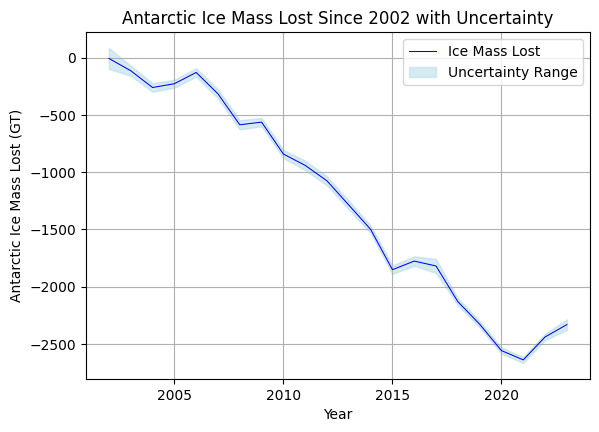

In [116]:
plt.figure(figsize=(6.5, 4.5))
plt.plot(df_ice_sheets['Year'], df_ice_sheets['Antarctic Ice Mass Lost Since 2002 (GT)'], label='Ice Mass Lost', color='blue', linewidth=0.75)
plt.fill_between(df_ice_sheets['Year'],
                 df_ice_sheets['Antarctic Ice Mass Lost Since 2002 (GT)'] - df_ice_sheets['Antarctic Ice Mass Loss Uncertainty (STD 1, GT)'],
                 df_ice_sheets['Antarctic Ice Mass Lost Since 2002 (GT)'] + df_ice_sheets['Antarctic Ice Mass Loss Uncertainty (STD 1, GT)'],
                 color='lightblue', alpha=0.5, label='Uncertainty Range')
plt.title('Antarctic Ice Mass Lost Since 2002 with Uncertainty')
plt.xlabel('Year')
plt.ylabel('Antarctic Ice Mass Lost (GT)')
plt.legend()
plt.grid(True)
plt.show()

Plotting the average ice mass lost in the Antarctic with the uncertainty behind it, we can see that there has been a negative correlation between ice lost and the year, indicating that as time passes, we have lost more and more antarctic ice.

#### 3.1.2 Analysis on Global Temperature Anomaly

The global temperature anomaly measures the change in global surface temperature compared to the long-term average from 1951 to 1980.

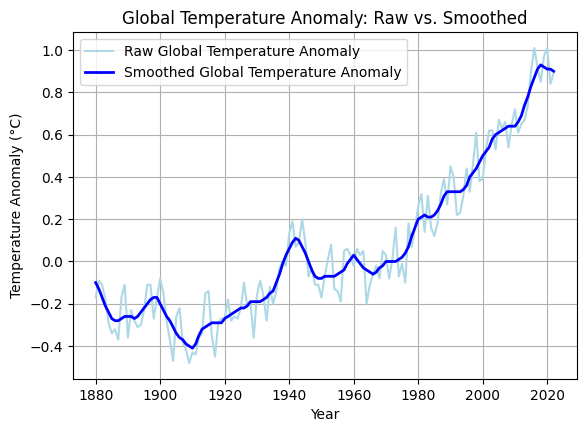

In [117]:
plt.figure(figsize=(6.5, 4.5))
plt.plot(df_global_temperatures['Year'], df_global_temperatures['Raw Global Temperature Anomaly (C)'], label='Raw Global Temperature Anomaly', color='lightblue')
plt.plot(df_global_temperatures['Year'], df_global_temperatures['Smoothed Global Temperature Anomaly (C)'], label='Smoothed Global Temperature Anomaly', color='blue', linewidth=2)
plt.title('Global Temperature Anomaly: Raw vs. Smoothed')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.grid(True)
plt.show()

Plotting the smoothed global temperature anomaly, we can see the general trend of the temperature anomaly that the raw data shows as well. This shows a clear positive correlation between year and the temperature anomaly, indicating the temperatures have departed significantly from the average in the 1950s-1980s over time.

#### 3.1.3 Analysis on Carbon Dioxide Levels

This data measures the average CO2 levels since 1958 in parts per million.

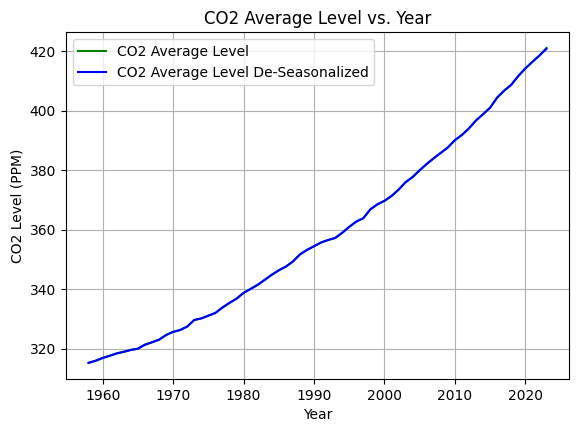

In [118]:
plt.figure(figsize=(6.5, 4.5))
plt.plot(df_c02_levels['Year'], df_c02_levels['CO2 Average Level (PPM)'], label='CO2 Average Level', color='green')
plt.plot(df_c02_levels['Year'], df_c02_levels['CO2 Average Level De-Seasonalized (PPM)'], label='CO2 Average Level De-Seasonalized', color='blue')
plt.title('CO2 Average Level vs. Year')
plt.xlabel('Year')
plt.ylabel('CO2 Level (PPM)')
plt.legend()
plt.grid(True)
plt.show()

Here, we can see a clear positive correlation between the year and the CO2 levels, indicating that as time has gone by, carbon dioxide levels have increased.

#### 3.1.3 Analysis on Average Methane Levels

This data plots the average methane level in parts per billion.

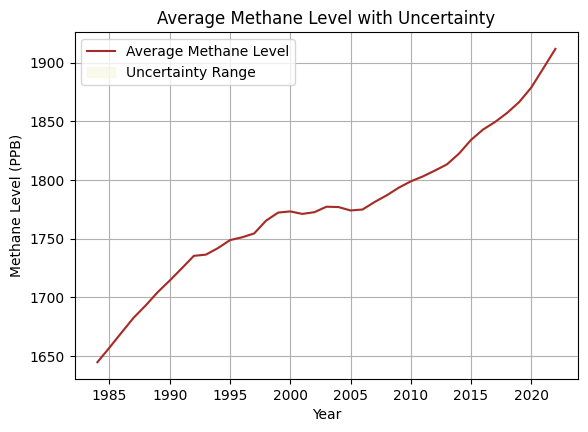

In [119]:
plt.figure(figsize=(6.5, 4.5))
plt.plot(df_methane['Year'], df_methane['Average Methane Level (PPB)'], label='Average Methane Level', color='brown')
plt.fill_between(df_methane['Year'],
                 df_methane['Average Methane Level (PPB)'] - df_methane['Methane Level Uncertainty (1 STD, PPB)'],
                 df_methane['Average Methane Level (PPB)'] + df_methane['Methane Level Uncertainty (1 STD, PPB)'],
                 color='beige', alpha=0.5, label='Uncertainty Range')
plt.title('Average Methane Level with Uncertainty')
plt.xlabel('Year')
plt.ylabel('Methane Level (PPB)')
plt.legend()
plt.grid(True)
plt.show()

We can see a clear positive correlation and increase in methane levels over time.

#### 3.1.4 Analysis on Global Mean Sea Level

This section takes relevant columns for the Global Mean Sea Levels and organizes it by year. GIA is Glacial Isostatic Adjustment (GIA), or the slow rising or sinking of land once burdened by ice sheets or glaciers. "No GIA" means this data does not account for these land level changes, and "GIA" means it does.

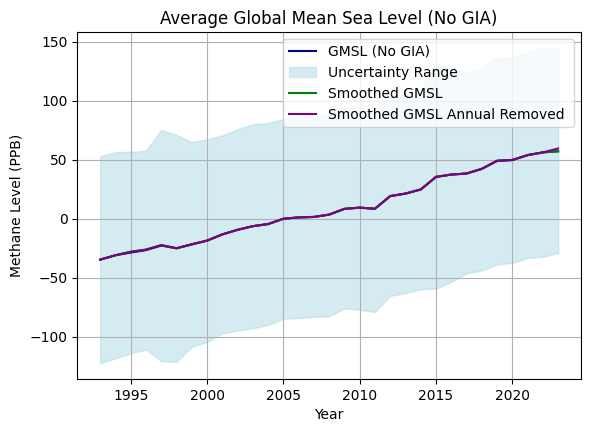

In [120]:
plt.figure(figsize=(6.5, 4.5))
plt.plot(df_sea_levels['Year'], df_sea_levels['Global Mean Sea Level (mm, No GIA)'], label='GMSL (No GIA)', color='navy')
plt.fill_between(df_sea_levels['Year'],
                 df_sea_levels['Global Mean Sea Level (mm, No GIA)'] - df_sea_levels['Standard Deviation of GMSL (mm, No GIA)'],
                 df_sea_levels['Global Mean Sea Level (mm, No GIA)'] + df_sea_levels['Standard Deviation of GMSL (mm, No GIA)'],
                 color='lightblue', alpha=0.5, label='Uncertainty Range')
plt.plot(df_sea_levels['Year'], df_sea_levels['Smoothed GMSL (No GIA)'], label = 'Smoothed GMSL', color = 'green')
plt.plot(df_sea_levels['Year'], df_sea_levels['Smoothed GMSL Annual/Semi-Annual Removed (mm, No GIA)'], label = 'Smoothed GMSL Annual Removed ', color = 'purple')
plt.title('Average Global Mean Sea Level (No GIA)')
plt.xlabel('Year')
plt.ylabel('Methane Level (PPB)')
plt.legend()
plt.grid(True)
plt.show()

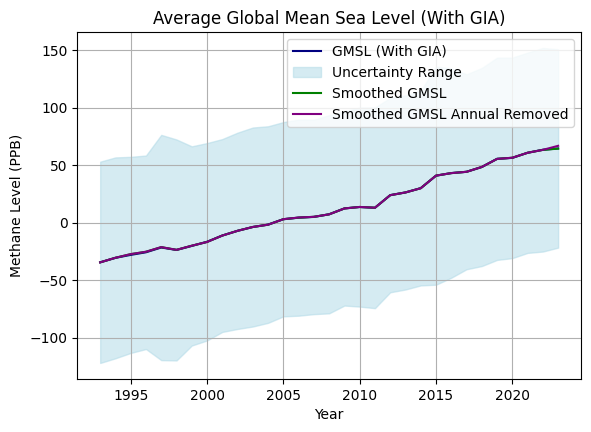

In [121]:
plt.figure(figsize=(6.5, 4.5))
plt.plot(df_sea_levels['Year'], df_sea_levels['Global Mean Sea Level (mm, With GIA)'], label='GMSL (With GIA)', color='navy')
plt.fill_between(df_sea_levels['Year'],
                 df_sea_levels['Global Mean Sea Level (mm, With GIA)'] - df_sea_levels['Standard Deviation of GMSL (mm, With GIA)'],
                 df_sea_levels['Global Mean Sea Level (mm, With GIA)'] + df_sea_levels['Standard Deviation of GMSL (mm, With GIA)'],
                 color='lightblue', alpha=0.5, label='Uncertainty Range')
plt.plot(df_sea_levels['Year'], df_sea_levels['Smoothed GMSL (With GIA)'], label = 'Smoothed GMSL', color = 'green')
plt.plot(df_sea_levels['Year'], df_sea_levels['Smoothed GMSL Annual/Semi-Annual Removed (mm, With GIA)'], label = 'Smoothed GMSL Annual Removed', color = 'purple')
plt.title('Average Global Mean Sea Level (With GIA)')
plt.xlabel('Year')
plt.ylabel('Methane Level (PPB)')
plt.legend()
plt.grid(True)
plt.show()

Even though this is a large area of uncertainty, there seems to be a clear positive correlation for all of the measured values, which indicates that methane levels have increased over time.

#### 3.1.5 Analysis on Ocean Warming

This data measures the ocean warming in zettajoules per year.

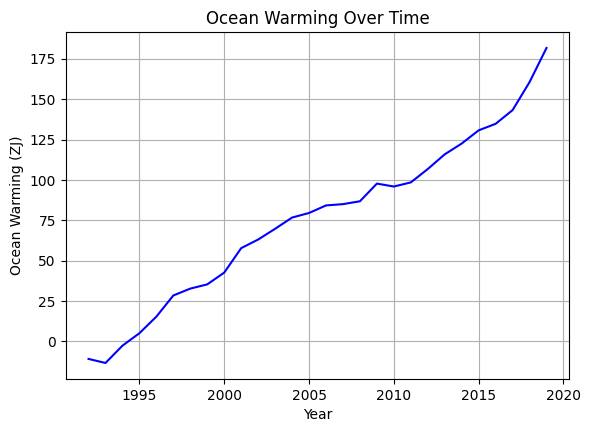

In [122]:
plt.figure(figsize=(6.5, 4.5))
plt.plot(df_ocean_warming['Year'], df_ocean_warming['Ocean Warming (ZJ)'], label='Ocean Warming', color='blue')
plt.title('Ocean Warming Over Time')
plt.xlabel('Year')
plt.ylabel('Ocean Warming (ZJ)')
plt.grid(True)
plt.show()

There seems to be a clear amount of ocean warming over the years that it was measured, indicating that oceans have gotten warmer over time.

#### 3.1.6. Analysis on Arctic Sea Ice Extent

This data measures the arctic sea ice extend in millions of killometers squared.

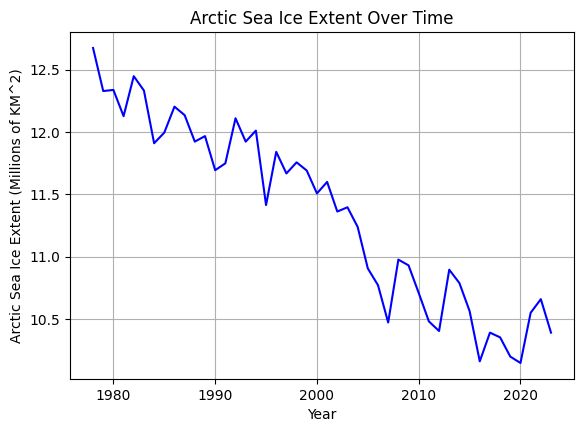

In [123]:
plt.figure(figsize=(6.5, 4.5))
plt.plot(df_arctic_sea_ice['Year'], df_arctic_sea_ice['Arctic Sea Ice Extent (Millions of KM^2)'],
         label='Arctic Sea Ice Extent', color='blue')
plt.title('Arctic Sea Ice Extent Over Time')
plt.xlabel('Year')
plt.ylabel('Arctic Sea Ice Extent (Millions of KM^2)')
plt.grid(True)
plt.show()

We can see a clear negative correlation between years and arctic sea ice extent, indicating that it has decreased over time.

### 3.2. Global Temperature Data Analysis



Our project aims to focus on understanding major changes in global temperatures and understanding what may cause significant changes in global temperature and how these correlate. In this section, we'll be looking at the trends of global temperature and highlighting anomalies in the data.

In [124]:
df_global_temperatures.head()

Year  Raw Global Temperature Anomaly (C)  \
0  1880                               -0.17   
1  1881                               -0.09   
2  1882                               -0.11   
3  1883                               -0.18   
4  1884                               -0.29   

   Smoothed Global Temperature Anomaly (C)  
0                                    -0.10  
1                                    -0.13  
2                                    -0.17  
3                                    -0.21  
4                                    -0.24

#### 3.2.1. Time Series Decomposition

Time series decomposition is a statistical technique used to separate a time series data set into 4 components:

Trend: The first component represents the long-term progression/trend of the series. Observing the trend component can provide insights into long-term changes or movements in the data, such as a gradual increase in global temperatures over several decades.

Seasonal: The second component patterns that repeat at regular intervals (such as seasonal patterns).

Residual (or Irregular): This component is what remains after the trend and seasonal components have been removed from the data. It represents the randomness or noise in the data. Analyzing the residuals can help in understanding the unexplained variance in the data and identifying anomalies or outliers.

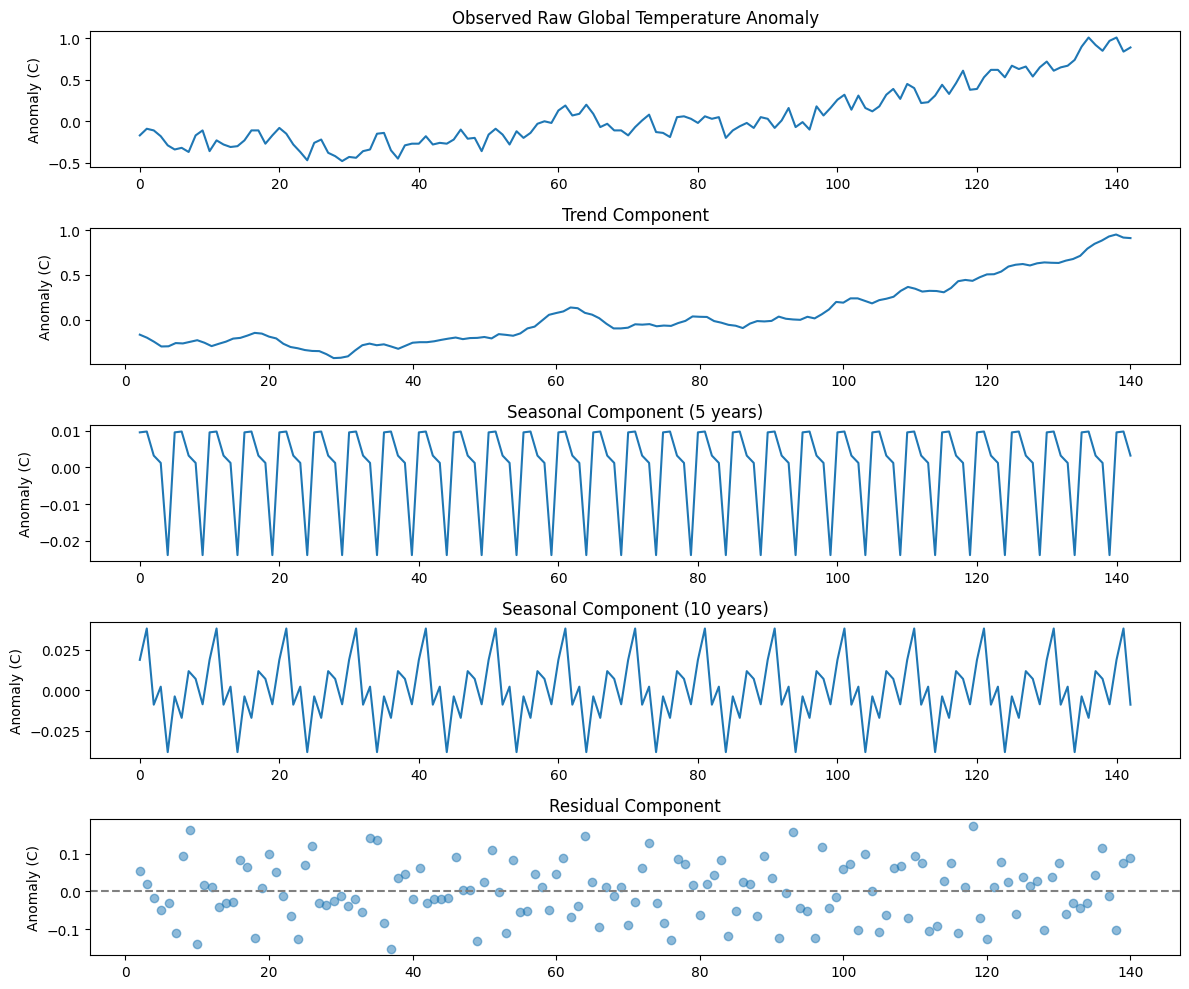

In [125]:
decomposition = sm.tsa.seasonal_decompose(df_global_temperatures['Raw Global Temperature Anomaly (C)'], model='additive', period=5)
decomposition_short = sm.tsa.seasonal_decompose(df_global_temperatures['Raw Global Temperature Anomaly (C)'], model='additive', period=10)

fig, axes = plt.subplots(5, 1, figsize=(12, 10))

axes[0].plot(decomposition.observed)
axes[0].set_title('Observed Raw Global Temperature Anomaly')
axes[0].set_ylabel('Anomaly (C)')

axes[1].plot(decomposition.trend)
axes[1].set_title('Trend Component')
axes[1].set_ylabel('Anomaly (C)')

axes[2].plot(decomposition.seasonal)
axes[2].set_title('Seasonal Component (5 years)')
axes[2].set_ylabel('Anomaly (C)')

axes[3].plot(decomposition_short.seasonal)
axes[3].set_title('Seasonal Component (10 years)')
axes[3].set_ylabel('Anomaly (C)')

axes[4].scatter(df_global_temperatures.index, decomposition.resid, alpha=0.5)
axes[4].set_title('Residual Component')
axes[4].set_ylabel('Anomaly (C)')
axes[4].axhline(0, color='grey', linestyle='--')

plt.tight_layout()
plt.show()


#### 3.2.2. Global Temperature Change Anomalies

This graph finds the change in global temperature every year and specifically highlights anomalies in the data (changes that are more than two standard deviations from the mean change per year).

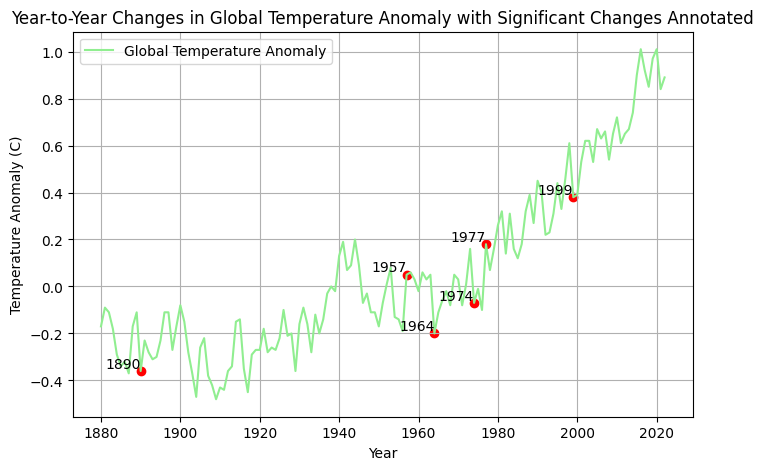

In [126]:
import matplotlib.pyplot as plt

df_global_temperatures['Temp_Change'] = df_global_temperatures['Raw Global Temperature Anomaly (C)'].diff()

std_change = df_global_temperatures['Temp_Change'].std()
threshold_major_change = 2 * std_change

df_global_temperatures['Significant_Change'] = abs(df_global_temperatures['Temp_Change']) > threshold_major_change

plt.figure(figsize=(8, 5))
plt.plot(df_global_temperatures['Year'], df_global_temperatures['Raw Global Temperature Anomaly (C)'], label='Global Temperature Anomaly', color='lightgreen')
for year, temp_anomaly, temp_change, is_significant in df_global_temperatures[['Year', 'Raw Global Temperature Anomaly (C)', 'Temp_Change', 'Significant_Change']].itertuples(index=False):
    if is_significant:
        plt.scatter(year, temp_anomaly, color='red')
        plt.text(year, temp_anomaly, f'{year}', ha='right', va='bottom')

plt.title('Year-to-Year Changes in Global Temperature Anomaly with Significant Changes Annotated')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (C)')
plt.legend()
plt.grid(True)
plt.show()

#### 3.2.4. Difference in Trends after Significant Natural Global Events

This section of the notebook is analyzes the impact of significant climatic phenomena, El Niño and La Niña, on global temperature anomalies. These events are known to cause substantial deviations in weather patterns across the globe.

El Niño: A climatic event characterized by the warming of the ocean surface temperatures in the central and eastern tropical Pacific Ocean. El Niño events typically lead to significant weather variations, such as increased rainfall in some regions and drought in others, and are associated with warmer global temperatures.

La Niña: The counterpart to El Niño, La Niña is marked by unusually cold ocean temperatures in the Equatorial Pacific. La Niña events often result in opposite weather patterns compared to El Niño, including cooler global temperatures.

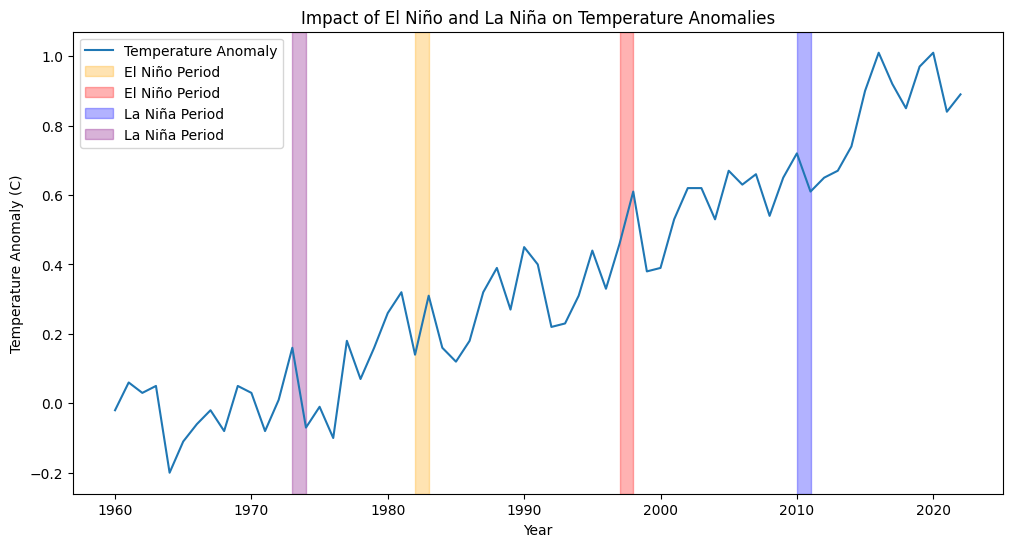

Average temperature anomaly during El Niño (1982-1983): 0.23C
Average temperature anomaly during La Niña (2010-2011): 0.67C
Average temperature anomaly during El Niño (1997-1998): 0.54C
Average temperature anomaly during La Niña (1973-1974): 0.04C


In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

el_nino_start, el_nino_end = 1982, 1983
el_nino_start_2, el_nino_end_2 = 1997, 1998
la_nina_start, la_nina_end = 2010, 2011
la_nina_start_2, la_nina_end_2 = 1973, 1974

df_global_temperatures_2 = df_global_temperatures[df_global_temperatures['Year'] >= 1960]

el_nino_period = df_global_temperatures_2[(df_global_temperatures_2['Year'] >= el_nino_start) & (df_global_temperatures_2['Year'] <= el_nino_end)]
la_nina_period = df_global_temperatures_2[(df_global_temperatures_2['Year'] >= la_nina_start) & (df_global_temperatures_2['Year'] <= la_nina_end)]
el_nino_period_2 = df_global_temperatures_2[(df_global_temperatures_2['Year'] >= el_nino_start_2) & (df_global_temperatures_2['Year'] <= el_nino_end_2)]
la_nina_period_2 = df_global_temperatures_2[(df_global_temperatures_2['Year'] >= la_nina_start_2) & (df_global_temperatures_2['Year'] <= la_nina_end_2)]

average_el_nino = el_nino_period['Raw Global Temperature Anomaly (C)'].mean()
average_la_nina = la_nina_period['Raw Global Temperature Anomaly (C)'].mean()
average_el_nino_2 = el_nino_period_2['Raw Global Temperature Anomaly (C)'].mean()
average_la_nina_2 = la_nina_period_2['Raw Global Temperature Anomaly (C)'].mean()

plt.figure(figsize=(12, 6))
plt.plot(df_global_temperatures_2['Year'], df_global_temperatures_2['Raw Global Temperature Anomaly (C)'], label='Temperature Anomaly')
plt.axvspan(el_nino_start, el_nino_end, color='orange', alpha=0.3, label='El Niño Period')
plt.axvspan(el_nino_start_2, el_nino_end_2, color='red', alpha=0.3, label='El Niño Period')
plt.axvspan(la_nina_start, la_nina_end, color='blue', alpha=0.3, label='La Niña Period')
plt.axvspan(la_nina_start_2, la_nina_end_2, color='purple', alpha=0.3, label='La Niña Period')
plt.title('Impact of El Niño and La Niña on Temperature Anomalies')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (C)')
plt.legend()
plt.show()

print(f"Average temperature anomaly during El Niño (1982-1983): {average_el_nino:.2f}C")
print(f"Average temperature anomaly during La Niña (2010-2011): {average_la_nina:.2f}C")
print(f"Average temperature anomaly during El Niño (1997-1998): {average_el_nino_2:.2f}C")
print(f"Average temperature anomaly during La Niña (1973-1974): {average_la_nina_2:.2f}C")


### 3.3. Correlation Between Environmental Indicators and Global Temperature

#### 3.3.1. Correlation Between Raw Global Temperature Anomalies and All Variables

This code plots the correlation between the Raw Global Temperature departure from mean and all of the environmental variables on a scatter plot to better visualize the strength of the correlation.

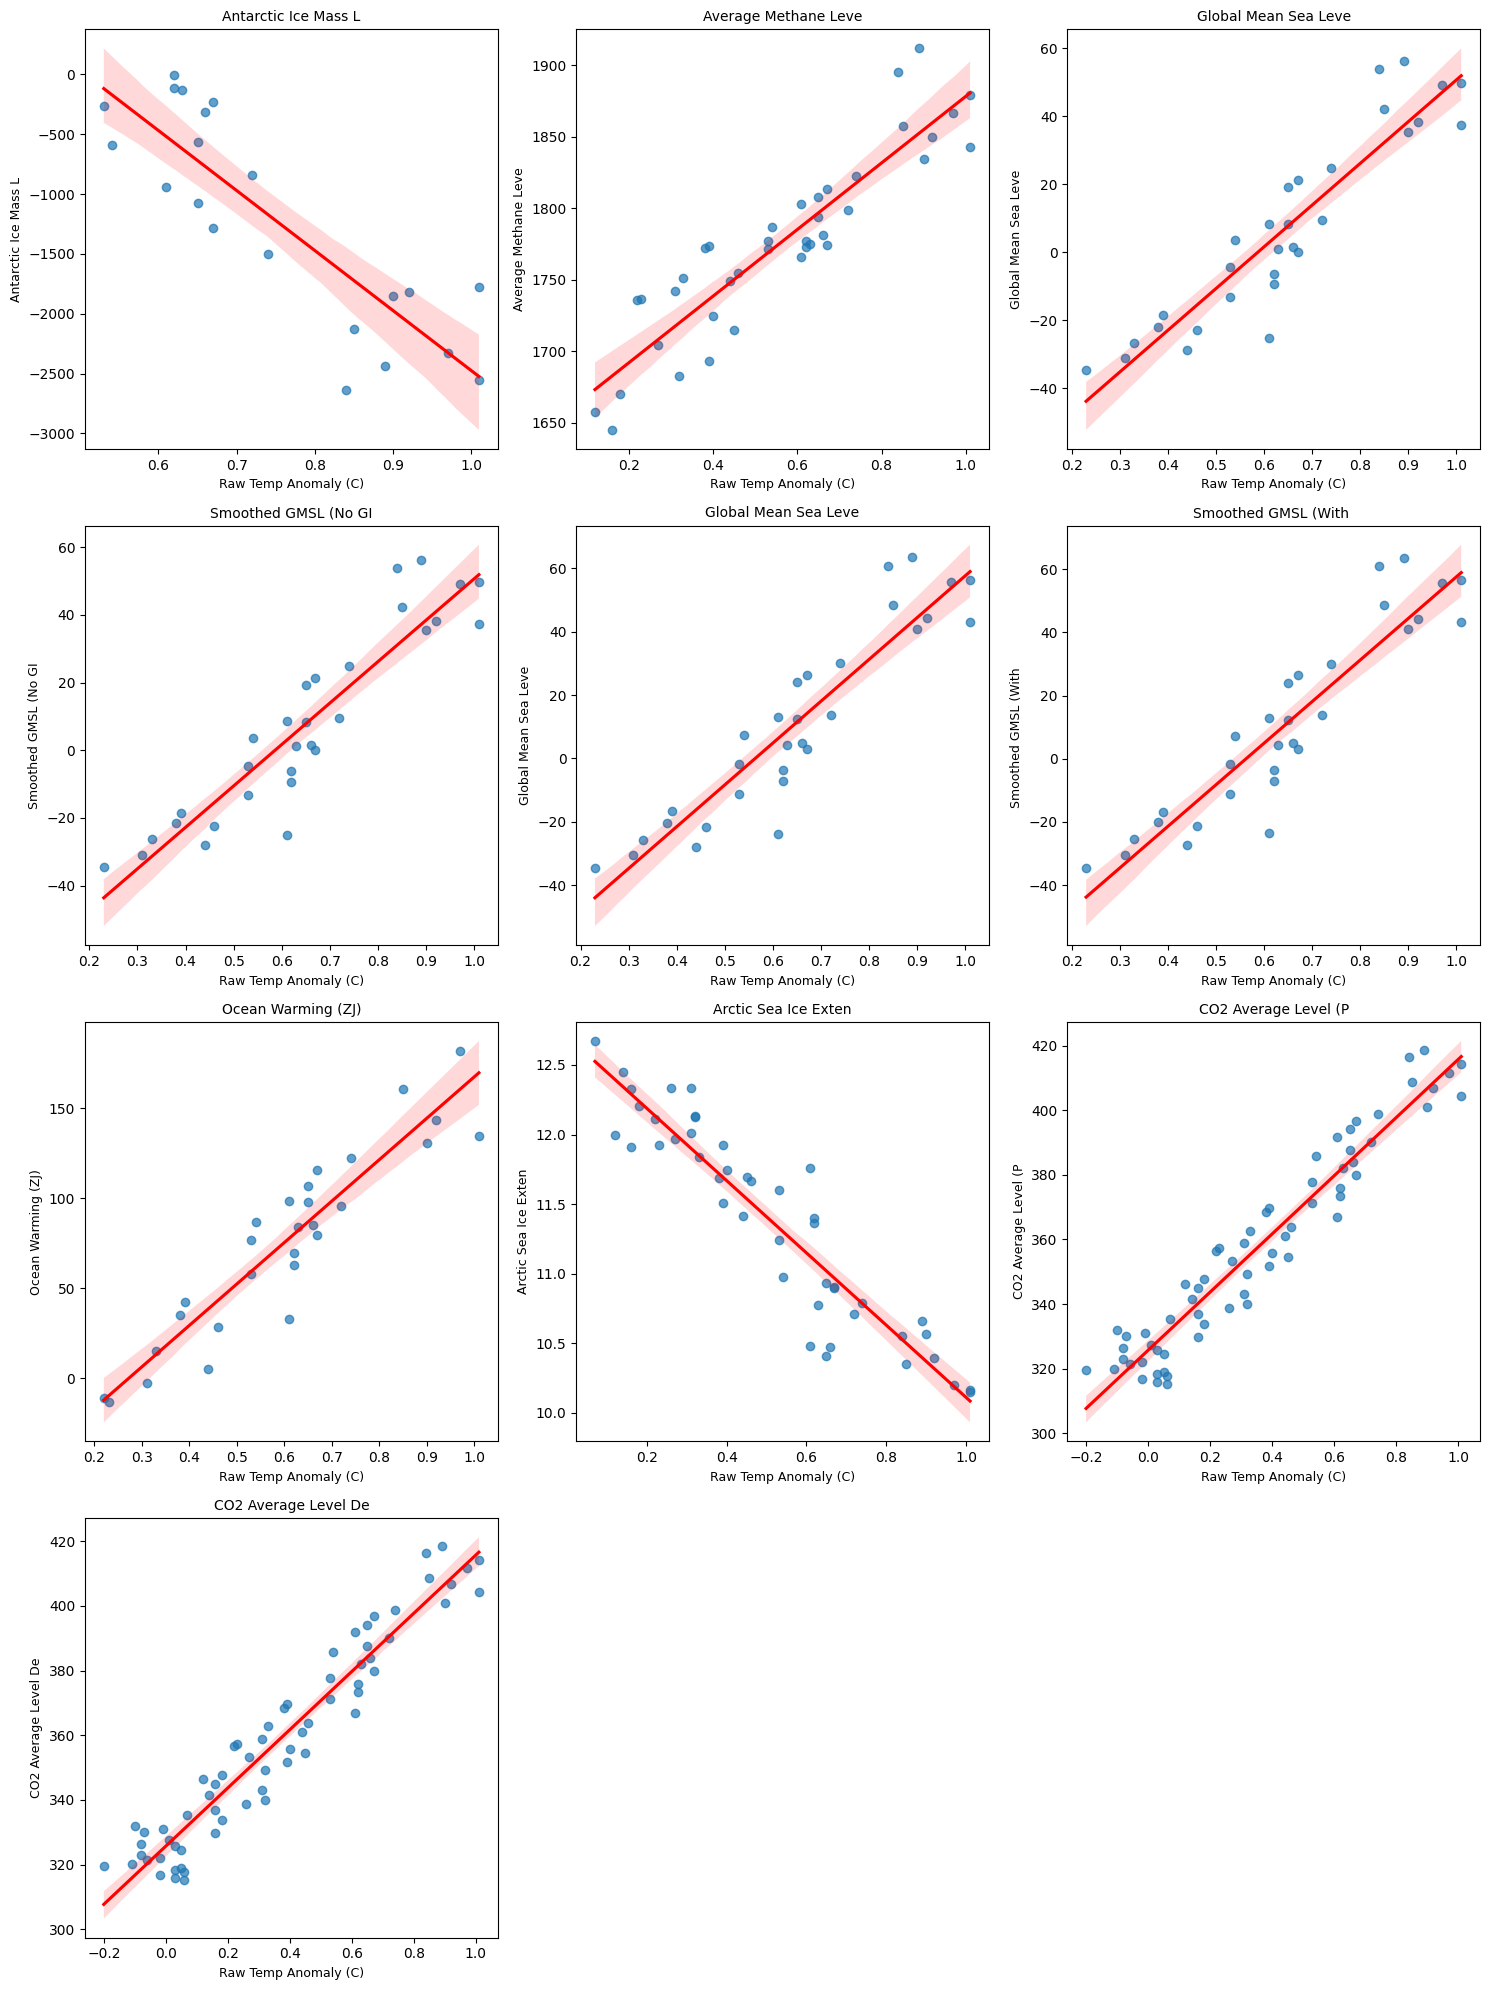

In [128]:
import numpy as np
import seaborn as sns
variables_to_plot = [col for col in df_averages.columns if col not in ['Year', 'Smoothed Global Temperature Anomaly (C)', 'Raw Global Temperature Anomaly (C)']]

n_cols = 3
n_rows = int(np.ceil(len(variables_to_plot) / float(n_cols)))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

axes_flat = axes.flatten()

for i, variable in enumerate(variables_to_plot):
    ax = axes_flat[i]
    sns.regplot(ax=ax, data=df_averages, x='Raw Global Temperature Anomaly (C)', y=variable, scatter_kws={'alpha':0.7}, line_kws={'color': 'red'})
    ax.set_title(variable[:20], fontsize=10)
    ax.set_xlabel('Raw Temp Anomaly (C)', fontsize=9)
    ax.set_ylabel(variable[:20], fontsize=9)

for ax in axes_flat[i+1:]:
    ax.remove()

plt.tight_layout()
plt.show()


#### 3.3.2. Correlation Between Smoothed Global Temperature Anomalies and All Variables

This code plots the correlation between the Smoothed Global Temperature departure from mean and all of the environmental variables on a scatter plot to better visualize the strength of the correlation.

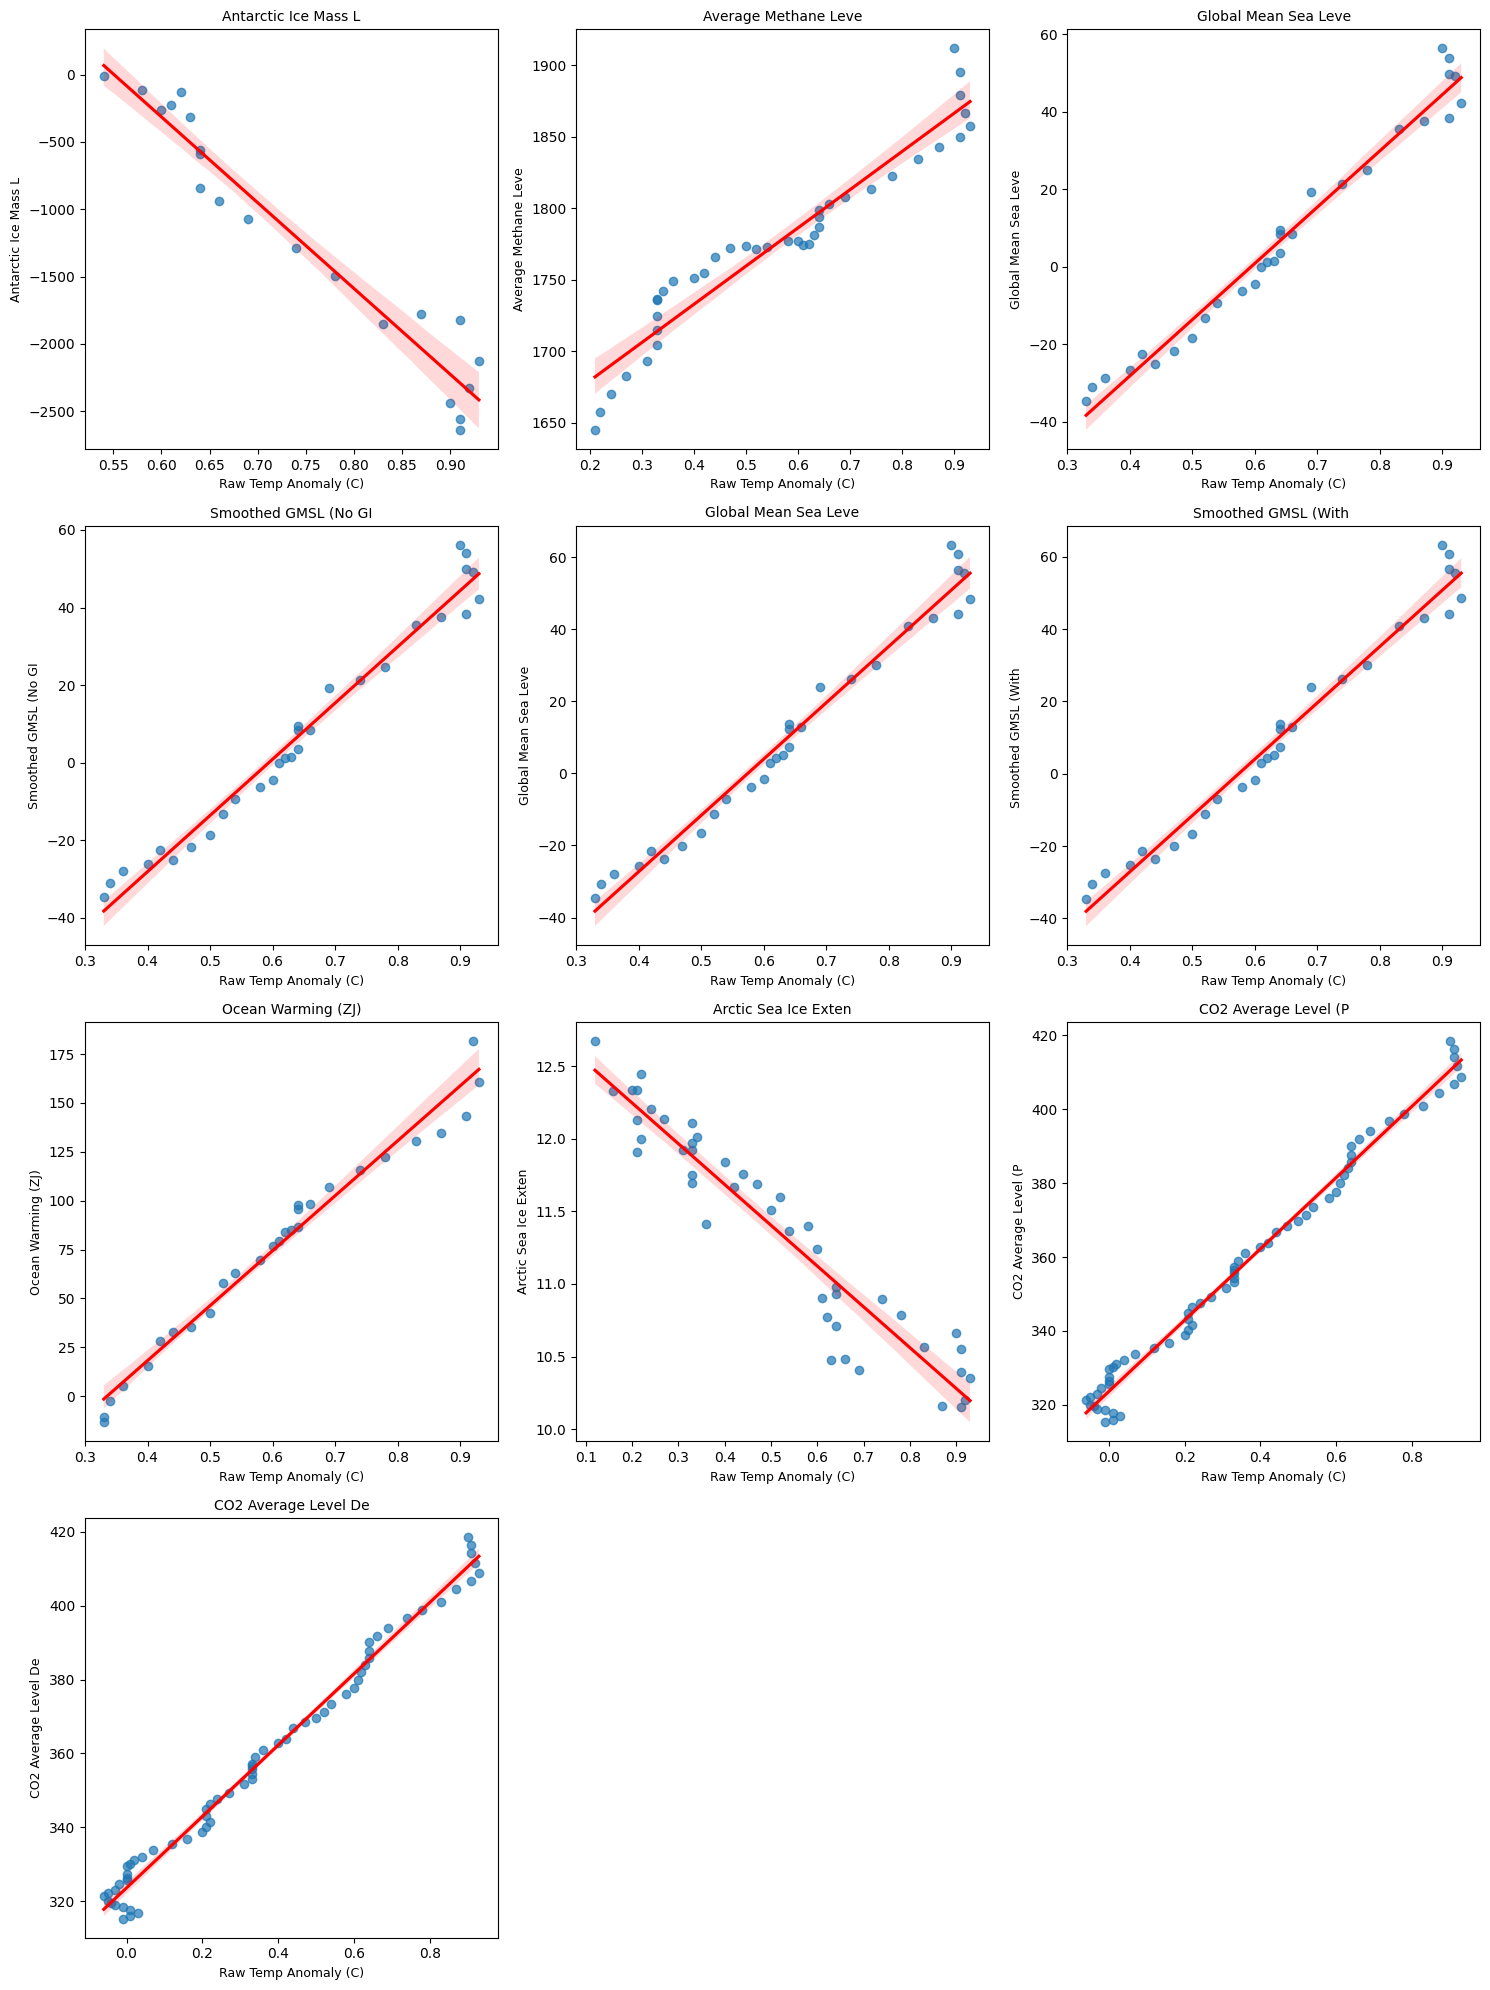

In [129]:
import numpy as np
import seaborn as sns
variables_to_plot = [col for col in df_averages.columns if col not in ['Year', 'Smoothed Global Temperature Anomaly (C)', 'Raw Global Temperature Anomaly (C)']]

n_cols = 3
n_rows = int(np.ceil(len(variables_to_plot) / float(n_cols)))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

axes_flat = axes.flatten()

for i, variable in enumerate(variables_to_plot):
    ax = axes_flat[i]
    sns.regplot(ax=ax, data=df_averages, x='Smoothed Global Temperature Anomaly (C)', y=variable, scatter_kws={'alpha':0.7}, line_kws={'color': 'red'})
    ax.set_title(variable[:20], fontsize=10)
    ax.set_xlabel('Raw Temp Anomaly (C)', fontsize=9)
    ax.set_ylabel(variable[:20], fontsize=9)

for ax in axes_flat[i+1:]:
    ax.remove()

plt.tight_layout()
plt.show()

#### 3.3.3. Heatmap

This visualizes the correlation strength between the variables in question, where values of magnitude closer to 1 are more correlated.

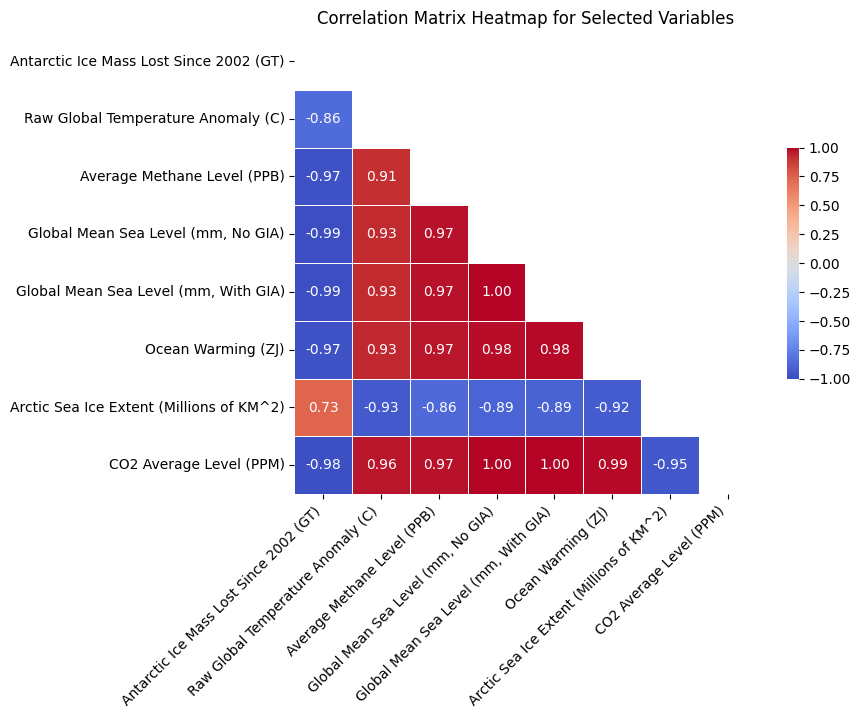

In [130]:
selected_variables = ['Antarctic Ice Mass Lost Since 2002 (GT)',
                        'Raw Global Temperature Anomaly (C)',
                        'Average Methane Level (PPB)',
                        'Global Mean Sea Level (mm, No GIA)',
                        'Global Mean Sea Level (mm, With GIA)',
                    	'Ocean Warming (ZJ)',
                        'Arctic Sea Ice Extent (Millions of KM^2)',
                        'CO2 Average Level (PPM)']

correlation_matrix = df_averages[selected_variables].corr()

mask_upper_triangle = np.triu(np.ones_like(correlation_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(correlation_matrix, mask=mask_upper_triangle, cmap='coolwarm', vmax=1.0, vmin=-1.0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix Heatmap for Selected Variables')
plt.show()

### 3.4 Principal Component Analysis

The goal of this section is to apply Principal Component Analysis (PCA) to our dataset to reduce the dimensionality while capturing most of the variance in the data. This approach helps in simplifying the data, reducing noise, and potentially improving the performance of subsequent analyses or machine learning models.

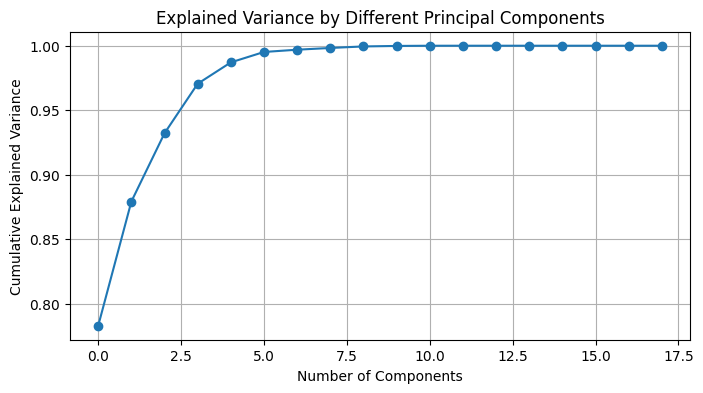

Optimal number of dimensions: 4


In [131]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(merged_df_no_nan)

pca = PCA()
principal_components = pca.fit_transform(df_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 4))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Principal Components')
plt.grid(True)
plt.show()

optimal_dimensions = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Optimal number of dimensions: {optimal_dimensions}")

In [132]:
pca = PCA(n_components=4)
principal_components = pca.fit_transform(df_scaled)

df_pca = pd.DataFrame(principal_components, columns=[f'PC{i}' for i in range(0, 4)])
print(df_pca.shape)
df_pca.head()

(18, 4)


PC0       PC1       PC2       PC3
0 -5.779023  1.089468  2.749744 -1.418462
1 -4.791570  1.321057  0.245061  0.820824
2 -4.465079  0.545563 -0.090873  1.275631
3 -3.428094 -0.549421 -0.669091  0.120189
4 -3.156410  0.034463 -0.402579  0.696058

In [133]:
loadings = pca.components_
loading_matrix = pd.DataFrame(loadings, columns=merged_df_no_nan.columns, index=[f'PC{i+1}' for i in range(4)])
print(loading_matrix.shape)
loading_matrix.head()

(4, 19)


Year  Antarctic Ice Mass Lost Since 2002 (GT)  \
PC1  0.255002                                -0.255870   
PC2 -0.085884                                 0.002073   
PC3 -0.011787                                -0.048731   
PC4  0.003077                                -0.027210   

     Antarctic Ice Mass Loss Uncertainty (STD 1, GT)  \
PC1                                        -0.090769   
PC2                                         0.131633   
PC3                                         0.787140   
PC4                                        -0.540498   

     Raw Global Temperature Anomaly (C)  \
PC1                            0.231554   
PC2                            0.160800   
PC3                            0.160360   
PC4                           -0.073846   

     Smoothed Global Temperature Anomaly (C)  Average Methane Level (PPB)  \
PC1                                 0.254028                     0.255405   
PC2                                -0.029397                    -0.018415   
PC3                                 0.099281                     0.118260   
PC4                                 0.026780                    -0.001548   

     Methane Level Uncertainty (1 STD, PPB)  \
PC1                                0.087954   
PC2                               -0.363990   
PC3                               -0.413037   
PC4                               -0.788618   

     Global Mean Sea Level (mm, No GIA)  \
PC1                            0.258250   
PC2                           -0.015955   
PC3                            0.057197   
PC4                            0.037525   

     Standard Deviation of GMSL (mm, No GIA)  Smoothed GMSL (No GIA)  \
PC1                                 0.115469                0.258288   
PC2                                 0.629355               -0.015471   
PC3                                -0.233441                0.056518   
PC4                                -0.163698                0.036156   

     Global Mean Sea Level (mm, With GIA)  \
PC1                              0.258361   
PC2                             -0.020613   
PC3                              0.052699   
PC4                              0.035215   

     Standard Deviation of GMSL (mm, With GIA)  Smoothed GMSL (With GIA)  \
PC1                                   0.120895                  0.258395   
PC2                                   0.625721                 -0.020165   
PC3                                  -0.214612                  0.052055   
PC4                                  -0.154311                  0.033931   

     Smoothed GMSL Annual/Semi-Annual Removed (mm, With GIA)  \
PC1                                           0.258393         
PC2                                          -0.020172         
PC3                                           0.051944         
PC4                                           0.034247         

     Smoothed GMSL Annual/Semi-Annual Removed (mm, No GIA)  \
PC1                                           0.258286       
PC2                                          -0.015476       
PC3                                           0.056401       
PC4                                           0.036492       

     Ocean Warming (ZJ)  Arctic Sea Ice Extent (Millions of KM^2)  \
PC1            0.253571                                 -0.214350   
PC2           -0.074662                                  0.083974   
PC3            0.043103                                  0.193202   
PC4            0.097173                                  0.106074   

     CO2 Average Level (PPM)  CO2 Average Level De-Seasonalized (PPM)  
PC1                 0.256470                                 0.256471  
PC2                -0.082263                                -0.082247  
PC3                 0.009200                                 0.009190  
PC4                 0.007284                                 0.007263

In [134]:
for i, pc in enumerate(loading_matrix.index):
    print(f"{pc} - Principal Component {i+1}")
    # Sort the loadings by absolute value and print them
    sorted_loadings = loading_matrix.loc[pc].abs().sort_values(ascending=False)
    print(sorted_loadings)
    print("\n")

PC1 - Principal Component 1
Smoothed GMSL (With GIA)                                   0.258395
Smoothed GMSL Annual/Semi-Annual Removed (mm, With GIA)    0.258393
Global Mean Sea Level (mm, With GIA)                       0.258361
Smoothed GMSL (No GIA)                                     0.258288
Smoothed GMSL Annual/Semi-Annual Removed (mm, No GIA)      0.258286
Global Mean Sea Level (mm, No GIA)                         0.258250
CO2 Average Level De-Seasonalized (PPM)                    0.256471
CO2 Average Level (PPM)                                    0.256470
Antarctic Ice Mass Lost Since 2002 (GT)                    0.255870
Average Methane Level (PPB)                                0.255405
Year                                                       0.255002
Smoothed Global Temperature Anomaly (C)                    0.254028
Ocean Warming (ZJ)                                         0.253571
Raw Global Temperature Anomaly (C)                         0.231554
Arctic Sea Ice Exten

In [135]:
pca_selected_features = ['Smoothed GMSL (With GIA)', 'Smoothed GMSL Annual/Semi-Annual Removed (mm, With GIA)',
                         'Standard Deviation of GMSL (mm, No GIA)', 'Standard Deviation of GMSL (mm, With GIA)',
                         'Antarctic Ice Mass Loss Uncertainty (STD 1, GT)', 'Methane Level Uncertainty (1 STD, PPB)']

## 5. Predictive Modeling

### 5.1. Model Selection

#### 5.1.1 Linear Regression

A linear regression model is best suited for our project due to it's simplicitiy. Since our data is limited, by using linear regression our model is less likely to overfit to the training data when compared to a more complex model. Linear regression also helps us understand the relationship between the selected featurs and the target variable, as it assumes a linear relationship between the two. The allows us to quantify the impact of each feature on target.

In [136]:
def get_mse_r2(target_column, df):
  X = df.drop(columns=[target_column])
  y = df[target_column]
  X = X.values
  y = y.values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = LinearRegression()

  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  return model, mse, r2

In [137]:
def get_mse_r2_pca(target_column,pca_selected_features, df):
  selected_features = []

  for feature in pca_selected_features:
    if feature != target_column:
      selected_features.append(feature)

  X = df[selected_features]
  y = df[target_column]
  X = X.values
  y = y.values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = LinearRegression()

  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  return model, mse, r2

#### 5.1.2 LSTM


Using Long Short-Term Memory (LSTM) neural networks is a good choice for our dataset, particularly when predicting how climate variables change over time which may lead to global warming. LSTMs are a type of recurrent neural network (RNN) designed to capture temporal dependencies and patterns within sequential data. LSTMs excel at modeling and learning  patterns in time series data, making them well suited for predicting climate related variables. LSTMs can retain and update information over extended periods of time, this is an advatnage that we can use in order to predict future climate change variables.

In [138]:
def lstm_model(X_train):
  model = Sequential()

  model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model.add(Dropout(0.2))

  model.add(LSTM(units=64, return_sequences=True))
  model.add(Dropout(0.2))

  model.add(LSTM(units=32, return_sequences=False))
  model.add(Dropout(0.2))

  model.add(Dense(units=1))

  model.compile(optimizer='adam', loss='mse')

  return model

### 5.2. Model Training and Validation
Train models on historical data and validate their performance.

In [139]:
results = {}
all_columns = df_imputed.columns.values
print(type(all_columns))
print(all_columns)

<class 'numpy.ndarray'>
['Year' 'Antarctic Ice Mass Lost Since 2002 (GT)'
 'Antarctic Ice Mass Loss Uncertainty (STD 1, GT)'
 'Raw Global Temperature Anomaly (C)'
 'Smoothed Global Temperature Anomaly (C)' 'Average Methane Level (PPB)'
 'Methane Level Uncertainty (1 STD, PPB)'
 'Global Mean Sea Level (mm, No GIA)'
 'Standard Deviation of GMSL (mm, No GIA)' 'Smoothed GMSL (No GIA)'
 'Global Mean Sea Level (mm, With GIA)'
 'Standard Deviation of GMSL (mm, With GIA)' 'Smoothed GMSL (With GIA)'
 'Smoothed GMSL Annual/Semi-Annual Removed (mm, With GIA)'
 'Smoothed GMSL Annual/Semi-Annual Removed (mm, No GIA)'
 'Ocean Warming (ZJ)' 'Arctic Sea Ice Extent (Millions of KM^2)'
 'CO2 Average Level (PPM)' 'CO2 Average Level De-Seasonalized (PPM)']


#### 5.2.1 Linear Regression With df_imputed


In [140]:
def train_linear(df, target_column, ridge_alpha=1, scaler=None, pca_selected_features=None, random_state=42):

  selected_features = []
  X = None

  if pca_selected_features is None:
    X = df.drop(columns=[target_column])
  else:
    for feature in pca_selected_features:
      if feature != target_column:
        selected_features.append(feature)
    X = df[selected_features]


  y = df[target_column]
  X = X.values
  y = y.values

  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=random_state)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=random_state)

  if scaler is not None:
      X_train_scaled = scaler.fit_transform(X_train)
      X_val_scaled = scaler.transform(X_val)
      X_test_scaled = scaler.transform(X_test)
  else:
      X_train_scaled, X_val_scaled, X_test_scaled = X_train, X_val, X_test

  ridge_model = Ridge(alpha=ridge_alpha)
  ridge_model.fit(X_train_scaled, y_train)

  y_val_pred = ridge_model.predict(X_val_scaled)
  mse_val = mean_squared_error(y_val, y_val_pred)
  r2_val = r2_score(y_val, y_val_pred)

  y_test_pred = ridge_model.predict(X_test_scaled)
  mse_test = mean_squared_error(y_test, y_test_pred)
  r2_test = r2_score(y_test, y_test_pred)

  to_return = {
      "val_mse": mse_val,
      "val_r2": r2_val,
      "test_mse": mse_test,
      "test_r2": r2_test,
  }

  # for key, value in to_return.items():
  #     print(f"{key}: {value}")

  plot_target_vs_time(target_column, X_train, X_val, X_test, y_train, y_val, y_test, y_val_pred, validation=True, pca=pca_selected_features)

  plot_target_vs_time(target_column, X_train, X_val, X_test, y_train, y_val, y_test, y_test_pred, validation=False, pca=pca_selected_features)

  return to_return


In [141]:
def plot_target_vs_time(target_column, X_train, X_val, X_test, y_train, y_val, y_test, y_pred, validation=True, pca=None):
  title = target_column + ' Prediction vs Actual '
  if validation:
    title = title + ' (Validation)'
    if pca is not None:
      title = title + ' (pca)'
    plt.figure(figsize=(10, 6))
    start_index = X_train.shape[0]
    end_index = X_train.shape[0] + X_val.shape[0]
    plt.plot(df_final.index[start_index:end_index], y_val, label='Actual')
    plt.plot(df_final.index[start_index:end_index], y_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(target_column)
    plt.legend()
    plt.show()
  else:
    title = title + ' (Testing)'
    if pca is not None:
      title = title + ' (pca)'
    plt.figure(figsize=(10, 6))
    start_index = X_train.shape[0] + X_val.shape[0]
    end_index = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]
    plt.plot(df_final.index[-X_test.shape[0]:], y_test, label='Actual')
    plt.plot(df_final.index[-X_test.shape[0]:], y_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(target_column)
    plt.legend()
    plt.show()

In [142]:
results = {}

##### 5.2.1.1 Predicting Raw Global Temperature Anomaly (C)


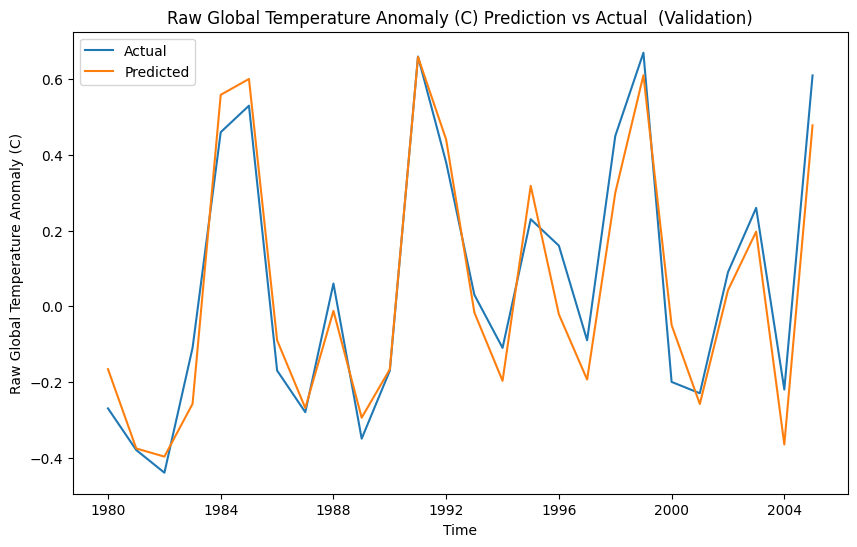

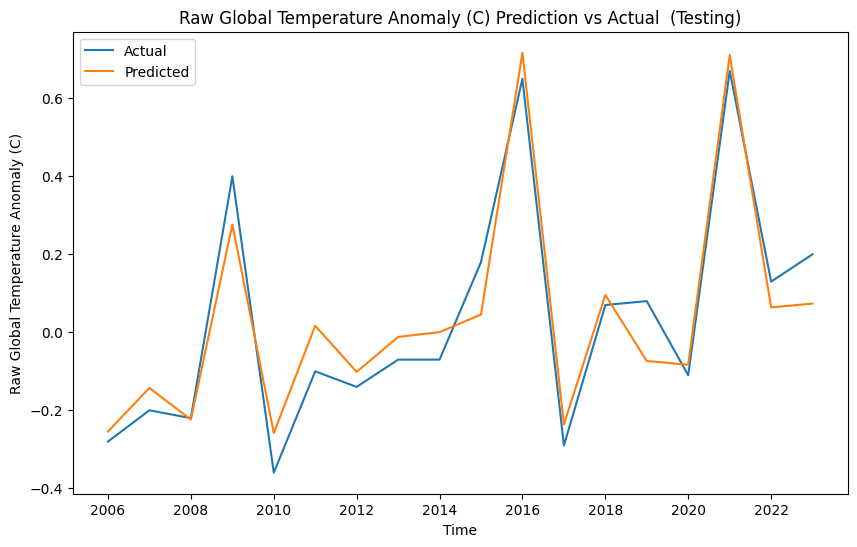

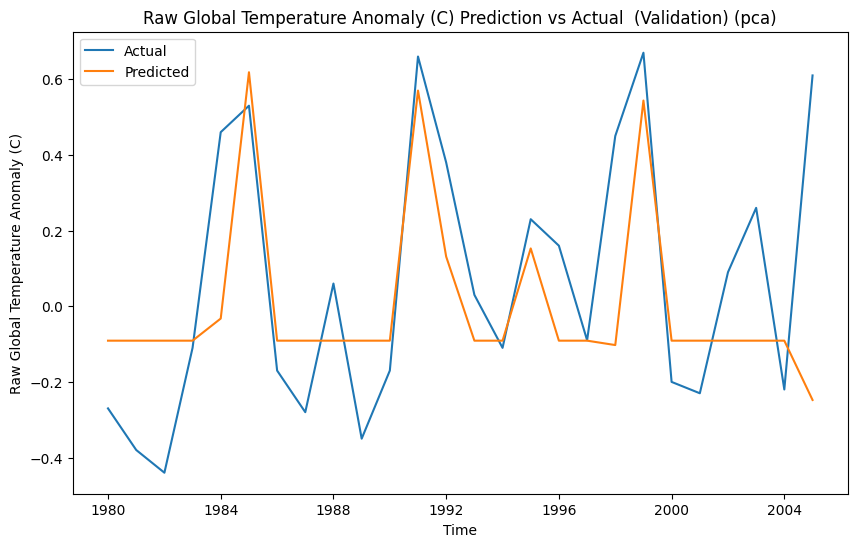

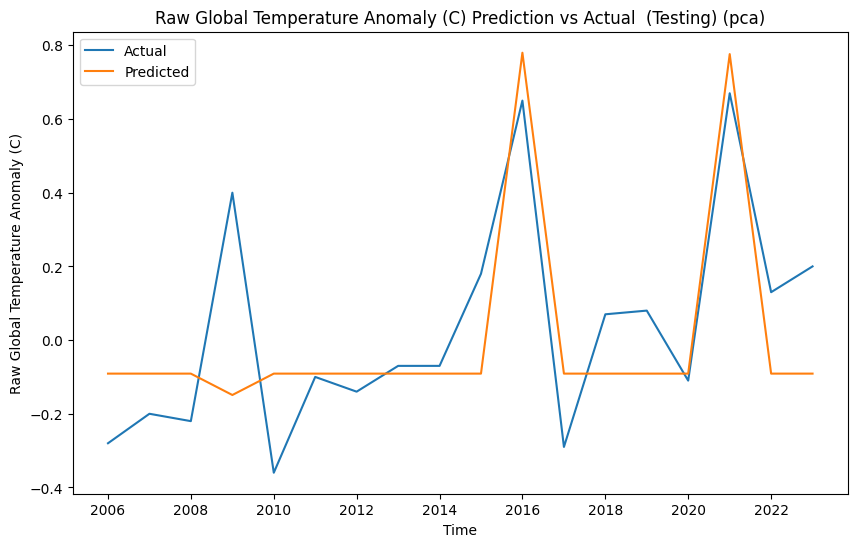

In [143]:
target = 'Raw Global Temperature Anomaly (C)'
results[target] = {}

info = train_linear(df_imputed, target, ridge_alpha=0.1, scaler=StandardScaler())
results[target]['all features'] = info

info = train_linear(df_imputed, target, ridge_alpha=0.1,
                    scaler=StandardScaler(), pca_selected_features=pca_selected_features)
results[target]['pca selected features'] = info

##### 5.2.1.2 Predicting Smoothed Global Temperature Anomaly (C)


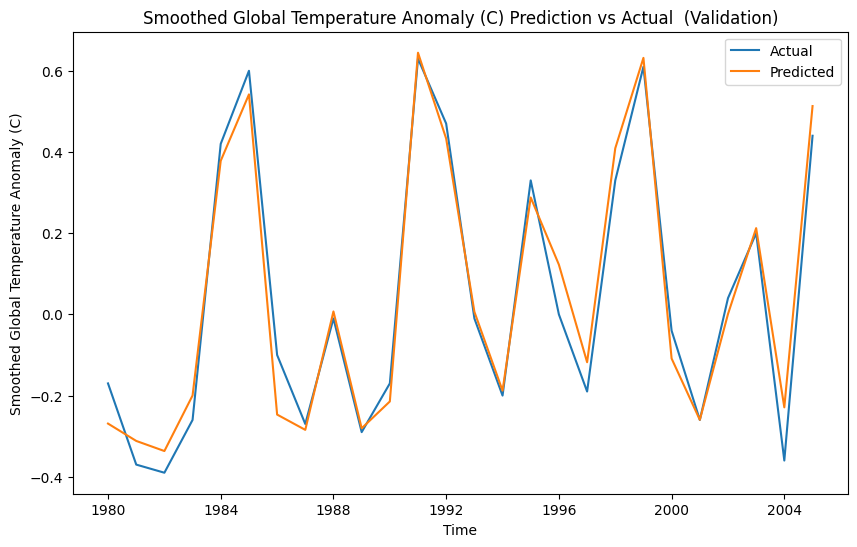

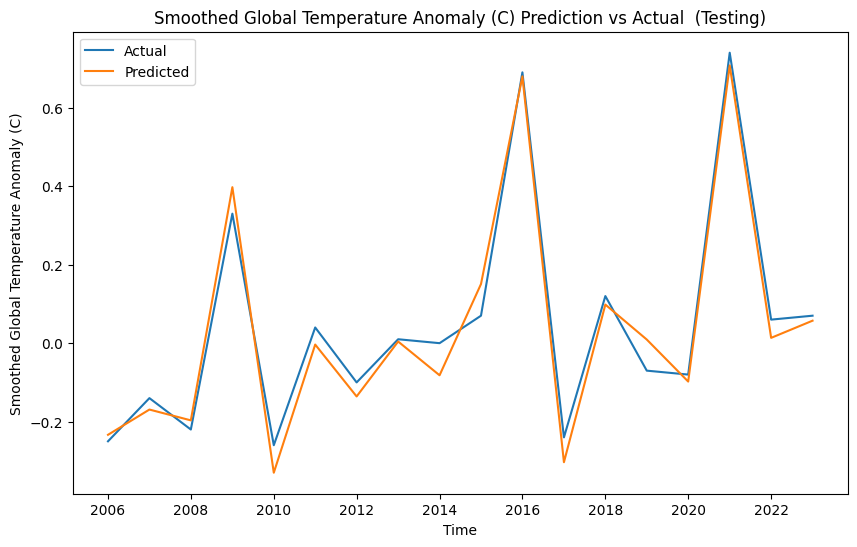

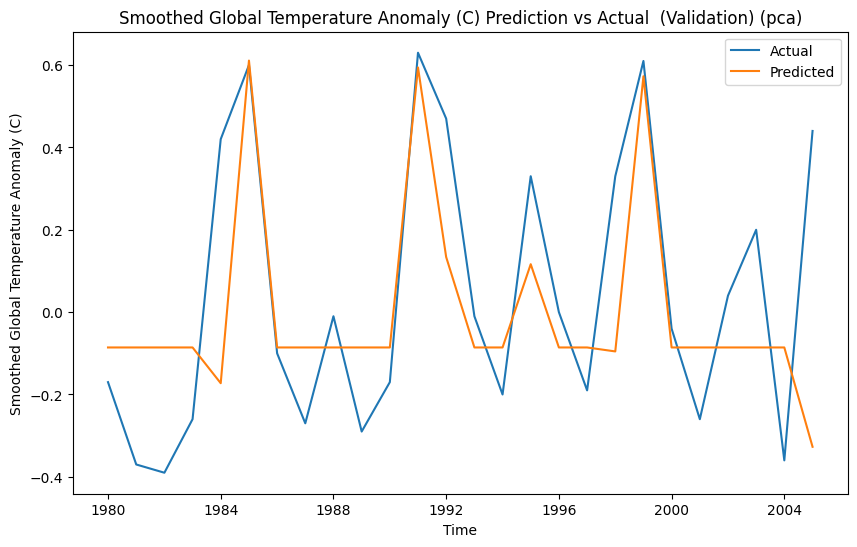

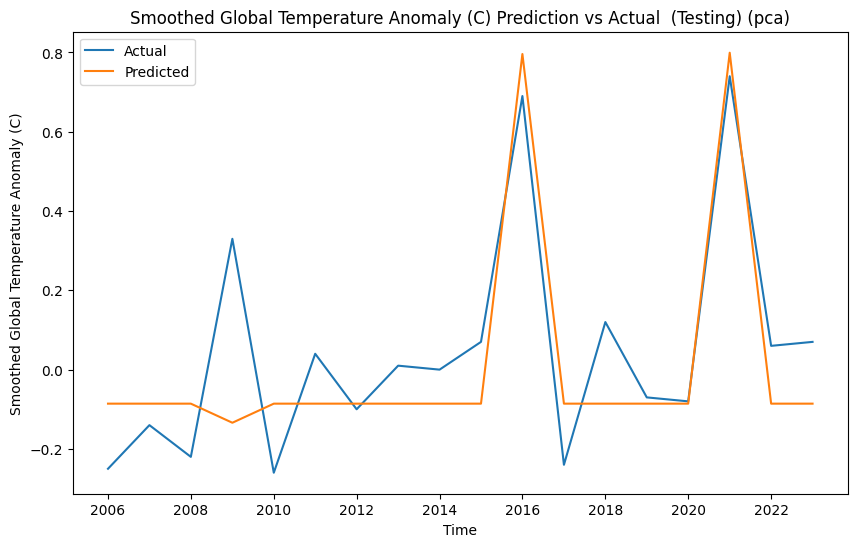

In [144]:
target = 'Smoothed Global Temperature Anomaly (C)'
results[target] = {}

info = train_linear(df_imputed, target, ridge_alpha=0.1, scaler=StandardScaler())
results[target]['all features'] = info

info = train_linear(df_imputed, target, ridge_alpha=0.1,
                    scaler=StandardScaler(), pca_selected_features=pca_selected_features)
results[target]['pca selected features'] = info

##### 5.2.1.3 Predicting Antarctic Ice Mass Lost Since 2002 (GT)

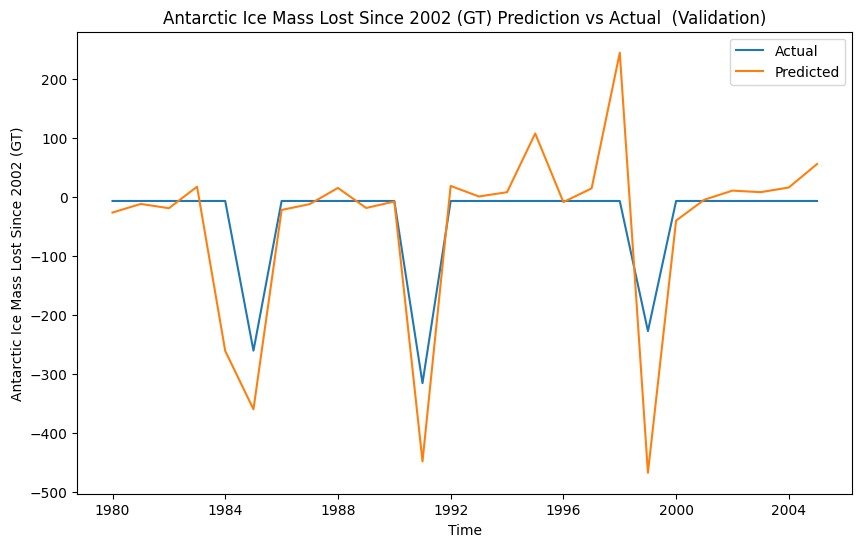

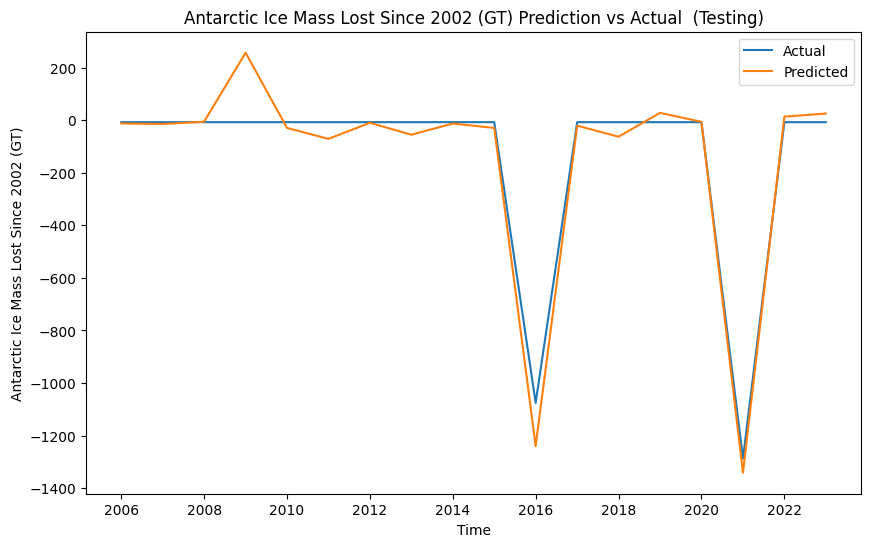

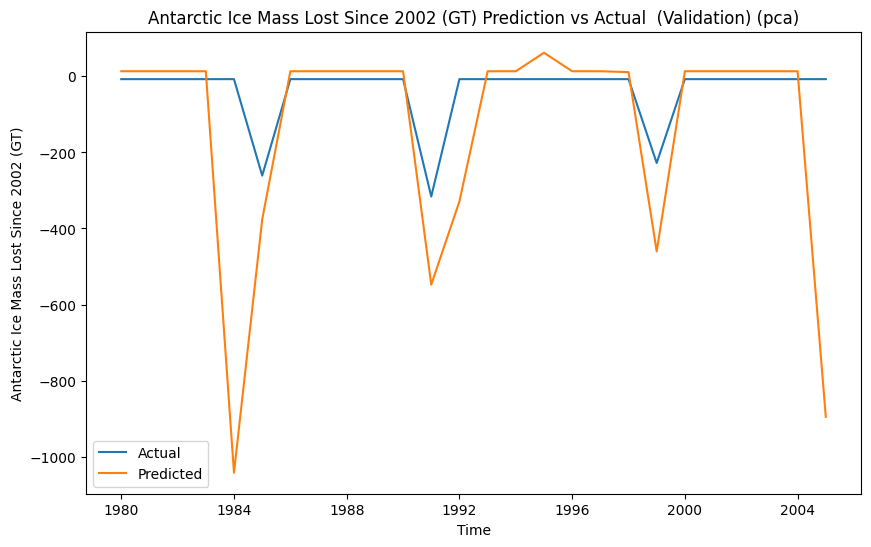

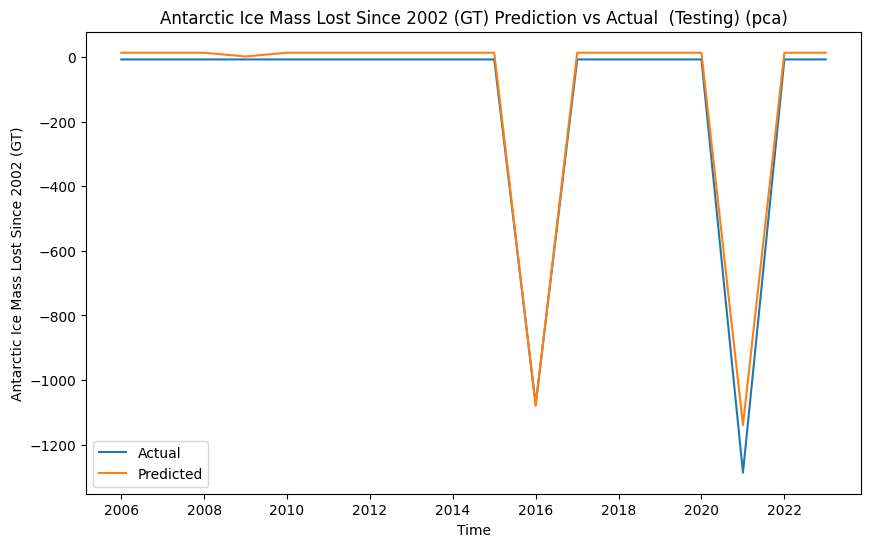

In [145]:
target = 'Antarctic Ice Mass Lost Since 2002 (GT)'
results[target] = {}

info = train_linear(df_imputed, target, ridge_alpha=0.1, scaler=StandardScaler())
results[target]['all features'] = info

info = train_linear(df_imputed, target, ridge_alpha=0.1,
                    scaler=StandardScaler(), pca_selected_features=pca_selected_features)
results[target]['pca selected features'] = info

##### 5.2.1.4 Predicting Antarctic Ice Mass Loss Uncertainty (STD 1, GT)

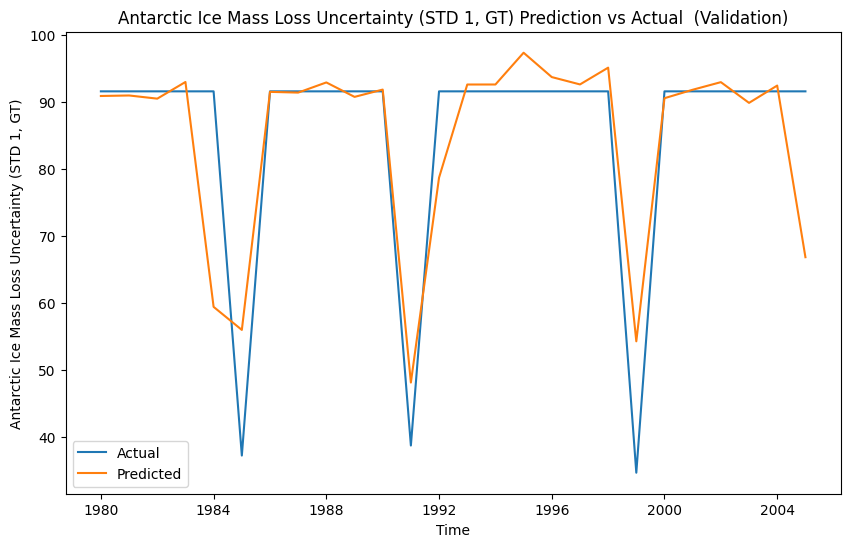

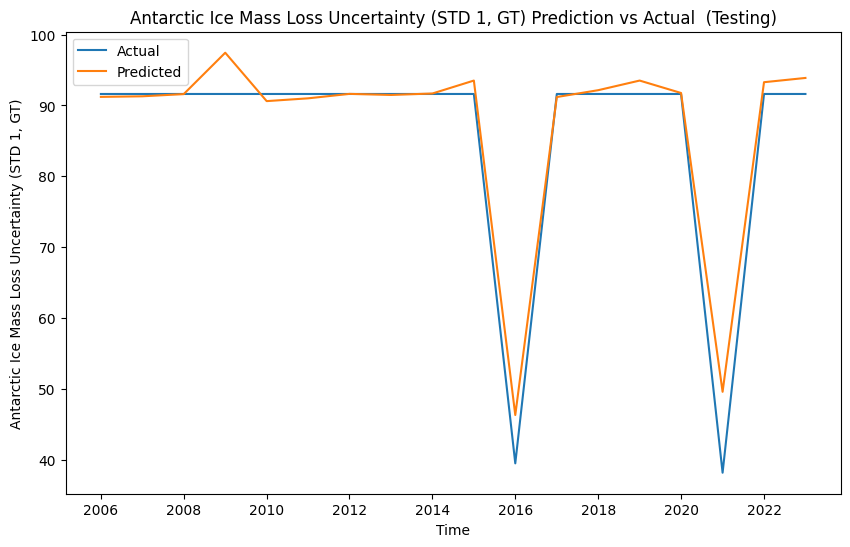

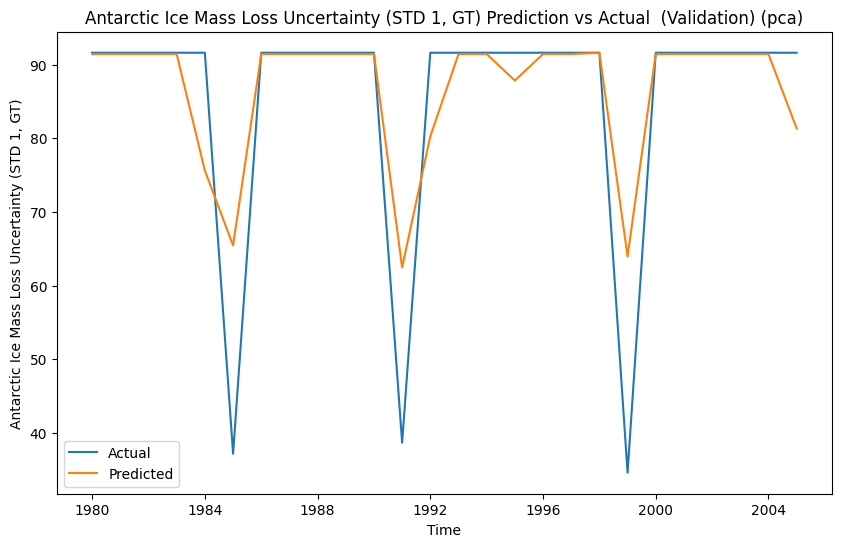

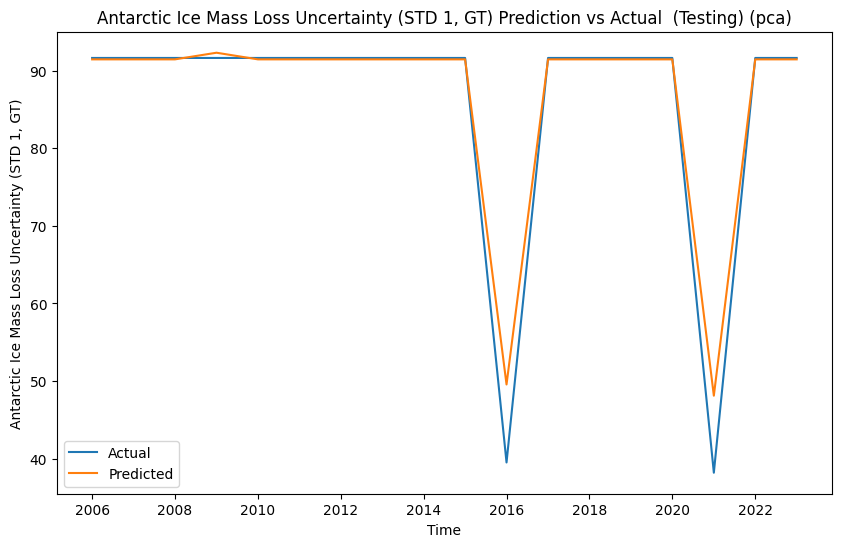

In [146]:
target = 'Antarctic Ice Mass Loss Uncertainty (STD 1, GT)'
results[target] = {}

info = train_linear(df_imputed, target, ridge_alpha=0.1, scaler=StandardScaler())
results[target]['all features'] = info

info = train_linear(df_imputed, target, ridge_alpha=0.1,
                    scaler=StandardScaler(), pca_selected_features=pca_selected_features)
results[target]['pca selected features'] = info

##### 5.2.1.5 Predicting Average Methane Level (PPB)

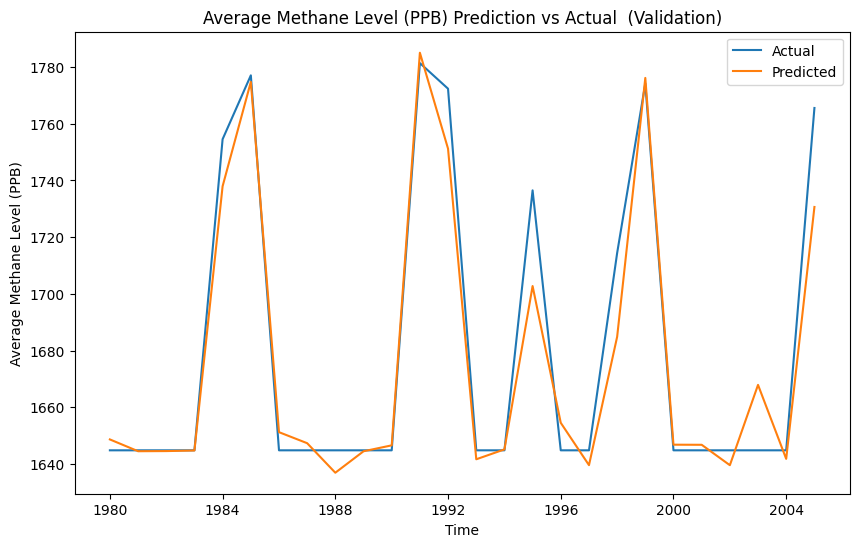

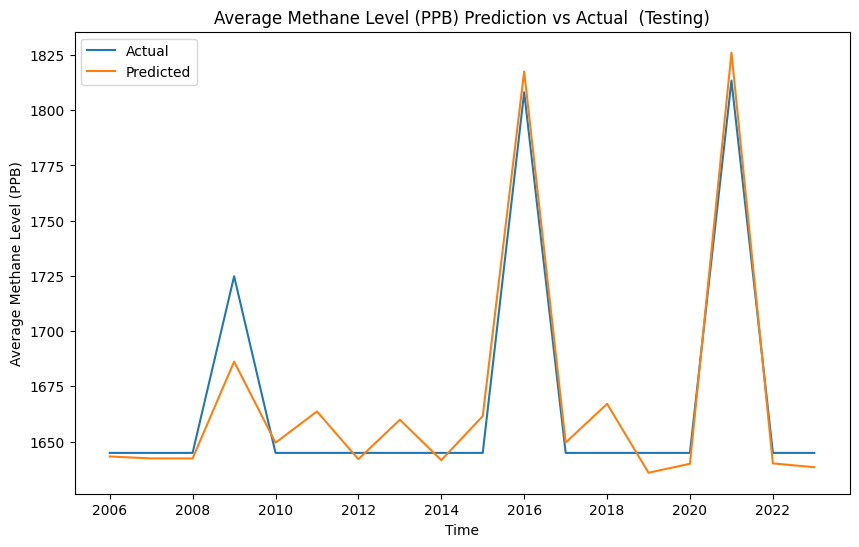

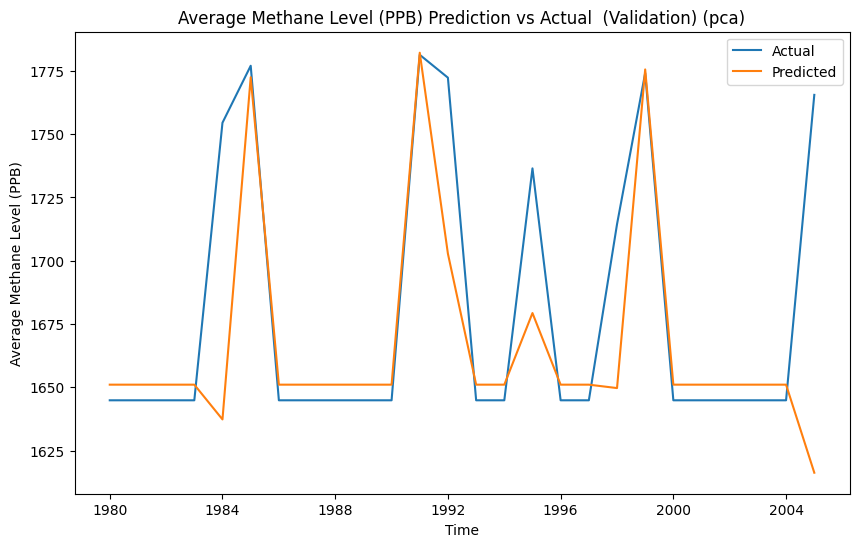

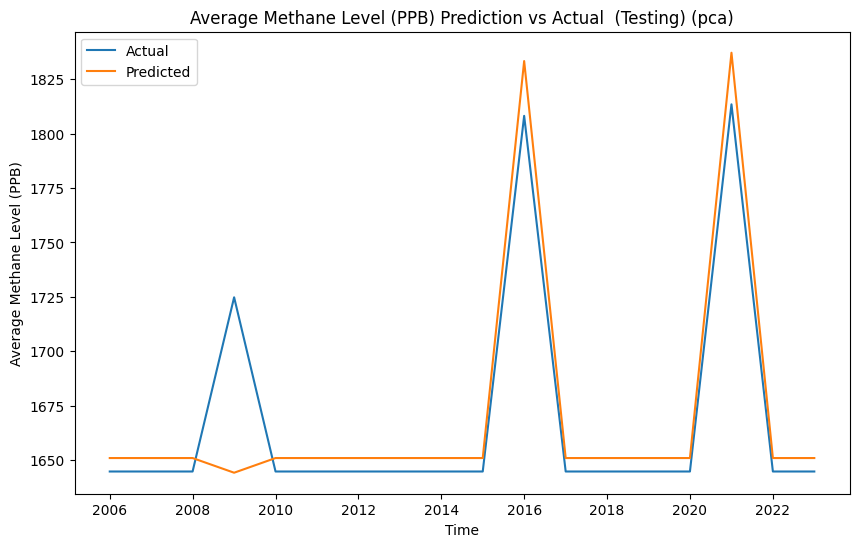

In [147]:
target = 'Average Methane Level (PPB)'
results[target] = {}

info = train_linear(df_imputed, target, ridge_alpha=0.1, scaler=StandardScaler())
results[target]['all features'] = info

info = train_linear(df_imputed, target, ridge_alpha=0.1,
                    scaler=StandardScaler(), pca_selected_features=pca_selected_features)
results[target]['pca selected features'] = info

##### 5.2.1.6 Predicting Methane Level Uncertainty (1 STD, PPB)

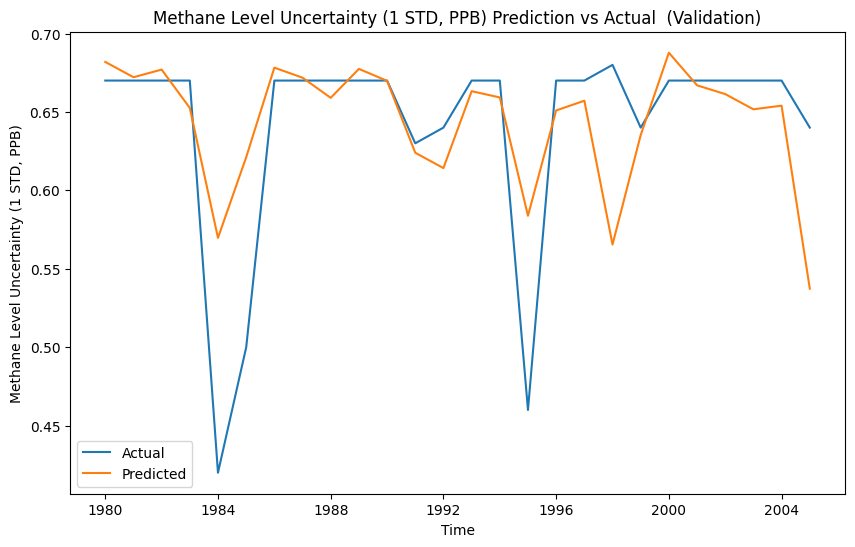

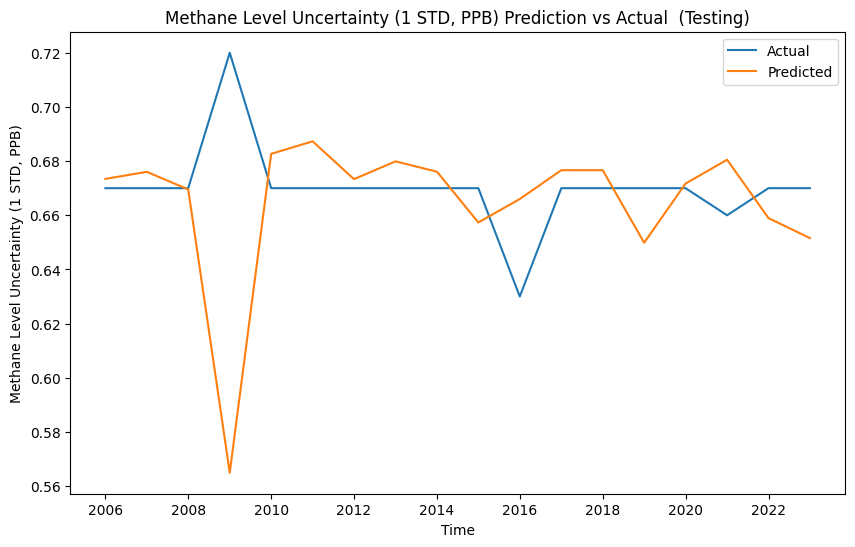

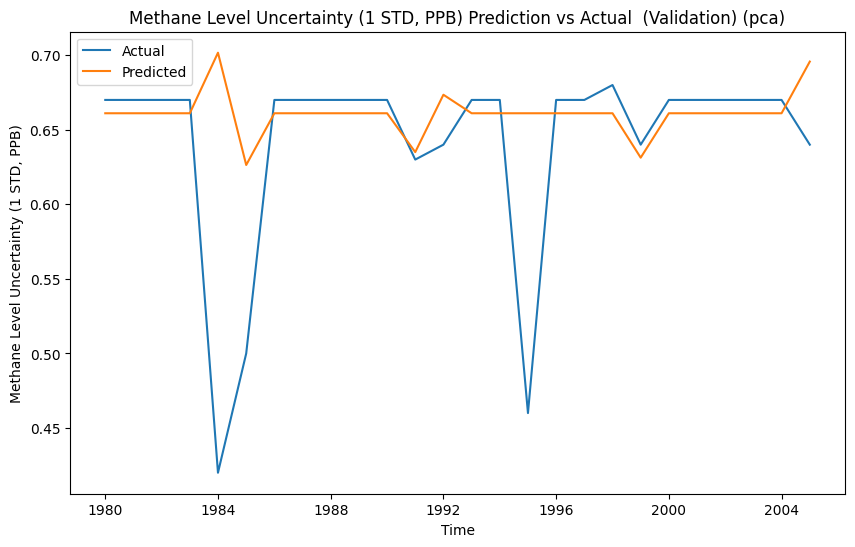

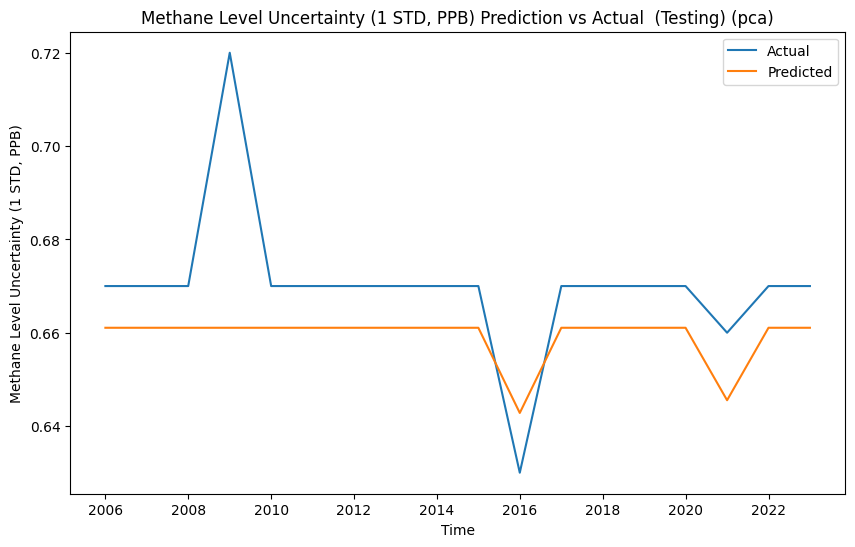

In [148]:
target = 'Methane Level Uncertainty (1 STD, PPB)'
results[target] = {}

info = train_linear(df_imputed, target, ridge_alpha=0.1, scaler=StandardScaler())
results[target]['all features'] = info

info = train_linear(df_imputed, target, ridge_alpha=0.1,
                    scaler=StandardScaler(), pca_selected_features=pca_selected_features)
results[target]['pca selected features'] = info

##### 5.2.1.7 Predicting Global Mean Sea Level (mm, No GIA)

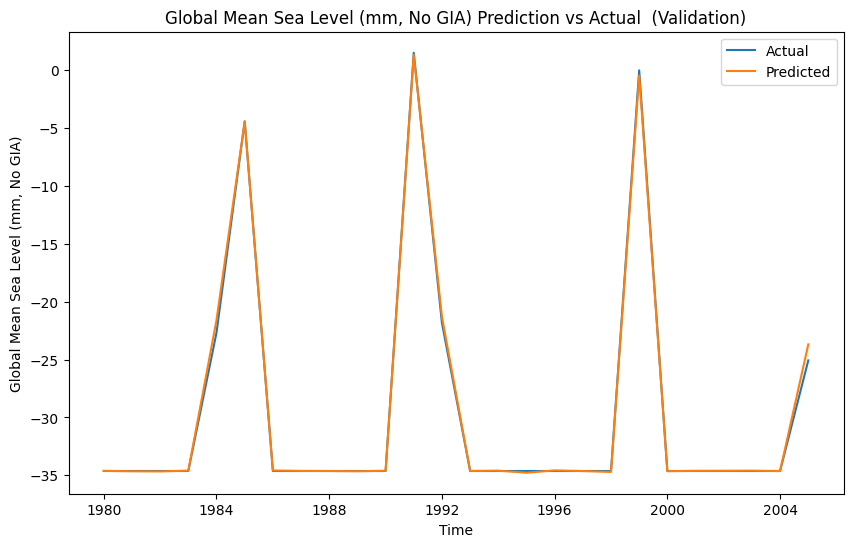

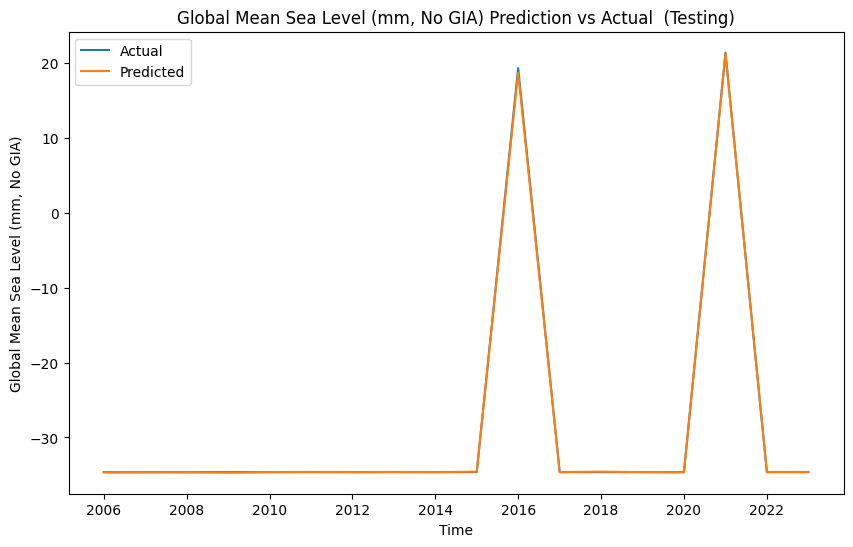

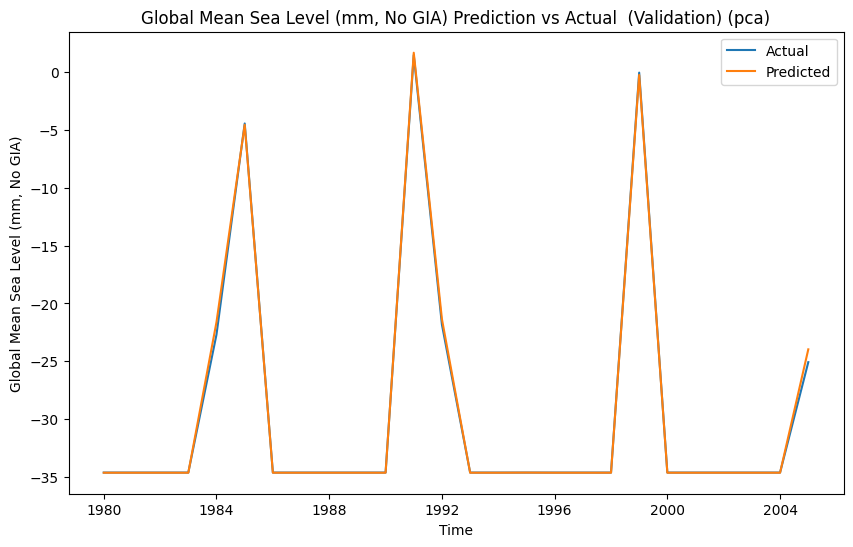

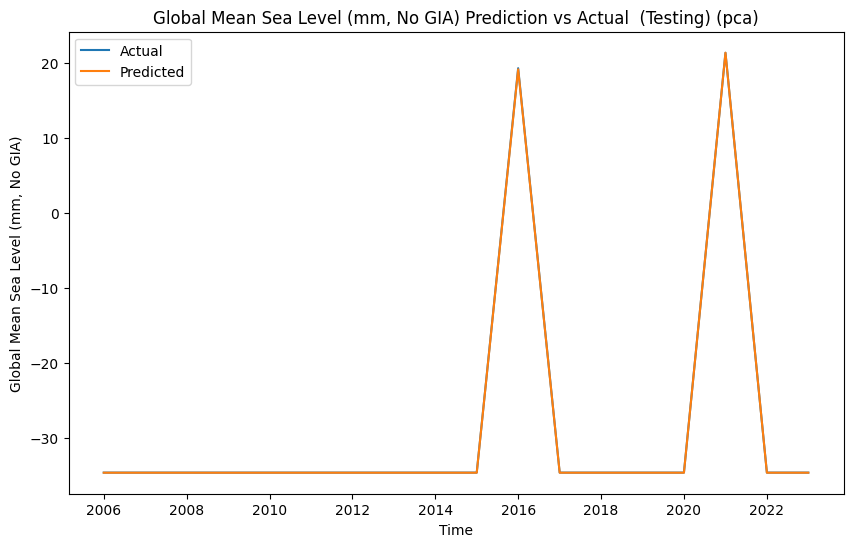

In [149]:
target = 'Global Mean Sea Level (mm, No GIA)'
results[target] = {}

info = train_linear(df_imputed, target, ridge_alpha=0.1, scaler=StandardScaler())
results[target]['all features'] = info

info = train_linear(df_imputed, target, ridge_alpha=0.1,
                    scaler=StandardScaler(), pca_selected_features=pca_selected_features)
results[target]['pca selected features'] = info

##### 5.2.1.8 Predicting Standard Deviation of GMSL (mm, No GIA)

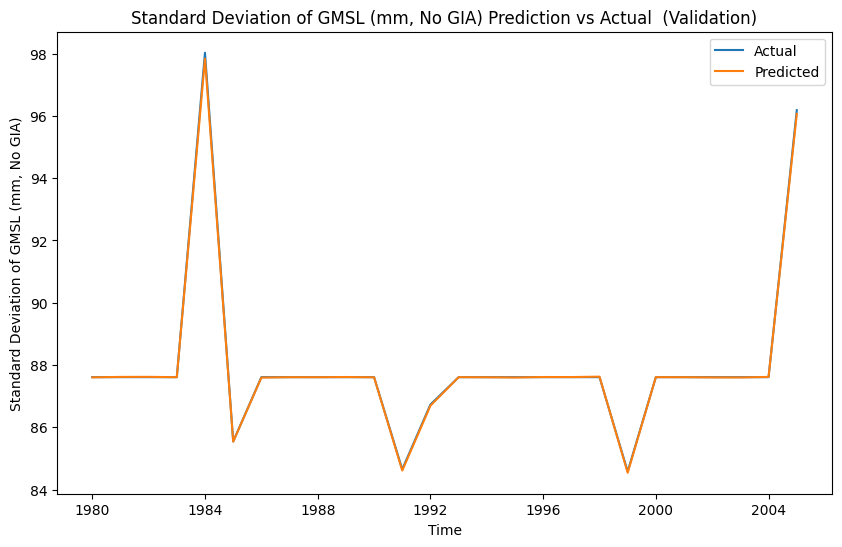

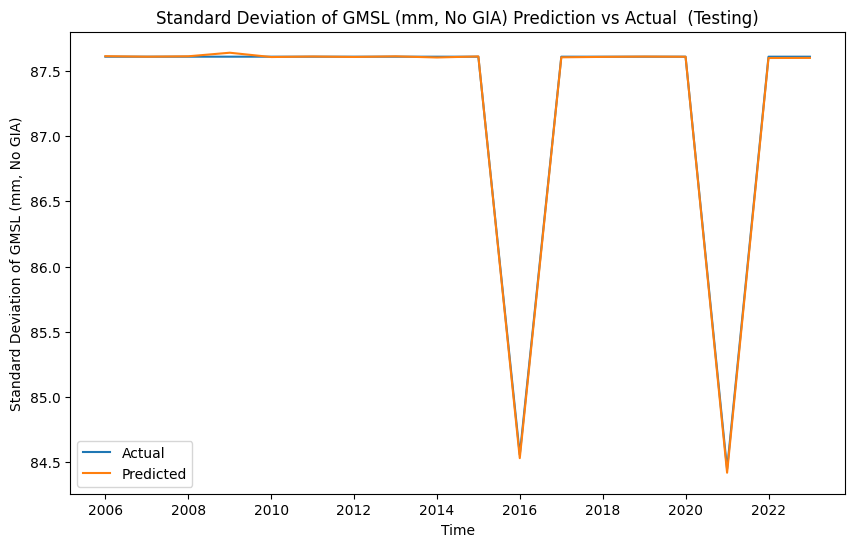

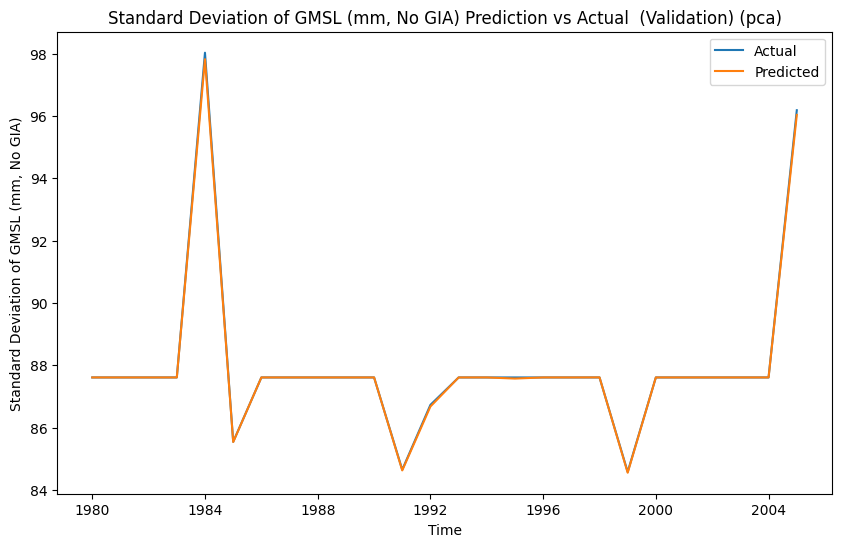

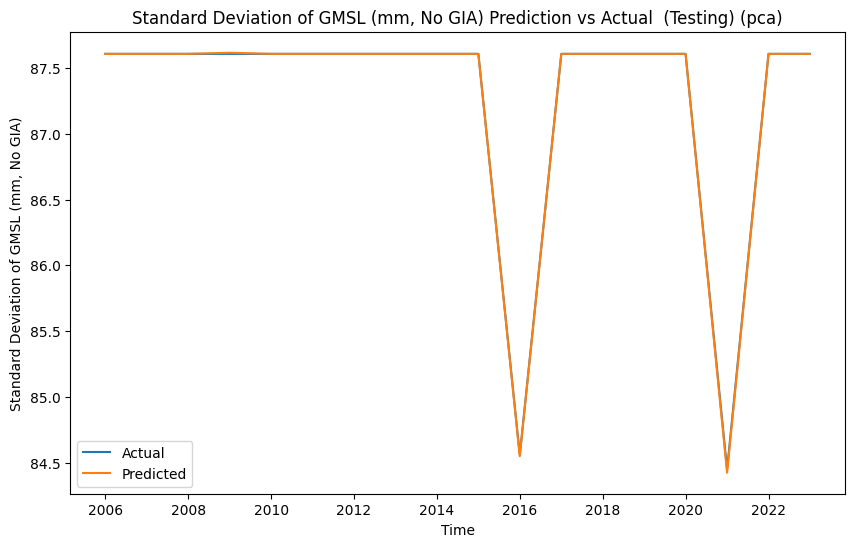

In [150]:
target = 'Standard Deviation of GMSL (mm, No GIA)'
results[target] = {}

info = train_linear(df_imputed, target, ridge_alpha=0.1, scaler=StandardScaler())
results[target]['all features'] = info

info = train_linear(df_imputed, target, ridge_alpha=0.1,
                    scaler=StandardScaler(), pca_selected_features=pca_selected_features)
results[target]['pca selected features'] = info

##### 5.2.1.9 Predicting Smoothed GMSL (No GIA)

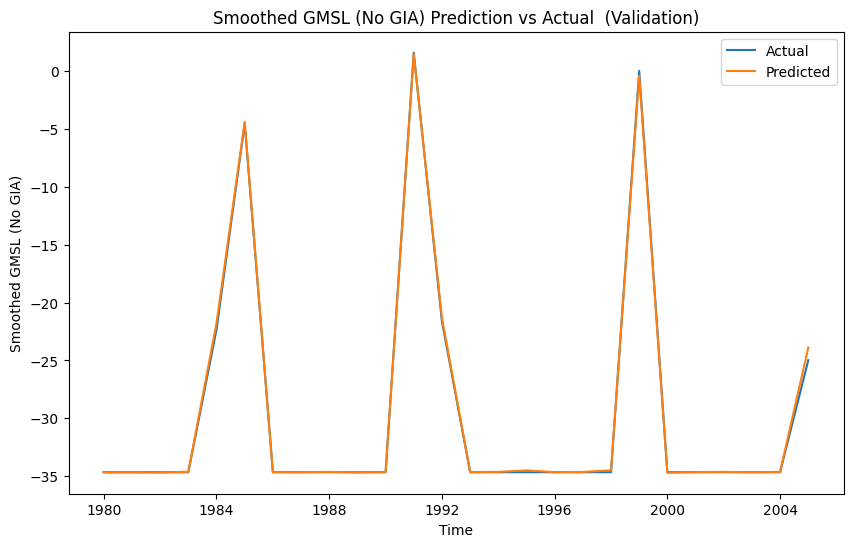

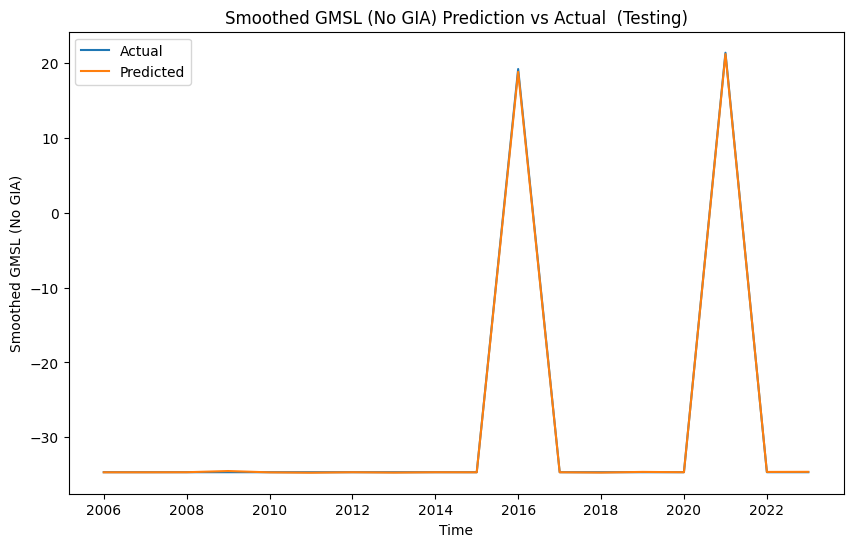

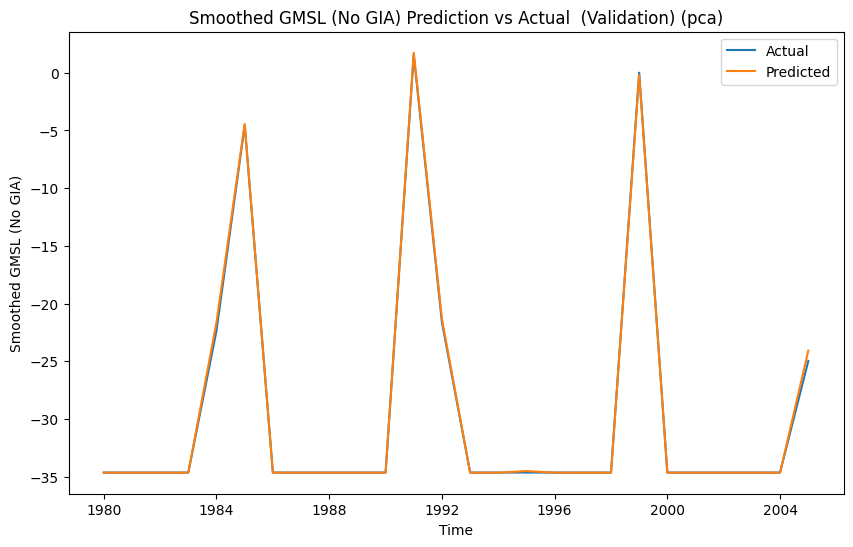

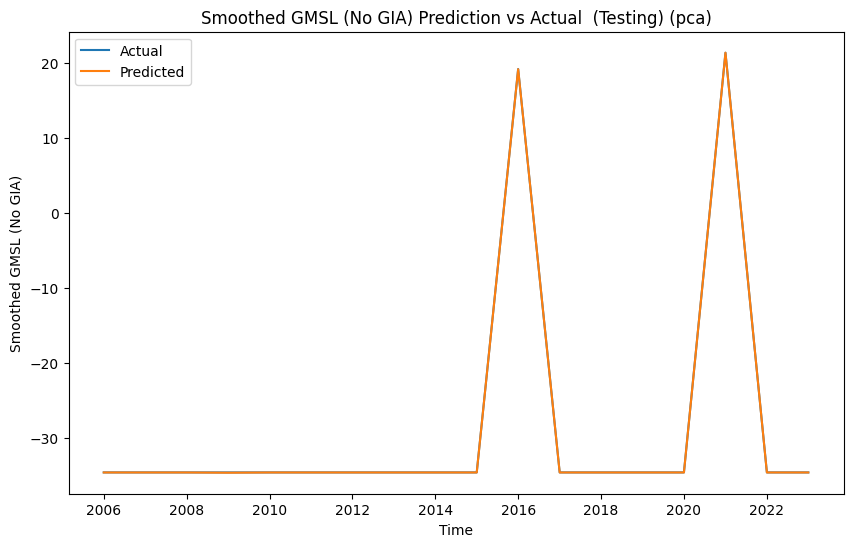

In [151]:
target = 'Smoothed GMSL (No GIA)'
results[target] = {}

info = train_linear(df_imputed, target, ridge_alpha=0.1, scaler=StandardScaler())
results[target]['all features'] = info

info = train_linear(df_imputed, target, ridge_alpha=0.1,
                    scaler=StandardScaler(), pca_selected_features=pca_selected_features)
results[target]['pca selected features'] = info

##### 5.2.1.10 Predicting Global Mean Sea Level (mm, With GIA)

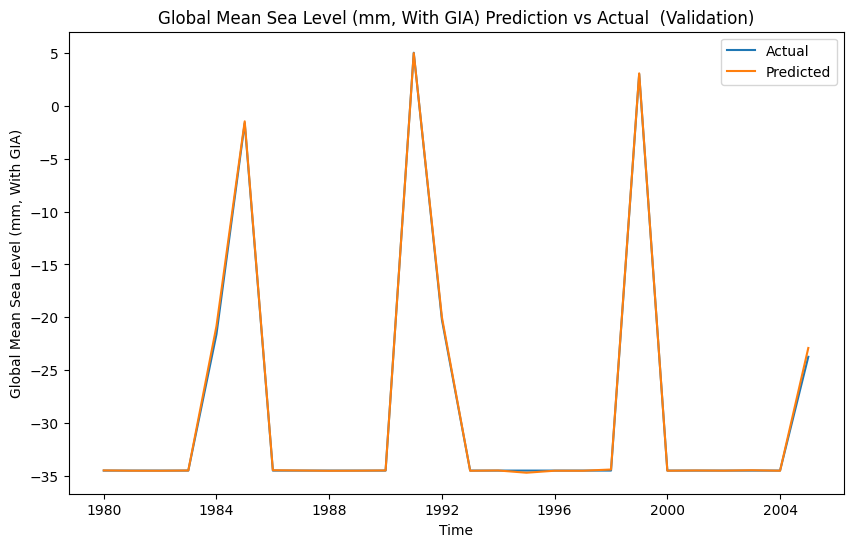

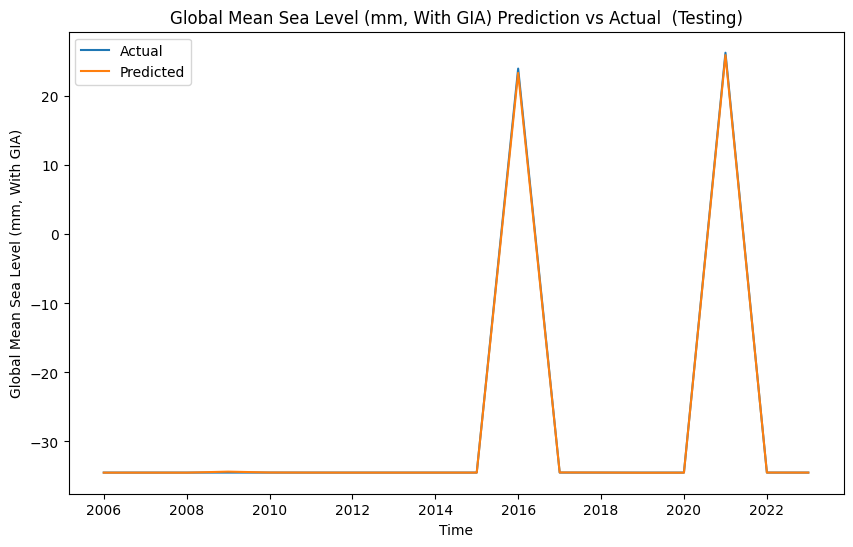

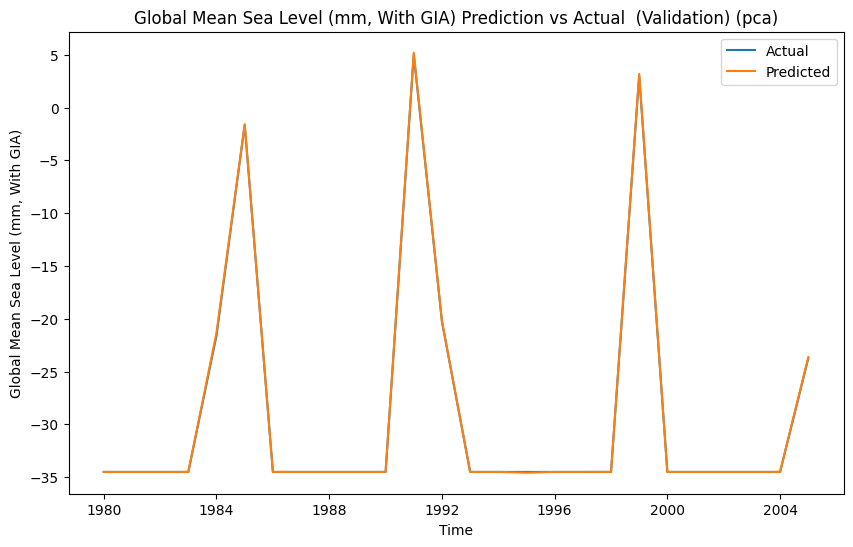

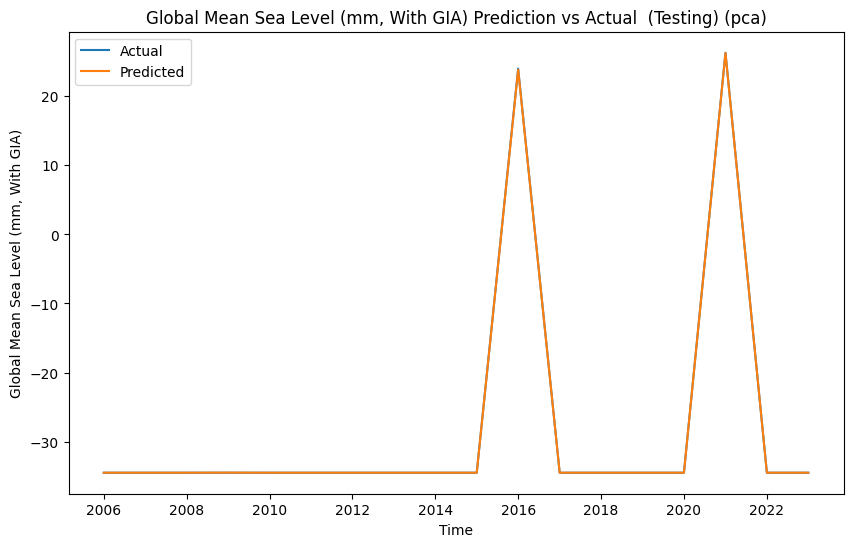

In [152]:
target = 'Global Mean Sea Level (mm, With GIA)'
results[target] = {}

info = train_linear(df_imputed, target, ridge_alpha=0.1, scaler=StandardScaler())
results[target]['all features'] = info

info = train_linear(df_imputed, target, ridge_alpha=0.1,
                    scaler=StandardScaler(), pca_selected_features=pca_selected_features)
results[target]['pca selected features'] = info

##### 5.2.1.11 Predicting Standard Deviation of GMSL (mm, With GIA)

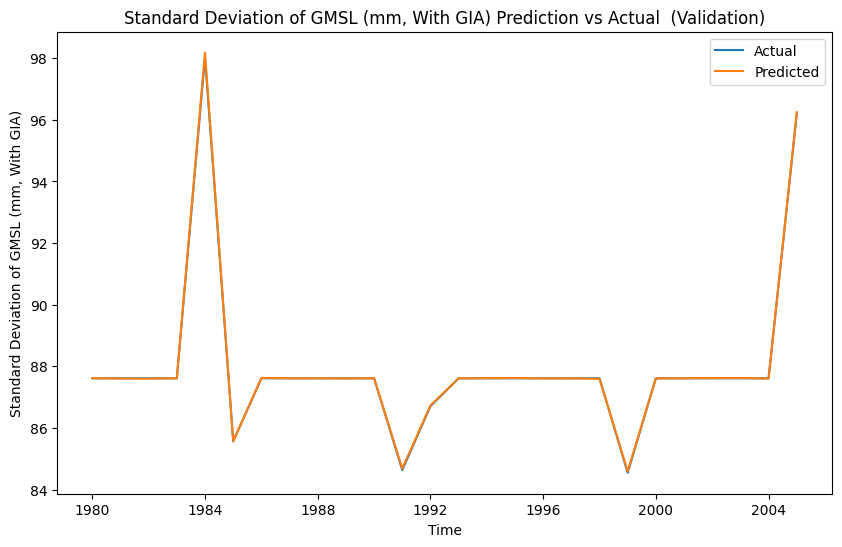

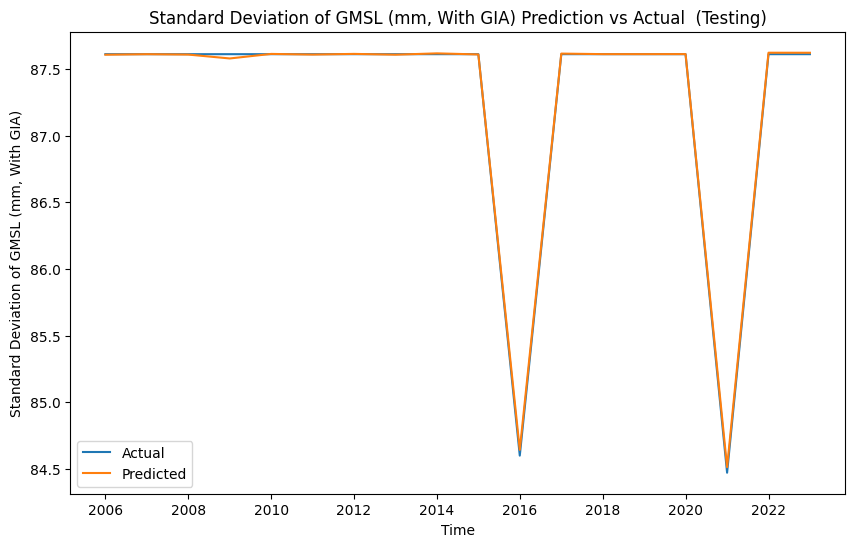

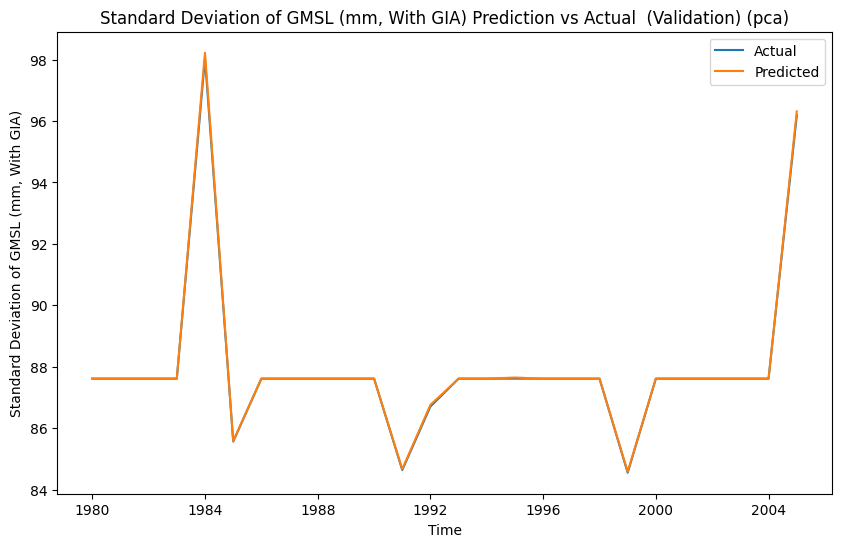

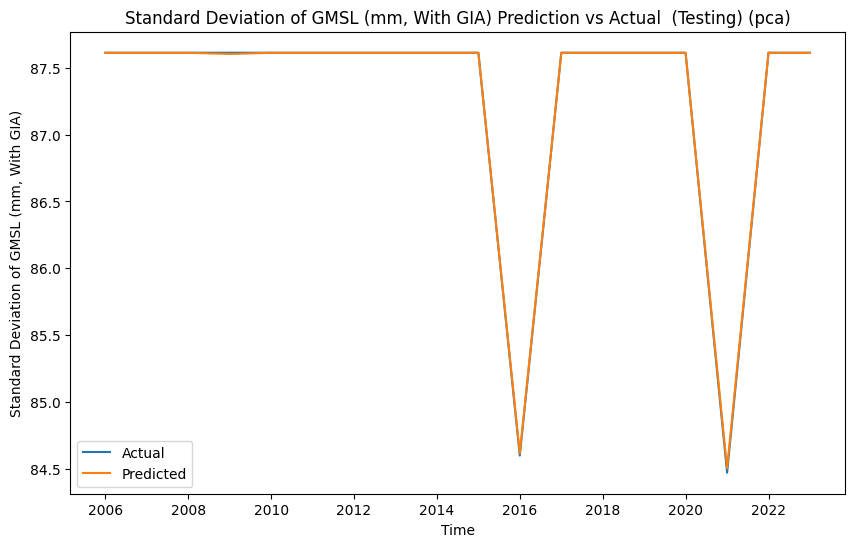

In [153]:
target = 'Standard Deviation of GMSL (mm, With GIA)'
results[target] = {}

info = train_linear(df_imputed, target, ridge_alpha=0.1, scaler=StandardScaler())
results[target]['all features'] = info

info = train_linear(df_imputed, target, ridge_alpha=0.1,
                    scaler=StandardScaler(), pca_selected_features=pca_selected_features)
results[target]['pca selected features'] = info

##### 5.2.1.12 Predicting Smoothed GMSL (With GIA)

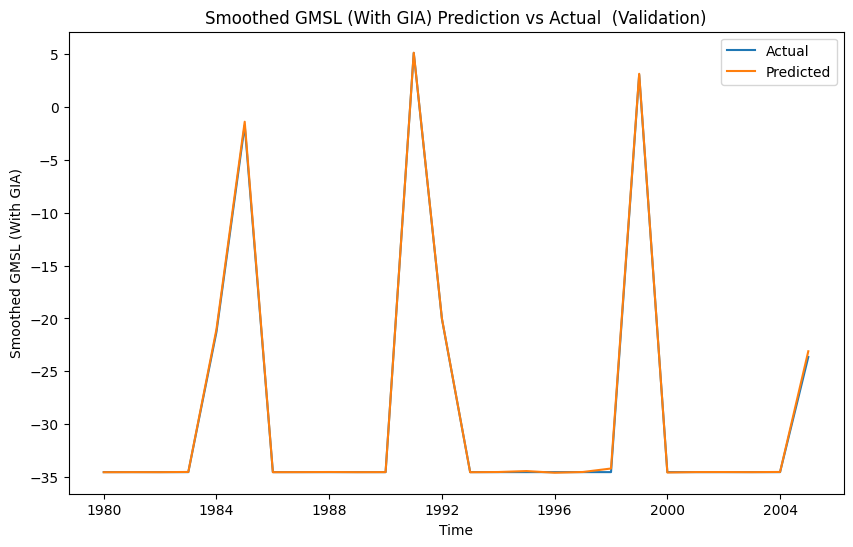

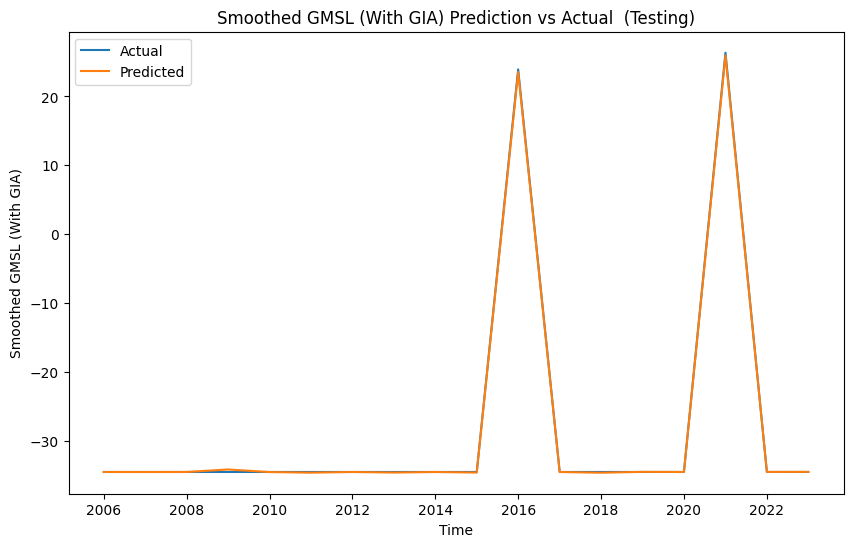

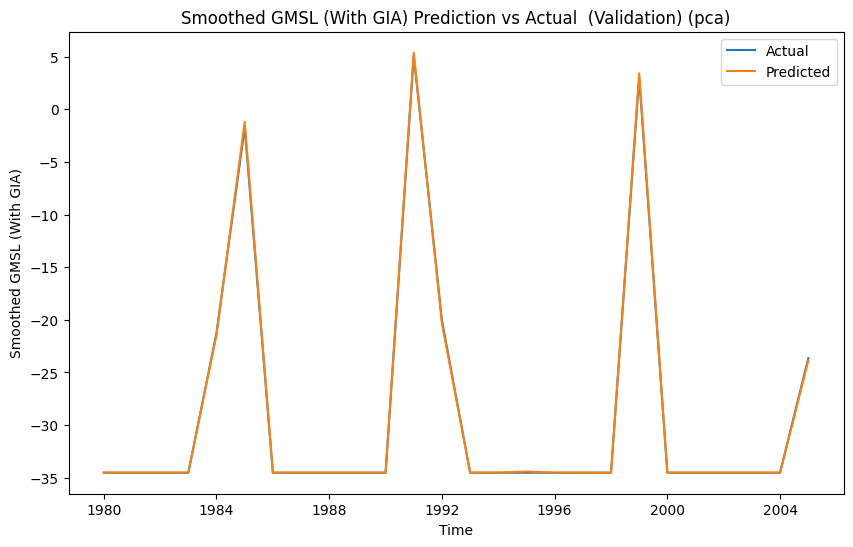

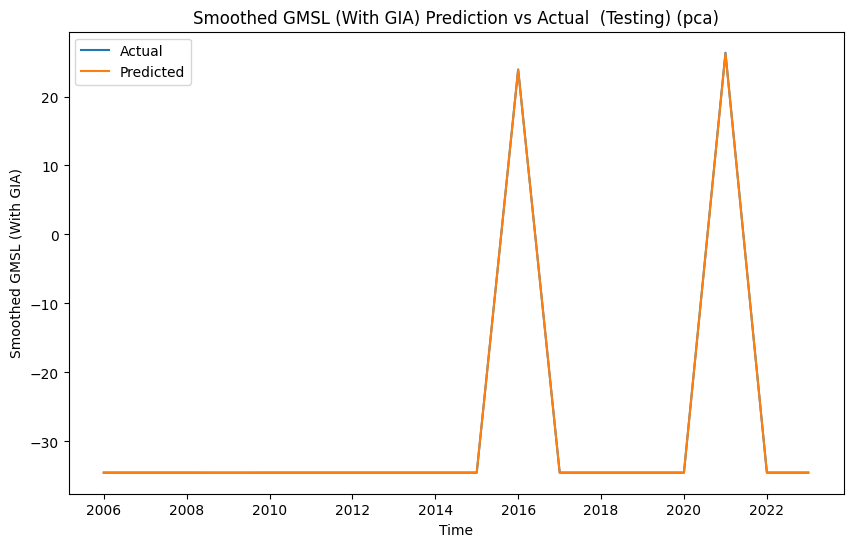

In [154]:
target = 'Smoothed GMSL (With GIA)'
results[target] = {}

info = train_linear(df_imputed, target, ridge_alpha=0.1, scaler=StandardScaler())
results[target]['all features'] = info

info = train_linear(df_imputed, target, ridge_alpha=0.1,
                    scaler=StandardScaler(), pca_selected_features=pca_selected_features)
results[target]['pca selected features'] = info

##### 5.2.1.13 Predicting Smoothed GMSL Annual/Semi-Annual Removed (mm, With GIA)

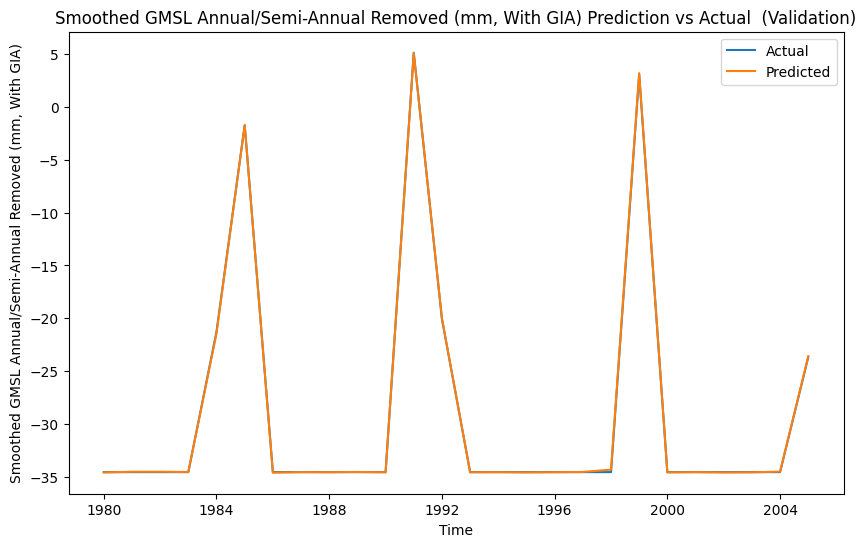

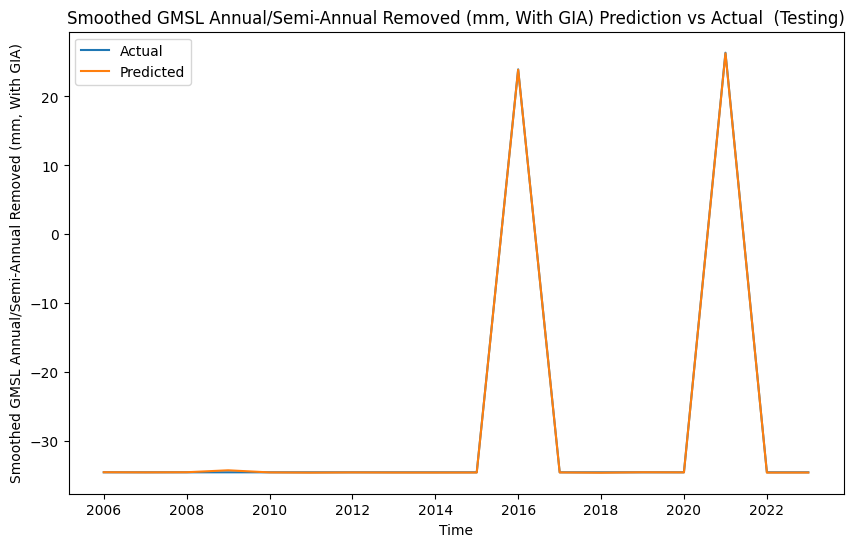

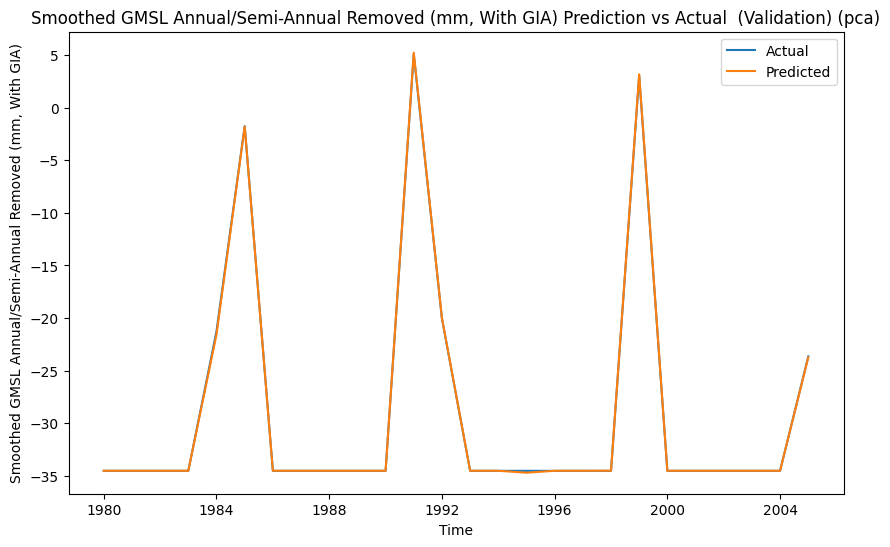

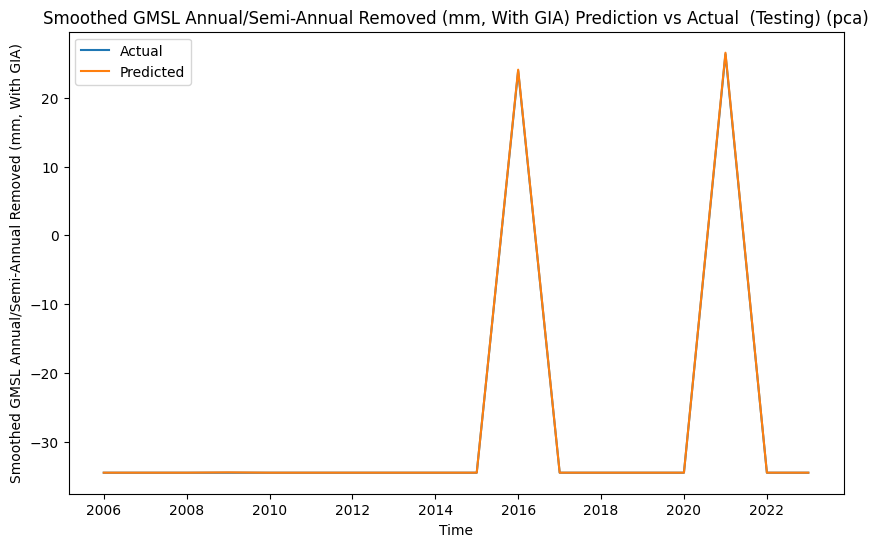

In [155]:
target = 'Smoothed GMSL Annual/Semi-Annual Removed (mm, With GIA)'
results[target] = {}

info = train_linear(df_imputed, target, ridge_alpha=0.1, scaler=StandardScaler())
results[target]['all features'] = info

info = train_linear(df_imputed, target, ridge_alpha=0.1,
                    scaler=StandardScaler(), pca_selected_features=pca_selected_features)
results[target]['pca selected features'] = info

##### 5.2.1.14 Predicting Smoothed GMSL Annual/Semi-Annual Removed (mm, No GIA)

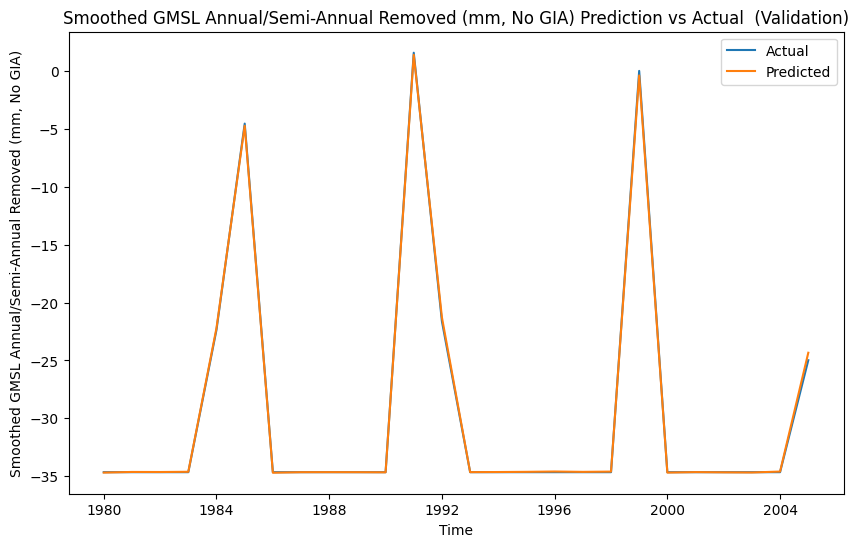

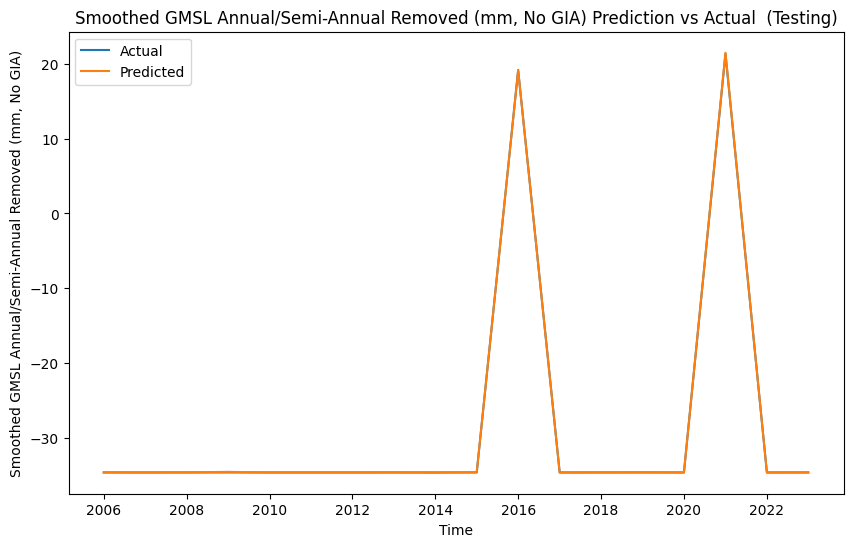

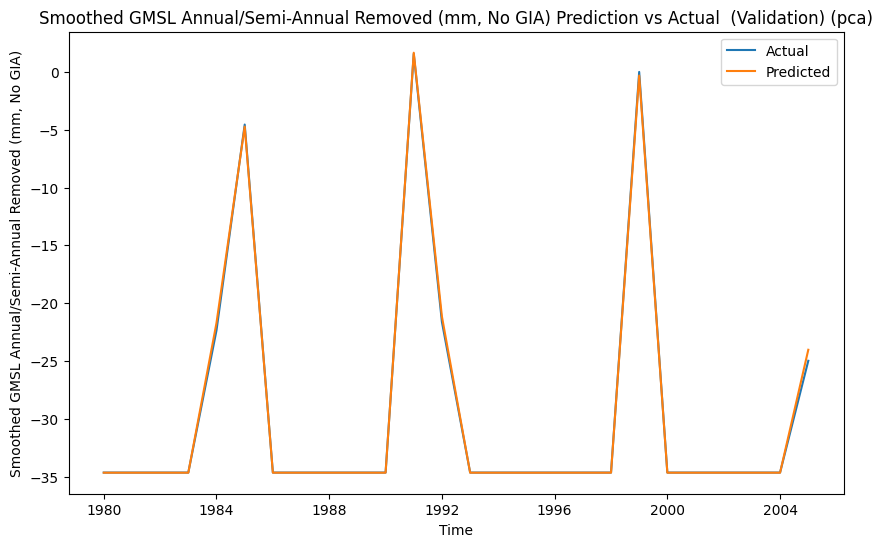

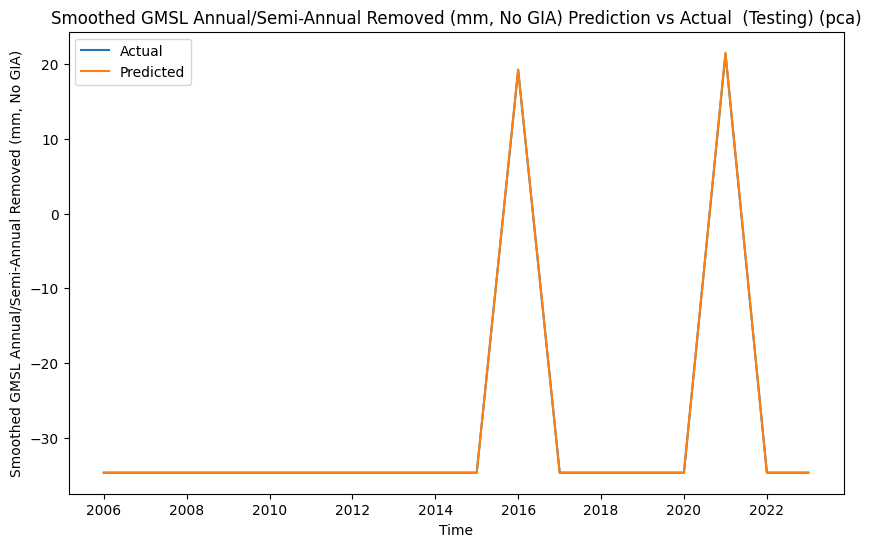

In [156]:
target = 'Smoothed GMSL Annual/Semi-Annual Removed (mm, No GIA)'
results[target] = {}

info = train_linear(df_imputed, target, ridge_alpha=0.1, scaler=StandardScaler())
results[target]['all features'] = info

info = train_linear(df_imputed, target, ridge_alpha=0.1,
                    scaler=StandardScaler(), pca_selected_features=pca_selected_features)
results[target]['pca selected features'] = info

##### 5.2.1.15 Predicting Ocean Warming (ZJ)

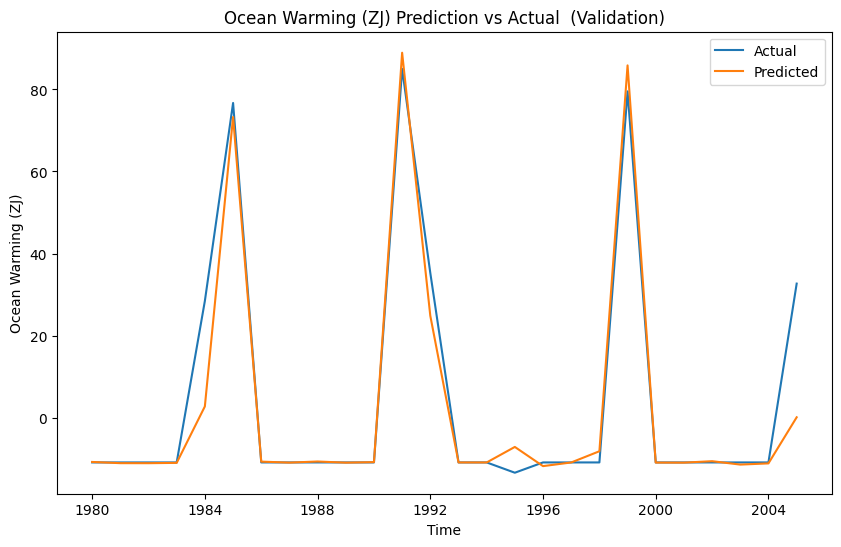

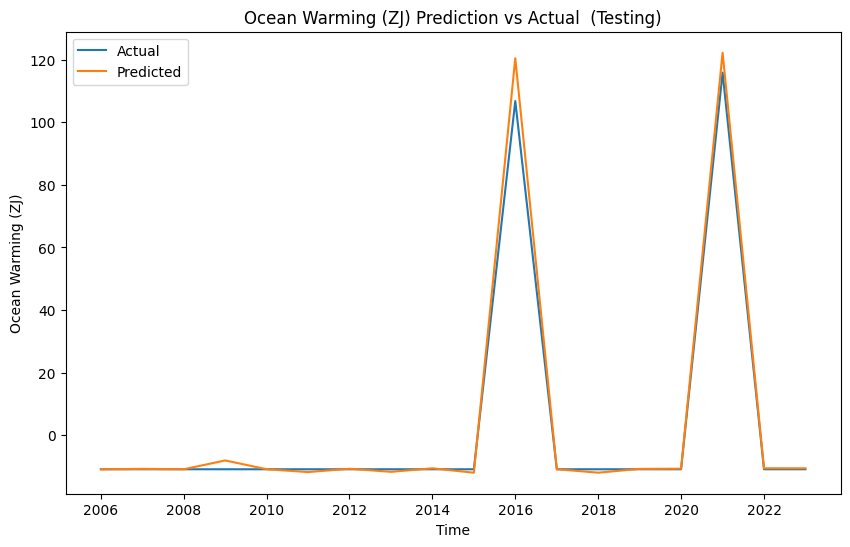

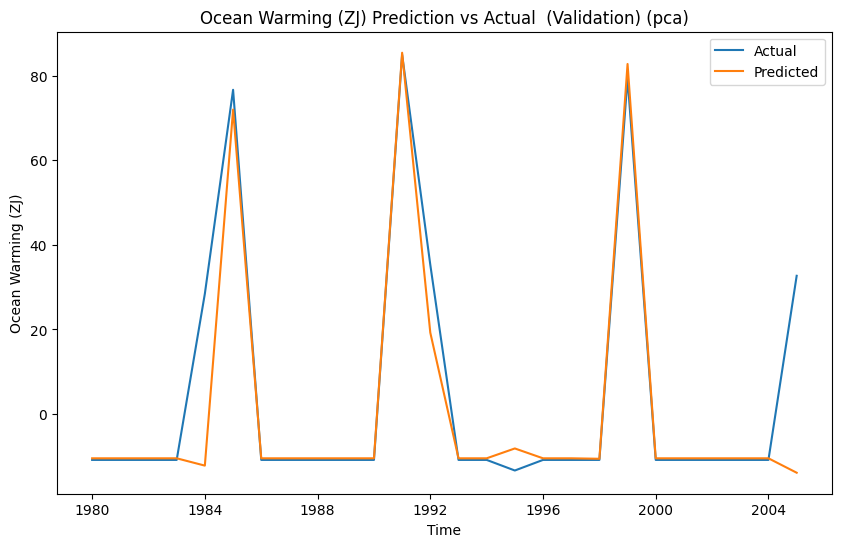

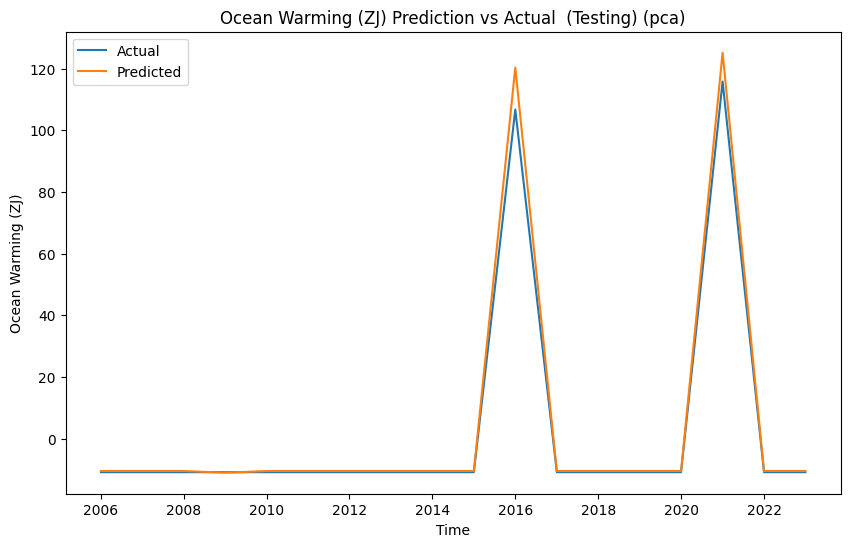

In [157]:
target = 'Ocean Warming (ZJ)'
results[target] = {}

info = train_linear(df_imputed, target, ridge_alpha=0.1, scaler=StandardScaler())
results[target]['all features'] = info

info = train_linear(df_imputed, target, ridge_alpha=0.1,
                    scaler=StandardScaler(), pca_selected_features=pca_selected_features)
results[target]['pca selected features'] = info

##### 5.2.1.16 Predicting Arctic Sea Ice Extent (Millions of KM^2)

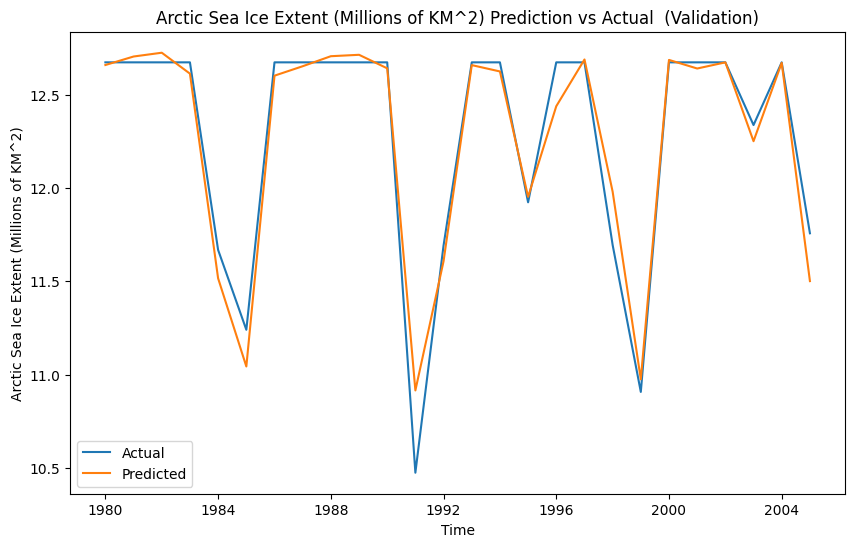

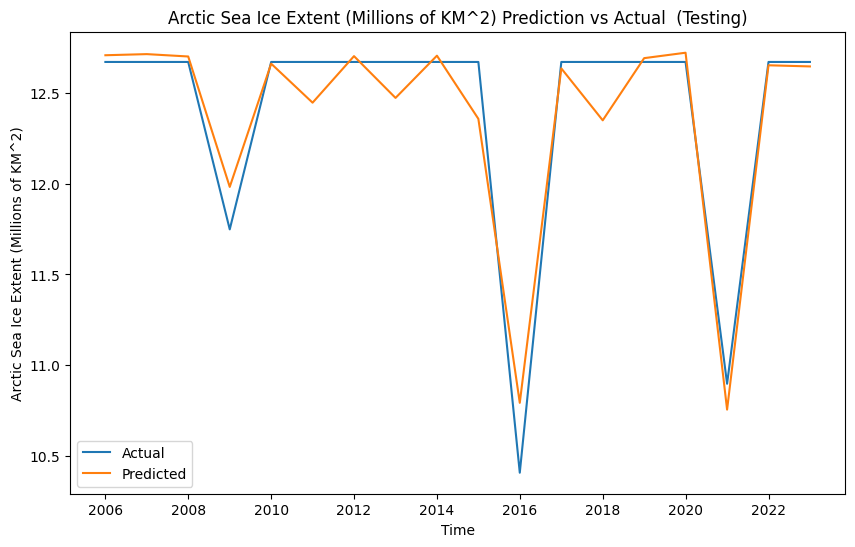

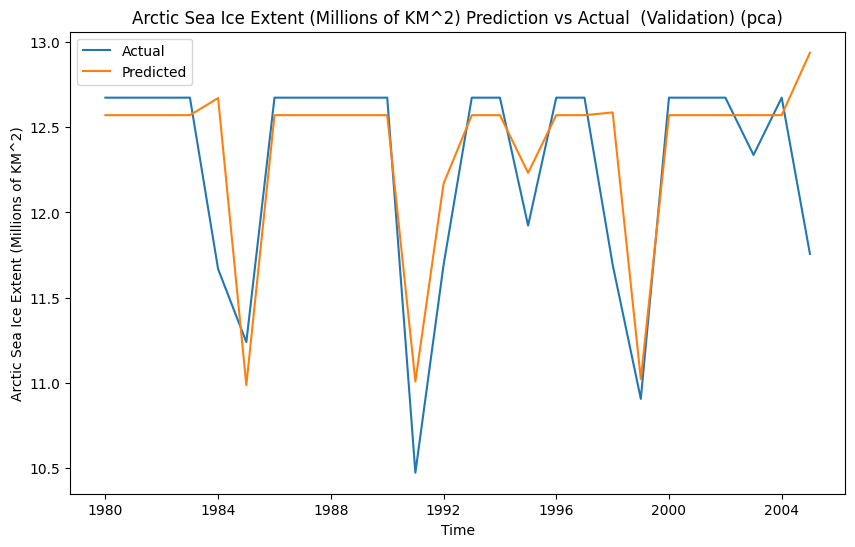

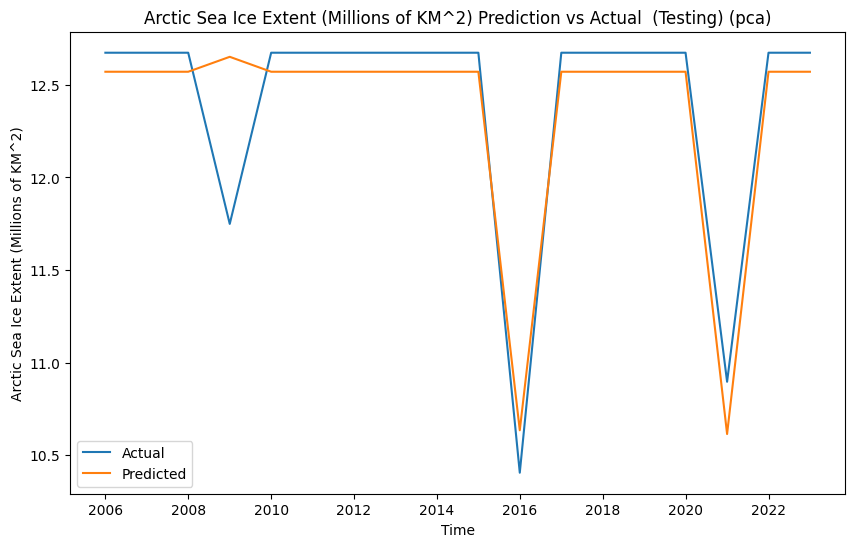

In [158]:
target = 'Arctic Sea Ice Extent (Millions of KM^2)'
results[target] = {}

info = train_linear(df_imputed, target, ridge_alpha=0.1, scaler=StandardScaler())
results[target]['all features'] = info

info = train_linear(df_imputed, target, ridge_alpha=0.1,
                    scaler=StandardScaler(), pca_selected_features=pca_selected_features)
results[target]['pca selected features'] = info

##### 5.2.1.17 Predicting CO2 Average Level (PPM)

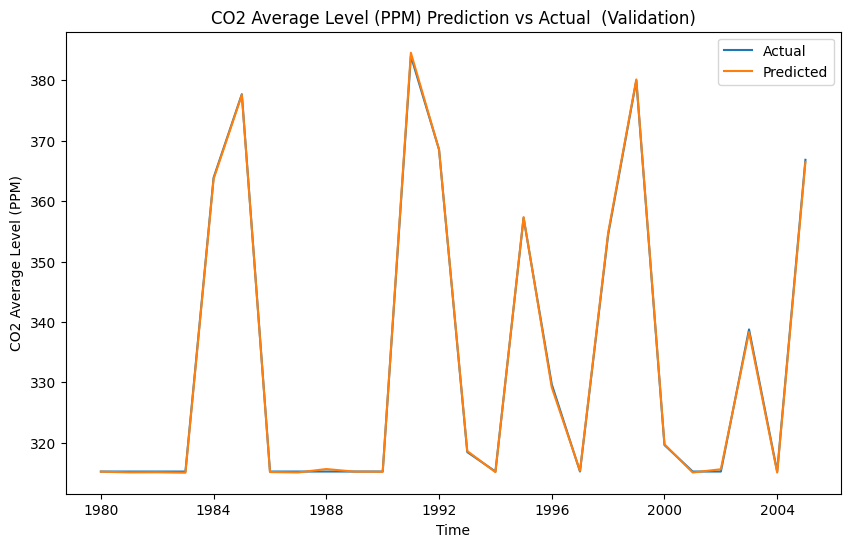

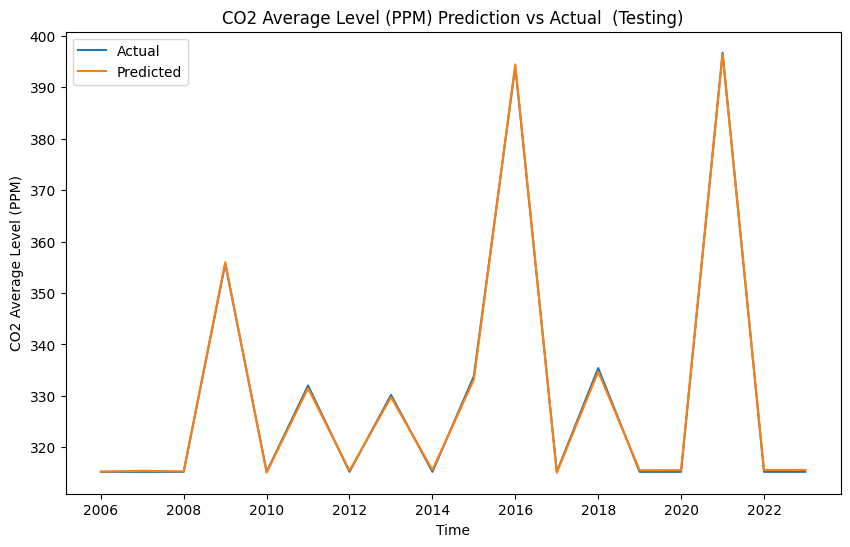

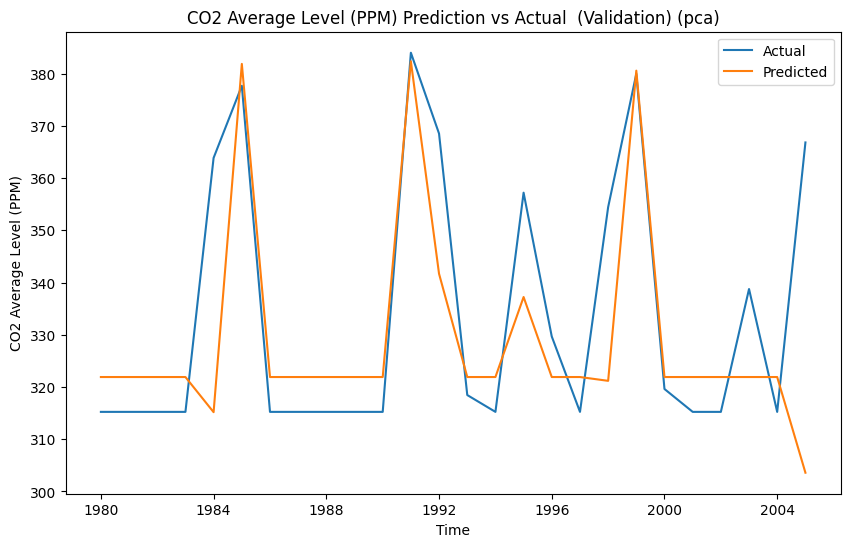

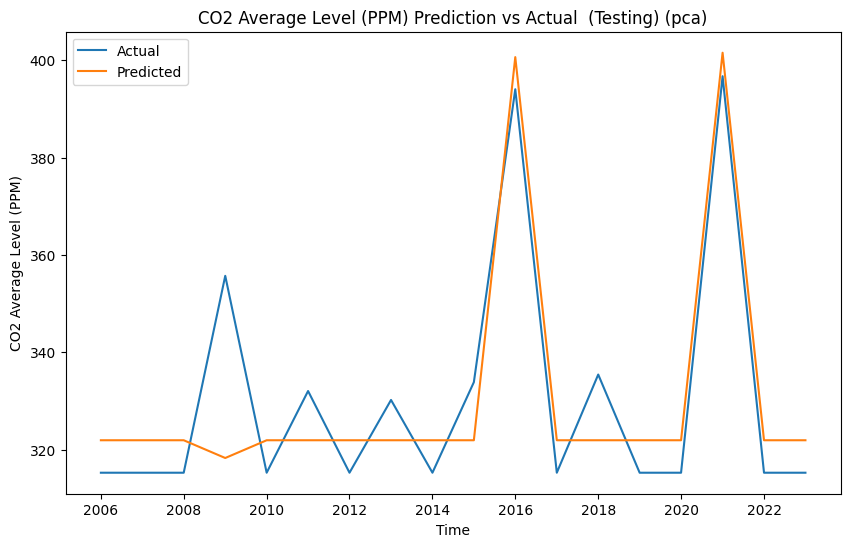

In [159]:
target = 'CO2 Average Level (PPM)'
results[target] = {}

info = train_linear(df_imputed, target, ridge_alpha=0.1, scaler=StandardScaler())
results[target]['all features'] = info

info = train_linear(df_imputed, target, ridge_alpha=0.1,
                    scaler=StandardScaler(), pca_selected_features=pca_selected_features)
results[target]['pca selected features'] = info

##### 5.2.1.18 Predicting CO2 Average Level De-Seasonalized (PPM)

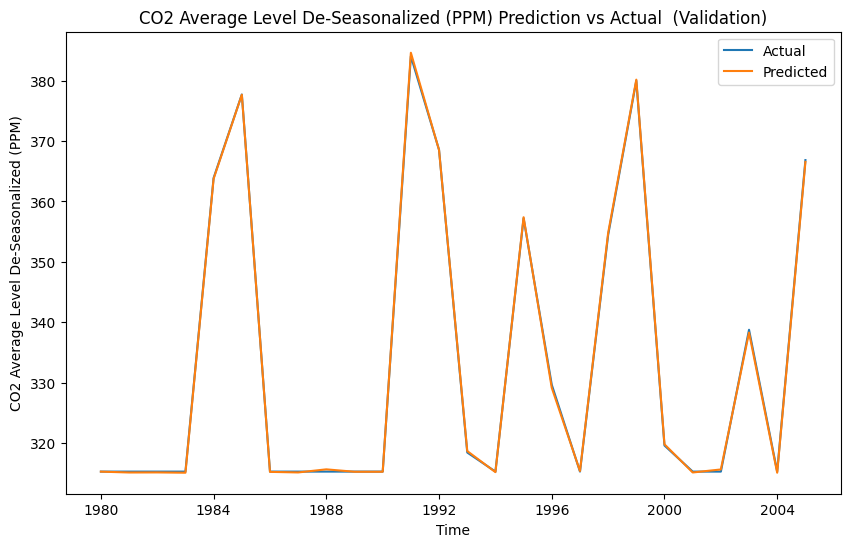

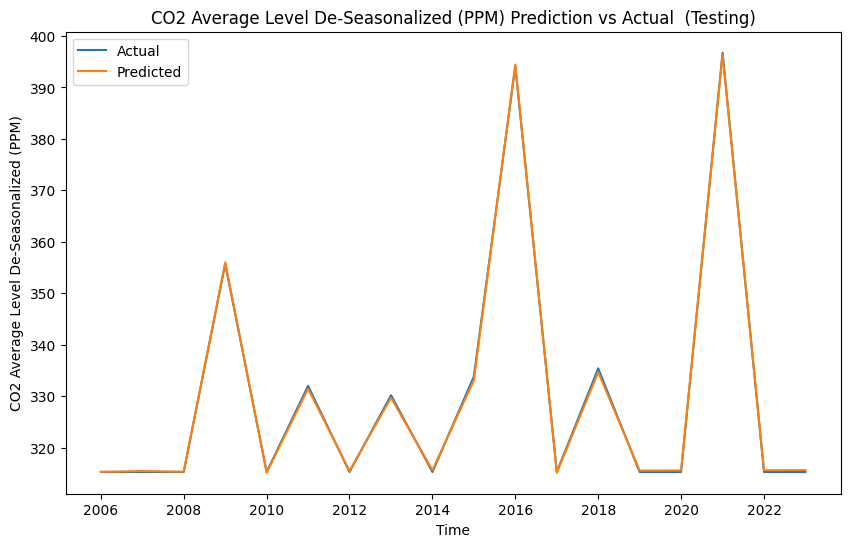

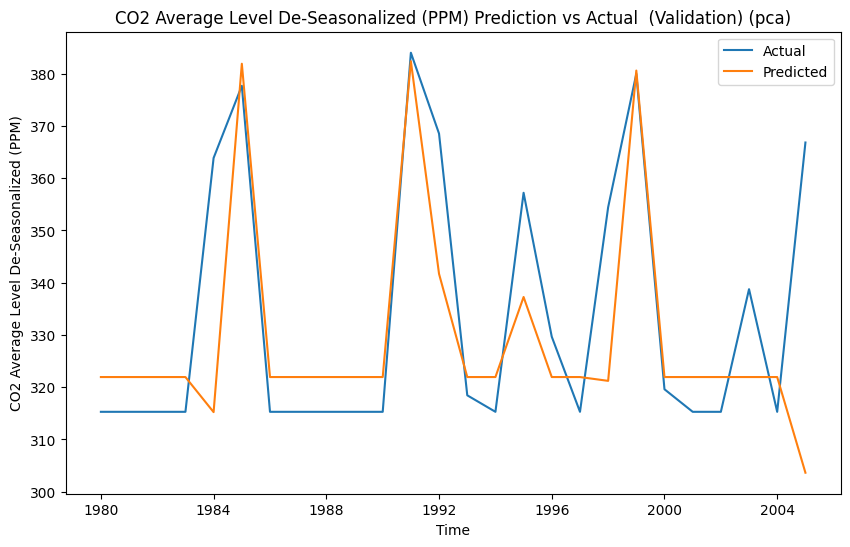

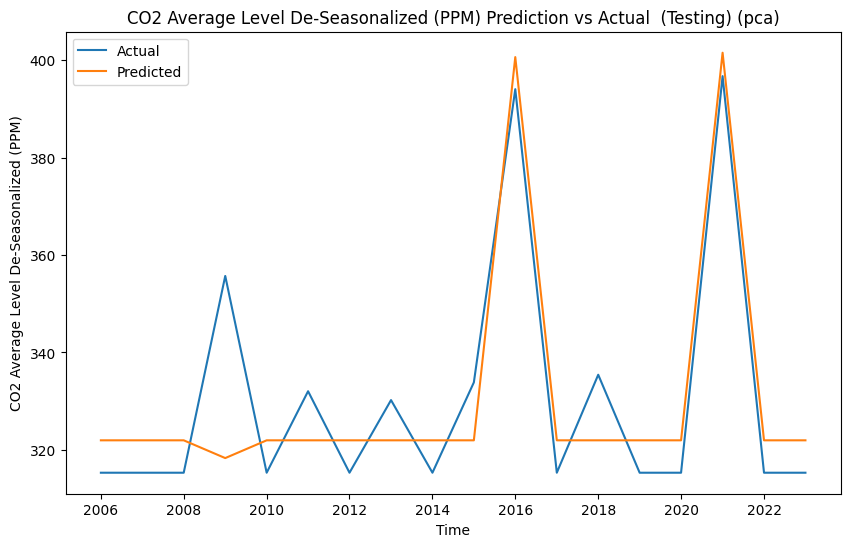

In [160]:
target = 'CO2 Average Level De-Seasonalized (PPM)'
results[target] = {}

info = train_linear(df_imputed, target, ridge_alpha=0.1, scaler=StandardScaler())
results[target]['all features'] = info

info = train_linear(df_imputed, target, ridge_alpha=0.1,
                    scaler=StandardScaler(), pca_selected_features=pca_selected_features)
results[target]['pca selected features'] = info

In [161]:
results

{'Raw Global Temperature Anomaly (C)': {'all features': {'val_mse': 0.008585854218289805,
   'val_r2': 0.9256659799621685,
   'test_mse': 0.0069702129141316705,
   'test_r2': 0.918940539827904},
  'pca selected features': {'val_mse': 0.07850473375693823,
   'val_r2': 0.32032709806302184,
   'test_mse': 0.04287103220663783,
   'test_r2': 0.501435211448843}},
 'Smoothed Global Temperature Anomaly (C)': {'all features': {'val_mse': 0.004174830791534517,
   'val_r2': 0.961217945550975,
   'test_mse': 0.0023367541429262662,
   'test_r2': 0.970087656214986},
  'pca selected features': {'val_mse': 0.07013455874705432,
   'val_r2': 0.3484856244708189,
   'test_mse': 0.02650223612192749,
   'test_r2': 0.6607499336845191}},
 'Antarctic Ice Mass Lost Since 2002 (GT)': {'all features': {'val_mse': 9043.945432274339,
   'val_r2': -0.2744678687535642,
   'test_mse': 6283.494080791317,
   'test_r2': 0.9542400216530987},
  'pca selected features': {'val_mse': 80604.49592589751,
   'val_r2': -10.358741

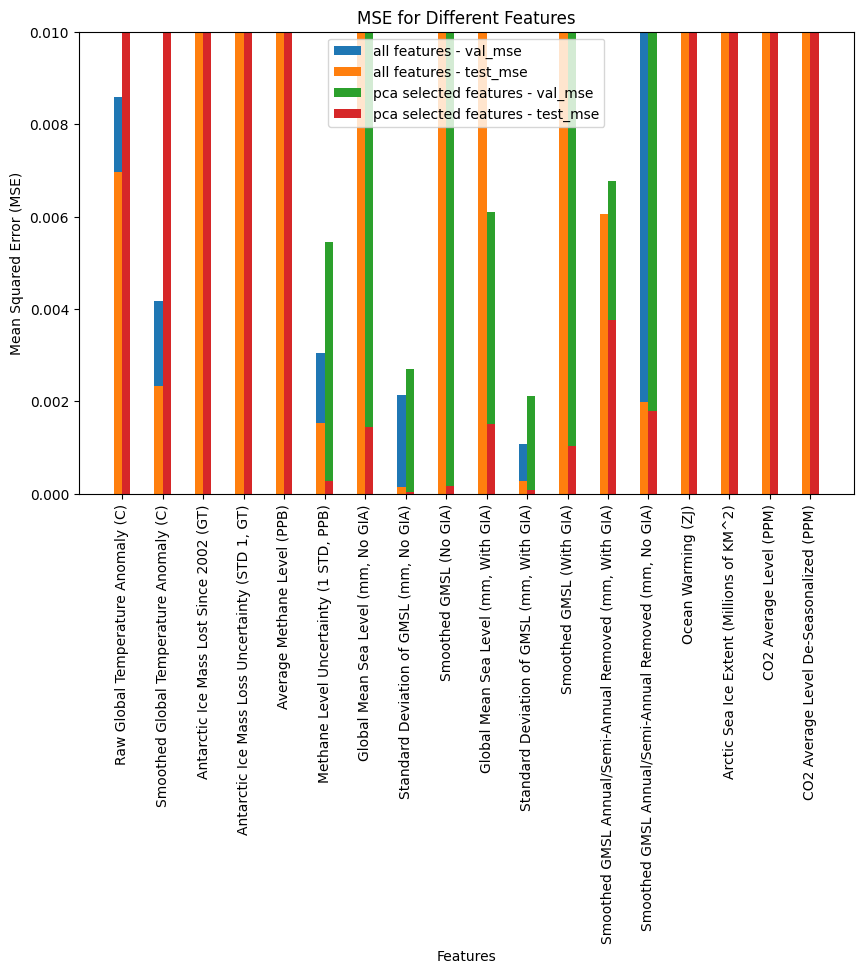

In [162]:
# Extract features and metrics
features = list(results.keys())
feature_types = list(results[features[0]].keys())
mse_metrics = ['val_mse', 'test_mse']

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(features))

for i, feature_type in enumerate(feature_types):
    for j, metric in enumerate(mse_metrics):
        values = [results[feature][feature_type][metric] for feature in features]
        ax.bar(index + i * bar_width, values, bar_width, label=f'{feature_type} - {metric}')

ax.set_xlabel('Features')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('MSE for Different Features')
ax.set_xticks(index + bar_width * (len(feature_types) - 1) / 2)
ax.set_xticklabels(features, rotation='vertical')
ax.legend()

ax.set_ylim(0, 0.01)

plt.show()

In [163]:
df_imputed.columns.values

array(['Year', 'Antarctic Ice Mass Lost Since 2002 (GT)',
       'Antarctic Ice Mass Loss Uncertainty (STD 1, GT)',
       'Raw Global Temperature Anomaly (C)',
       'Smoothed Global Temperature Anomaly (C)',
       'Average Methane Level (PPB)',
       'Methane Level Uncertainty (1 STD, PPB)',
       'Global Mean Sea Level (mm, No GIA)',
       'Standard Deviation of GMSL (mm, No GIA)',
       'Smoothed GMSL (No GIA)', 'Global Mean Sea Level (mm, With GIA)',
       'Standard Deviation of GMSL (mm, With GIA)',
       'Smoothed GMSL (With GIA)',
       'Smoothed GMSL Annual/Semi-Annual Removed (mm, With GIA)',
       'Smoothed GMSL Annual/Semi-Annual Removed (mm, No GIA)',
       'Ocean Warming (ZJ)', 'Arctic Sea Ice Extent (Millions of KM^2)',
       'CO2 Average Level (PPM)',
       'CO2 Average Level De-Seasonalized (PPM)'], dtype=object)

In [164]:
results = {}

In [165]:
results['df_imputed'] = {}

In [166]:
columns = df_imputed.columns.values
columns
for column in columns:
  target = column
  train_linear(df_imputed, target, ridge_alpha=0.1, scaler=StandardScaler())

Output hidden; open in https://colab.research.google.com to view.

In [167]:
results['df_imputed'] = {}

In [168]:
def get_df_imputed_results(Target):
  model1, m_1, r2_1 = get_mse_r2(Target, df_imputed)
  model2, m_2, r2_2 = get_mse_r2_pca(Target,pca_selected_features, df_imputed)
  results['df_imputed'][Target] = {}
  results['df_imputed'][Target]['mse'] = m_1
  results['df_imputed'][Target]['r2'] = r2_1
  results['df_imputed'][Target]['mse (pca)'] = m_2
  results['df_imputed'][Target]['r2 (pca)'] = r2_2


In [169]:
columns = df_imputed.columns.values
columns
for column in columns:
  target = column
  get_df_imputed_results(target)

In [170]:
results

{'df_imputed': {'Year': {'mse': 188.35977283657988,
   'r2': 0.8830110179758389,
   'mse (pca)': 905.0272026250881,
   'r2 (pca)': 0.43789372037976126},
  'Antarctic Ice Mass Lost Since 2002 (GT)': {'mse': 11491.349063792572,
   'r2': 0.8717778410235334,
   'mse (pca)': 19512.72491885501,
   'r2 (pca)': 0.782274152258347},
  'Antarctic Ice Mass Loss Uncertainty (STD 1, GT)': {'mse': 23.943931908212107,
   'r2': 0.9122064475561158,
   'mse (pca)': 31.051306200084912,
   'r2 (pca)': 0.8861463317813193},
  'Raw Global Temperature Anomaly (C)': {'mse': 0.007954435036602252,
   'r2': 0.9135025282548334,
   'mse (pca)': 0.035841731936100976,
   'r2 (pca)': 0.6102527481618614},
  'Smoothed Global Temperature Anomaly (C)': {'mse': 0.0032669842331981363,
   'r2': 0.9654130277029795,
   'mse (pca)': 0.029131086224791155,
   'r2 (pca)': 0.6915944490945265},
  'Average Methane Level (PPB)': {'mse': 144.6814973226255,
   'r2': 0.9522334635106133,
   'mse (pca)': 422.73683962525763,
   'r2 (pca)': 0

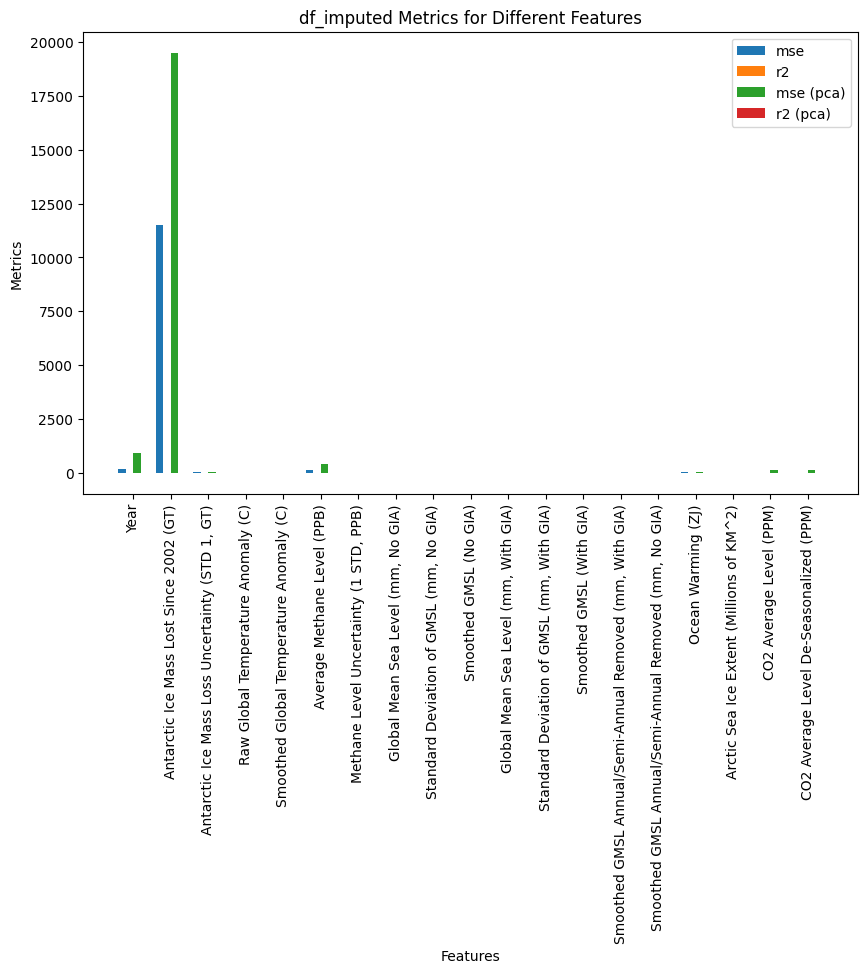

In [171]:
features = list(results['df_imputed'].keys())
metrics = list(results['df_imputed']['Year'].keys())

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(features))

for i, metric in enumerate(metrics):
    values = [results['df_imputed'][feature][metric] for feature in features]
    ax.bar(index + i * bar_width, values, bar_width, label=metric)

ax.set_xlabel('Features')
ax.set_ylabel('Metrics')
ax.set_title('df_imputed Metrics for Different Features')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(features, rotation='vertical')  # Rotate x-axis labels vertically
ax.legend()

plt.show()


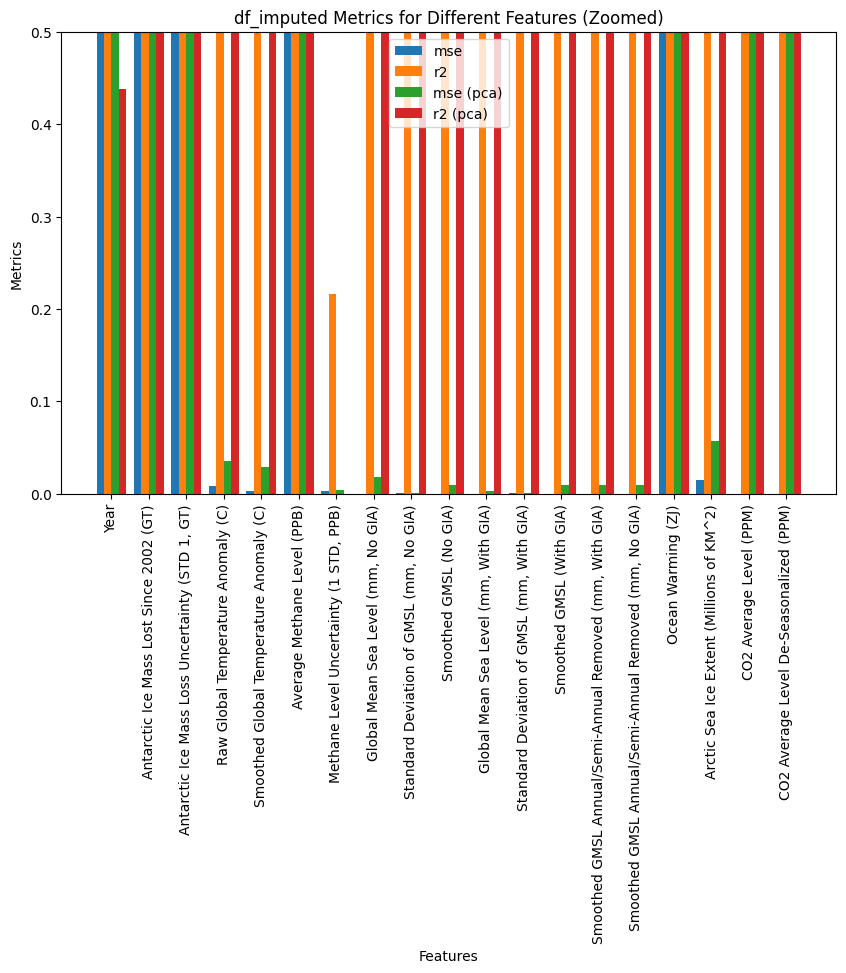

In [172]:
features = list(results['df_imputed'].keys())
metrics = list(results['df_imputed']['Year'].keys())

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(features))

for i, metric in enumerate(metrics):
    values = [results['df_imputed'][feature][metric] for feature in features]
    ax.bar(index + i * bar_width, values, bar_width, label=metric)

ax.set_xlabel('Features')
ax.set_ylabel('Metrics')
ax.set_title('df_imputed Metrics for Different Features (Zoomed)')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(features, rotation='vertical')  # Rotate x-axis labels vertically
ax.legend()
ax.set_ylim(0, 0.5)

plt.show()

#### 5.2.4 LSTM With df_imputed

In [183]:
def create_train_test_xy(df, target_column_index, scaled_data, sequence_length, num_features, val_split=0.8):
  sequences = []
  labels = []
  for i in range(len(scaled_data) - sequence_length):
      seq = scaled_data[i:i+sequence_length]
      label = scaled_data[i+sequence_length][target_column_index]
      sequences.append(seq)
      labels.append(label)

  sequences = np.array(sequences)
  labels = np.array(labels)

  train_size = int(val_split * len(sequences))
  train_x, test_x = sequences[:train_size], sequences[train_size:]
  train_y, test_y = labels[:train_size], labels[train_size:]

  return train_x, train_y, test_x, test_y

In [184]:
print(df_imputed.shape)
df_imputed['Year'] = pd.to_datetime(df_imputed['Year'], format='%Y')
df_final = df_imputed.set_index('Year')
df_final.tail()

(144, 19)


Antarctic Ice Mass Lost Since 2002 (GT)  \
Year                                                  
2019-01-01                             -2326.797500   
2020-01-01                             -2557.049167   
2021-01-01                             -2638.302500   
2022-01-01                             -2438.013333   
2023-01-01                             -2329.820000   

            Antarctic Ice Mass Loss Uncertainty (STD 1, GT)  \
Year                                                          
2019-01-01                                        26.829167   
2020-01-01                                        26.781667   
2021-01-01                                        26.724167   
2022-01-01                                        28.221667   
2023-01-01                                        45.351667   

            Raw Global Temperature Anomaly (C)  \
Year                                             
2019-01-01                                0.97   
2020-01-01                                1.01   
2021-01-01                                0.84   
2022-01-01                                0.89   
2023-01-01                                0.89   

            Smoothed Global Temperature Anomaly (C)  \
Year                                                  
2019-01-01                                     0.92   
2020-01-01                                     0.91   
2021-01-01                                     0.91   
2022-01-01                                     0.90   
2023-01-01                                     0.90   

            Average Methane Level (PPB)  \
Year                                      
2019-01-01                      1866.58   
2020-01-01                      1878.93   
2021-01-01                      1895.28   
2022-01-01                      1911.82   
2023-01-01                      1911.82   

            Methane Level Uncertainty (1 STD, PPB)  \
Year                                                 
2019-01-01                                    0.60   
2020-01-01                                    0.56   
2021-01-01                                    0.55   
2022-01-01                                    0.78   
2023-01-01                                    0.78   

            Global Mean Sea Level (mm, No GIA)  \
Year                                             
2019-01-01                           49.165676   
2020-01-01                           49.711111   
2021-01-01                           53.933784   
2022-01-01                           56.301892   
2023-01-01                           57.224500   

            Standard Deviation of GMSL (mm, No GIA)  Smoothed GMSL (No GIA)  \
Year                                                                          
2019-01-01                                87.808649               49.064054   
2020-01-01                                87.150556               49.845278   
2021-01-01                                87.137297               53.925946   
2022-01-01                                88.444324               56.200541   
2023-01-01                                86.311500               57.104000   

            Global Mean Sea Level (mm, With GIA)  \
Year                                               
2019-01-01                             55.612162   
2020-01-01                             56.413333   
2021-01-01                             60.873514   
2022-01-01                             63.486216   
2023-01-01                             64.598000   

            Standard Deviation of GMSL (mm, With GIA)  \
Year                                                    
2019-01-01                                  88.024054   
2020-01-01                                  87.258611   
2021-01-01                                  87.179189   
2022-01-01                                  88.608108   
2023-01-01                                  86.308500   

            Smoothed GMSL (With GIA)  \
Year                                   
2019-01-01      

In [185]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_final)

sequence_length = 5
num_features = len(df_final.columns)

target_column_name = "Raw Global Temperature Anomaly (C)"
target_column_index = df_final.columns.get_loc(target_column_name)

X_train, y_train, X_test, y_test = create_train_test_xy(df_final, target_column_index,
                                                        scaled_data, sequence_length, num_features)
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (111, 5, 18)
y_train.shape:  (111,)
X_test.shape:  (28, 5, 18)
y_test.shape:  (28,)


In [186]:
model = lstm_model(X_train)

In [187]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            75264     
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [188]:
# Define callbacks
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/climate-change-analysis/best_model_weights.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[model_checkpoint]
)

Epoch 1/100
1/2 [==============>...............] - ETA: 6s - loss: 0.0795

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 9s 2s/step - loss: 0.0734 - val_loss: 0.1713
Epoch 2/100
2/2 [==============================] - 0s 110ms/step - loss: 0.0309 - val_loss: 0.0970
Epoch 3/100
2/2 [==============================] - 0s 110ms/step - loss: 0.0128 - val_loss: 0.0481
Epoch 4/100
2/2 [==============================] - 0s 102ms/step - loss: 0.0155 - val_loss: 0.0348
Epoch 5/100
2/2 [==============================] - 0s 51ms/step - loss: 0.0206 - val_loss: 0.0437
Epoch 6/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0147 - val_loss: 0.0626
Epoch 7/100
2/2 [==============================] - 0s 50ms/step - loss: 0.0112 - val_loss: 0.0823
Epoch 8/100
2/2 [==============================] - 0s 62ms/step - loss: 0.0139 - val_loss: 0.0954
Epoch 9/100
2/2 [==============================] - 0s 51ms/step - loss: 0.0143 - val_loss: 0.0992
Epoch 10/100
2/2 [==============================] - 0s 48ms/step - loss: 0.0151 - val_loss: 0.0938
Epoch 11/100
2/2 [============

In [189]:
# Evaluate the best model on the test set
best_model = tf.keras.models.load_model('/content/drive/My Drive/climate-change-analysis/best_model_weights.h5')
test_loss = best_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

1/1 [==============================] - 1s 1s/step - loss: 0.0055
Test Loss: 0.005470932461321354


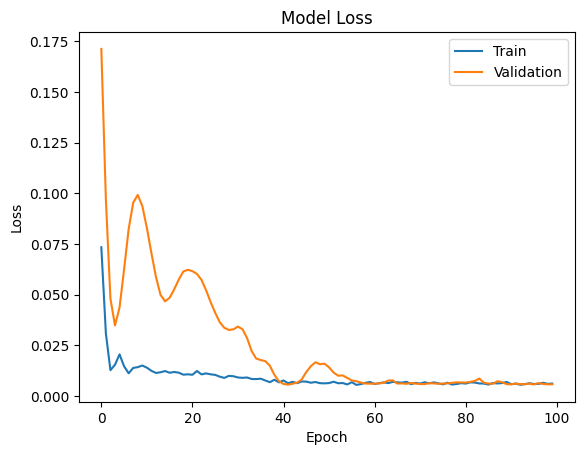

In [190]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [191]:
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_temp = scaler.inverse_transform(y_test_copies)[:,target_column_index]

predictions = best_model.predict(X_test)
prediction_copies = np.repeat(predictions, X_test.shape[-1], axis=-1)
predicted_temp = scaler.inverse_transform(prediction_copies)[:,target_column_index]

mse = mean_squared_error(y_test, predictions)
print("MSE: ", mse)
print("true_temp: ", true_temp)
print("predicted_temp: ", predicted_temp)

1/1 [==============================] - 1s 1s/step
MSE:  0.005470933043363664
true_temp:  [0.33 0.46 0.61 0.38 0.39 0.53 0.62 0.62 0.53 0.67 0.63 0.66 0.54 0.65
 0.72 0.61 0.65 0.67 0.74 0.9  1.01 0.92 0.85 0.97 1.01 0.84 0.89 0.89]
predicted_temp:  [0.39333135 0.37518266 0.39647543 0.43979084 0.4649961  0.48078275
 0.47383755 0.55069065 0.5911074  0.61875623 0.6225946  0.6238151
 0.62412375 0.64472437 0.6767908  0.68367195 0.7028478  0.71035206
 0.7179756  0.7213053  0.7257544  0.75468636 0.77668935 0.7906396
 0.81340706 0.8554657  0.86421394 0.8536848 ]


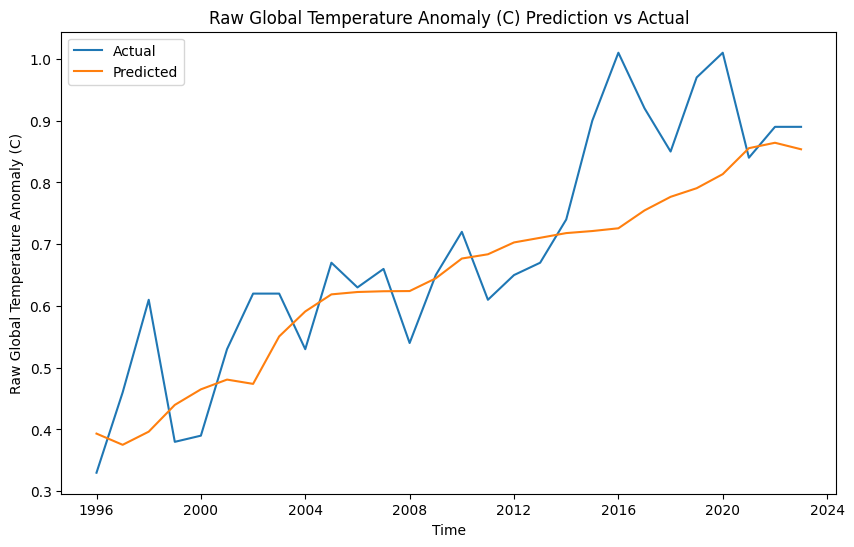

In [192]:
# Plotting predicted and actual temperatures
plt.figure(figsize=(10, 6))
plt.plot(df_final.index[-X_test.shape[0]:], true_temp, label='Actual')
plt.plot(df_final.index[-X_test.shape[0]:], predicted_temp, label='Predicted')
plt.title('Raw Global Temperature Anomaly (C) Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Raw Global Temperature Anomaly (C)')
plt.legend()
plt.show()

#### 5.2.5 LSTM With df_no_nans

In [193]:
print(merged_df_no_nan.shape)
merged_df_no_nan['Year'] = pd.to_datetime(merged_df_no_nan['Year'], format='%Y')
df_final = merged_df_no_nan.set_index('Year')
df_final.tail()

(18, 19)


<ipython-input-193-73de4455e21d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_no_nan['Year'] = pd.to_datetime(merged_df_no_nan['Year'], format='%Y')


Antarctic Ice Mass Lost Since 2002 (GT)  \
Year                                                  
2015-01-01                             -1850.552222   
2016-01-01                             -1775.763333   
2017-01-01                             -1818.544000   
2018-01-01                             -2129.990000   
2019-01-01                             -2326.797500   

            Antarctic Ice Mass Loss Uncertainty (STD 1, GT)  \
Year                                                          
2015-01-01                                        37.300000   
2016-01-01                                        41.070000   
2017-01-01                                        60.672000   
2018-01-01                                        30.290000   
2019-01-01                                        26.829167   

            Raw Global Temperature Anomaly (C)  \
Year                                             
2015-01-01                                0.90   
2016-01-01                                1.01   
2017-01-01                                0.92   
2018-01-01                                0.85   
2019-01-01                                0.97   

            Smoothed Global Temperature Anomaly (C)  \
Year                                                  
2015-01-01                                     0.83   
2016-01-01                                     0.87   
2017-01-01                                     0.91   
2018-01-01                                     0.93   
2019-01-01                                     0.92   

            Average Methane Level (PPB)  \
Year                                      
2015-01-01                      1834.26   
2016-01-01                      1843.12   
2017-01-01                      1849.58   
2018-01-01                      1857.33   
2019-01-01                      1866.58   

            Methane Level Uncertainty (1 STD, PPB)  \
Year                                                 
2015-01-01                                    0.55   
2016-01-01                                    0.68   
2017-01-01                                    0.64   
2018-01-01                                    0.82   
2019-01-01                                    0.60   

            Global Mean Sea Level (mm, No GIA)  \
Year                                             
2015-01-01                           35.436486   
2016-01-01                           37.478649   
2017-01-01                           38.332973   
2018-01-01                           42.260811   
2019-01-01                           49.165676   

            Standard Deviation of GMSL (mm, No GIA)  Smoothed GMSL (No GIA)  \
Year                                                                          
2015-01-01                                94.597838               35.513514   
2016-01-01                                90.919459               37.436216   
2017-01-01                                84.585405               38.335135   
2018-01-01                                86.053243               42.319730   
2019-01-01                                87.808649               49.064054   

            Global Mean Sea Level (mm, With GIA)  \
Year                                               
2015-01-01                             40.910541   
2016-01-01                             43.196486   
2017-01-01                             44.297568   
2018-01-01                             48.465946   
2019-01-01                             55.612162   

            Standard Deviation of GMSL (mm, With GIA)  \
Year                                                    
2015-01-01                                  94.895135   
2016-01-01                                  91.112703   
2017-01-01                                  84.826486   
2018-01-01                                  86.218378   
2019-01-01                                  88.024054   

            Smoothed GMSL (With GIA)  \
Year                                   
2015-01-01      

In [194]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_final)

sequence_length = 5
num_features = len(df_final.columns)

target_column_name = "Raw Global Temperature Anomaly (C)"
target_column_index = df_final.columns.get_loc(target_column_name)

X_train, y_train, X_test, y_test = create_train_test_xy(df_final, target_column_index,
                                                        scaled_data, sequence_length, num_features, 0.6)
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (7, 5, 18)
y_train.shape:  (7,)
X_test.shape:  (6, 5, 18)
y_test.shape:  (6,)


In [195]:
model = lstm_model(X_train)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 5, 128)            75264     
                                                                 
 dropout_3 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 64)             49408     
                                                                 
 dropout_4 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [196]:
# Define callbacks
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/climate-change-analysis/best_model_weights.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[model_checkpoint]
)

Epoch 1/100
1/1 [==============================] - 8s 8s/step - loss: 0.0732 - val_loss: 0.0578
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.0539

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 176ms/step - loss: 0.0539 - val_loss: 0.0385
Epoch 3/100
1/1 [==============================] - 0s 155ms/step - loss: 0.0421 - val_loss: 0.0233
Epoch 4/100
1/1 [==============================] - 0s 146ms/step - loss: 0.0283 - val_loss: 0.0116
Epoch 5/100
1/1 [==============================] - 0s 152ms/step - loss: 0.0169 - val_loss: 0.0038
Epoch 6/100
1/1 [==============================] - 0s 151ms/step - loss: 0.0164 - val_loss: 3.6915e-04
Epoch 7/100
1/1 [==============================] - 0s 90ms/step - loss: 0.0133 - val_loss: 0.0011
Epoch 8/100
1/1 [==============================] - 0s 92ms/step - loss: 0.0160 - val_loss: 0.0029
Epoch 9/100
1/1 [==============================] - 0s 91ms/step - loss: 0.0245 - val_loss: 0.0039
Epoch 10/100
1/1 [==============================] - 0s 80ms/step - loss: 0.0245 - val_loss: 0.0025
Epoch 11/100
1/1 [==============================] - 0s 95ms/step - loss: 0.0170 - val_loss: 0.0014
Epoch 12/100
1/1 [===

In [197]:
# Evaluate the best model on the test set
best_model = tf.keras.models.load_model('/content/drive/My Drive/climate-change-analysis/best_model_weights.h5')
test_loss = best_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

1/1 [==============================] - 1s 1s/step - loss: 0.2353
Test Loss: 0.23532341420650482


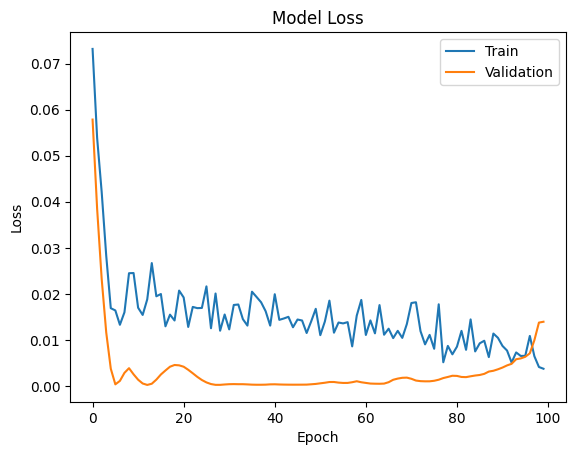

In [198]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [199]:
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_temp = scaler.inverse_transform(y_test_copies)[:,target_column_index]

predictions = best_model.predict(X_test)
prediction_copies = np.repeat(predictions, X_test.shape[-1], axis=-1)
predicted_temp = scaler.inverse_transform(prediction_copies)[:,target_column_index]

mse = mean_squared_error(y_test, predictions)
print("MSE: ", mse)

1/1 [==============================] - 1s 1s/step
MSE:  0.23532340518030823


In [200]:
print("true_temp: ", true_temp)
print("predicted_temp: ", predicted_temp)

true_temp:  [0.74 0.9  1.01 0.92 0.85 0.97]
predicted_temp:  [0.6664624  0.66870725 0.67203826 0.68225455 0.693758   0.70306486]


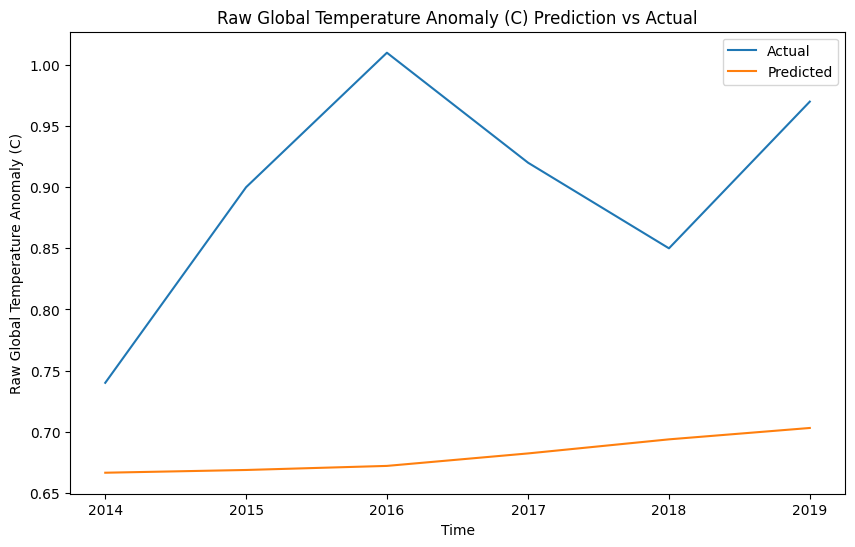

In [201]:
# Plotting predicted and actual temperatures
plt.figure(figsize=(10, 6))
plt.plot(df_final.index[-X_test.shape[0]:], true_temp, label='Actual')
plt.plot(df_final.index[-X_test.shape[0]:], predicted_temp, label='Predicted')
plt.title('Raw Global Temperature Anomaly (C) Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Raw Global Temperature Anomaly (C)')
plt.legend()
plt.show()

#### 5.2.5 LSTM With df_averages

In [202]:
print(df_averages.shape)
df_averages['Year'] = pd.to_datetime(df_averages['Year'], format='%Y')
df_final = df_averages.set_index('Year')
df_final.tail()

(18, 19)


Antarctic Ice Mass Lost Since 2002 (GT)  \
Year                                                  
2015-01-01                             -1850.552222   
2016-01-01                             -1775.763333   
2017-01-01                             -1818.544000   
2018-01-01                             -2129.990000   
2019-01-01                             -2326.797500   

            Antarctic Ice Mass Loss Uncertainty (STD 1, GT)  \
Year                                                          
2015-01-01                                        37.300000   
2016-01-01                                        41.070000   
2017-01-01                                        60.672000   
2018-01-01                                        30.290000   
2019-01-01                                        26.829167   

            Raw Global Temperature Anomaly (C)  \
Year                                             
2015-01-01                                0.90   
2016-01-01                                1.01   
2017-01-01                                0.92   
2018-01-01                                0.85   
2019-01-01                                0.97   

            Smoothed Global Temperature Anomaly (C)  \
Year                                                  
2015-01-01                                     0.83   
2016-01-01                                     0.87   
2017-01-01                                     0.91   
2018-01-01                                     0.93   
2019-01-01                                     0.92   

            Average Methane Level (PPB)  \
Year                                      
2015-01-01                      1834.26   
2016-01-01                      1843.12   
2017-01-01                      1849.58   
2018-01-01                      1857.33   
2019-01-01                      1866.58   

            Methane Level Uncertainty (1 STD, PPB)  \
Year                                                 
2015-01-01                                    0.55   
2016-01-01                                    0.68   
2017-01-01                                    0.64   
2018-01-01                                    0.82   
2019-01-01                                    0.60   

            Global Mean Sea Level (mm, No GIA)  \
Year                                             
2015-01-01                           35.436486   
2016-01-01                           37.478649   
2017-01-01                           38.332973   
2018-01-01                           42.260811   
2019-01-01                           49.165676   

            Standard Deviation of GMSL (mm, No GIA)  Smoothed GMSL (No GIA)  \
Year                                                                          
2015-01-01                                94.597838               35.513514   
2016-01-01                                90.919459               37.436216   
2017-01-01                                84.585405               38.335135   
2018-01-01                                86.053243               42.319730   
2019-01-01                                87.808649               49.064054   

            Global Mean Sea Level (mm, With GIA)  \
Year                                               
2015-01-01                             40.910541   
2016-01-01                             43.196486   
2017-01-01                             44.297568   
2018-01-01                             48.465946   
2019-01-01                             55.612162   

            Standard Deviation of GMSL (mm, With GIA)  \
Year                                                    
2015-01-01                                  94.895135   
2016-01-01                                  91.112703   
2017-01-01                                  84.826486   
2018-01-01                                  86.218378   
2019-01-01                                  88.024054   

            Smoothed GMSL (With GIA)  \
Year                                   
2015-01-01      

In [203]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_final)

sequence_length = 5
num_features = len(df_final.columns)

target_column_name = "Raw Global Temperature Anomaly (C)"
target_column_index = df_final.columns.get_loc(target_column_name)

X_train, y_train, X_test, y_test = create_train_test_xy(df_final, target_column_index,
                                                        scaled_data, sequence_length, num_features, 0.6)
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (7, 5, 18)
y_train.shape:  (7,)
X_test.shape:  (6, 5, 18)
y_test.shape:  (6,)


In [204]:
model = lstm_model(X_train)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 128)            75264     
                                                                 
 dropout_6 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_7 (LSTM)               (None, 5, 64)             49408     
                                                                 
 dropout_7 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [205]:
# Define callbacks
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/climate-change-analysis/best_model_weights.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[model_checkpoint]
)

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.0511

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 9s 9s/step - loss: 0.0511 - val_loss: 0.0301
Epoch 2/100
1/1 [==============================] - 0s 107ms/step - loss: 0.0378 - val_loss: 0.0148
Epoch 3/100
1/1 [==============================] - 0s 108ms/step - loss: 0.0234 - val_loss: 0.0042
Epoch 4/100
1/1 [==============================] - 0s 106ms/step - loss: 0.0146 - val_loss: 1.5268e-04
Epoch 5/100
1/1 [==============================] - 0s 59ms/step - loss: 0.0171 - val_loss: 0.0033
Epoch 6/100
1/1 [==============================] - 0s 52ms/step - loss: 0.0176 - val_loss: 0.0110
Epoch 7/100
1/1 [==============================] - 0s 49ms/step - loss: 0.0329 - val_loss: 0.0114
Epoch 8/100
1/1 [==============================] - 0s 52ms/step - loss: 0.0143 - val_loss: 0.0087
Epoch 9/100
1/1 [==============================] - 0s 55ms/step - loss: 0.0219 - val_loss: 0.0045
Epoch 10/100
1/1 [==============================] - 0s 49ms/step - loss: 0.0197 - val_loss: 0.0015
Epoch 11/100
1/1 [========

In [206]:
# Evaluate the best model on the test set
best_model = tf.keras.models.load_model('/content/drive/My Drive/climate-change-analysis/best_model_weights.h5')
test_loss = best_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

1/1 [==============================] - 2s 2s/step - loss: 0.2294
Test Loss: 0.22939713299274445


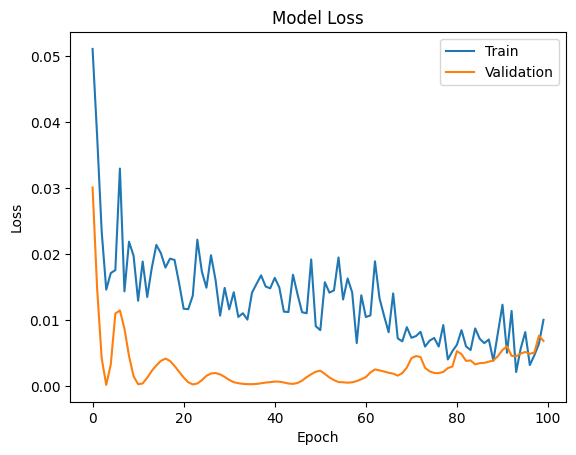

In [207]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [208]:
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_temp = scaler.inverse_transform(y_test_copies)[:,target_column_index]

predictions = best_model.predict(X_test)
prediction_copies = np.repeat(predictions, X_test.shape[-1], axis=-1)
predicted_temp = scaler.inverse_transform(prediction_copies)[:,target_column_index]

mse = mean_squared_error(y_test, predictions)
print("MSE: ", mse)

1/1 [==============================] - 1s 1s/step
MSE:  0.22939715200456126


In [209]:
print("true_temp: ", true_temp)
print("predicted_temp: ", predicted_temp)

true_temp:  [0.74 0.9  1.01 0.92 0.85 0.97]
predicted_temp:  [0.66589564 0.6689298  0.6734821  0.6875846  0.69945735 0.7086394 ]


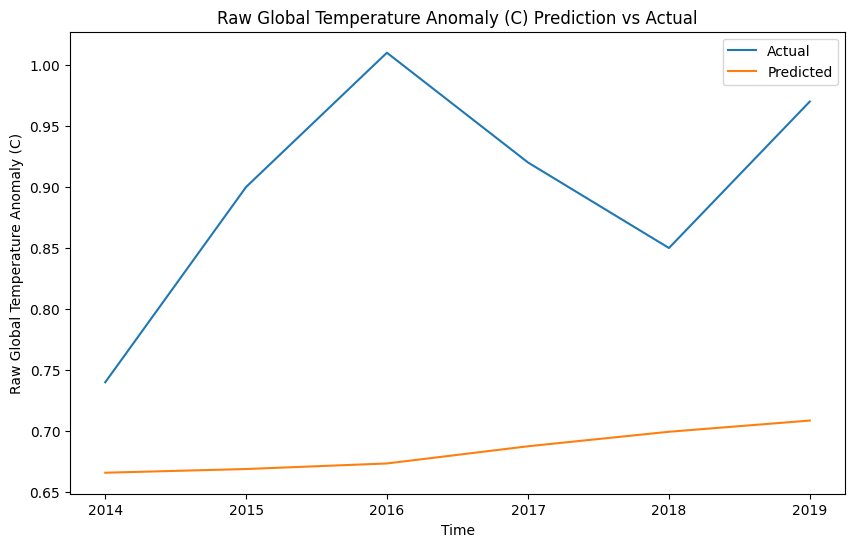

In [210]:
# Plotting predicted and actual temperatures
plt.figure(figsize=(10, 6))
plt.plot(df_final.index[-X_test.shape[0]:], true_temp, label='Actual')
plt.plot(df_final.index[-X_test.shape[0]:], predicted_temp, label='Predicted')
plt.title('Raw Global Temperature Anomaly (C) Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Raw Global Temperature Anomaly (C)')
plt.legend()
plt.show()

#### 5.2.6 LSTM With df Containing NaNs (Masking)

In [211]:
print(merged_df.shape)
merged_df['Year'] = pd.to_datetime(merged_df['Year'], format='%Y')
df_final = merged_df.set_index('Year')
df_final.tail()

(144, 19)


Antarctic Ice Mass Lost Since 2002 (GT)  \
Year                                                  
2019-01-01                             -2326.797500   
2020-01-01                             -2557.049167   
2021-01-01                             -2638.302500   
2022-01-01                             -2438.013333   
2023-01-01                             -2329.820000   

            Antarctic Ice Mass Loss Uncertainty (STD 1, GT)  \
Year                                                          
2019-01-01                                        26.829167   
2020-01-01                                        26.781667   
2021-01-01                                        26.724167   
2022-01-01                                        28.221667   
2023-01-01                                        45.351667   

            Raw Global Temperature Anomaly (C)  \
Year                                             
2019-01-01                                0.97   
2020-01-01                                1.01   
2021-01-01                                0.84   
2022-01-01                                0.89   
2023-01-01                                 NaN   

            Smoothed Global Temperature Anomaly (C)  \
Year                                                  
2019-01-01                                     0.92   
2020-01-01                                     0.91   
2021-01-01                                     0.91   
2022-01-01                                     0.90   
2023-01-01                                      NaN   

            Average Methane Level (PPB)  \
Year                                      
2019-01-01                      1866.58   
2020-01-01                      1878.93   
2021-01-01                      1895.28   
2022-01-01                      1911.82   
2023-01-01                          NaN   

            Methane Level Uncertainty (1 STD, PPB)  \
Year                                                 
2019-01-01                                    0.60   
2020-01-01                                    0.56   
2021-01-01                                    0.55   
2022-01-01                                    0.78   
2023-01-01                                     NaN   

            Global Mean Sea Level (mm, No GIA)  \
Year                                             
2019-01-01                           49.165676   
2020-01-01                           49.711111   
2021-01-01                           53.933784   
2022-01-01                           56.301892   
2023-01-01                           57.224500   

            Standard Deviation of GMSL (mm, No GIA)  Smoothed GMSL (No GIA)  \
Year                                                                          
2019-01-01                                87.808649               49.064054   
2020-01-01                                87.150556               49.845278   
2021-01-01                                87.137297               53.925946   
2022-01-01                                88.444324               56.200541   
2023-01-01                                86.311500               57.104000   

            Global Mean Sea Level (mm, With GIA)  \
Year                                               
2019-01-01                             55.612162   
2020-01-01                             56.413333   
2021-01-01                             60.873514   
2022-01-01                             63.486216   
2023-01-01                             64.598000   

            Standard Deviation of GMSL (mm, With GIA)  \
Year                                                    
2019-01-01                                  88.024054   
2020-01-01                                  87.258611   
2021-01-01                                  87.179189   
2022-01-01                                  88.608108   
2023-01-01                                  86.308500   

            Smoothed GMSL (With GIA)  \
Year                                   
2019-01-01      

In [212]:
df_final = df_final.fillna(0)
df_final.tail()

Antarctic Ice Mass Lost Since 2002 (GT)  \
Year                                                  
2019-01-01                             -2326.797500   
2020-01-01                             -2557.049167   
2021-01-01                             -2638.302500   
2022-01-01                             -2438.013333   
2023-01-01                             -2329.820000   

            Antarctic Ice Mass Loss Uncertainty (STD 1, GT)  \
Year                                                          
2019-01-01                                        26.829167   
2020-01-01                                        26.781667   
2021-01-01                                        26.724167   
2022-01-01                                        28.221667   
2023-01-01                                        45.351667   

            Raw Global Temperature Anomaly (C)  \
Year                                             
2019-01-01                                0.97   
2020-01-01                                1.01   
2021-01-01                                0.84   
2022-01-01                                0.89   
2023-01-01                                0.00   

            Smoothed Global Temperature Anomaly (C)  \
Year                                                  
2019-01-01                                     0.92   
2020-01-01                                     0.91   
2021-01-01                                     0.91   
2022-01-01                                     0.90   
2023-01-01                                     0.00   

            Average Methane Level (PPB)  \
Year                                      
2019-01-01                      1866.58   
2020-01-01                      1878.93   
2021-01-01                      1895.28   
2022-01-01                      1911.82   
2023-01-01                         0.00   

            Methane Level Uncertainty (1 STD, PPB)  \
Year                                                 
2019-01-01                                    0.60   
2020-01-01                                    0.56   
2021-01-01                                    0.55   
2022-01-01                                    0.78   
2023-01-01                                    0.00   

            Global Mean Sea Level (mm, No GIA)  \
Year                                             
2019-01-01                           49.165676   
2020-01-01                           49.711111   
2021-01-01                           53.933784   
2022-01-01                           56.301892   
2023-01-01                           57.224500   

            Standard Deviation of GMSL (mm, No GIA)  Smoothed GMSL (No GIA)  \
Year                                                                          
2019-01-01                                87.808649               49.064054   
2020-01-01                                87.150556               49.845278   
2021-01-01                                87.137297               53.925946   
2022-01-01                                88.444324               56.200541   
2023-01-01                                86.311500               57.104000   

            Global Mean Sea Level (mm, With GIA)  \
Year                                               
2019-01-01                             55.612162   
2020-01-01                             56.413333   
2021-01-01                             60.873514   
2022-01-01                             63.486216   
2023-01-01                             64.598000   

            Standard Deviation of GMSL (mm, With GIA)  \
Year                                                    
2019-01-01                                  88.024054   
2020-01-01                                  87.258611   
2021-01-01                                  87.179189   
2022-01-01                                  88.608108   
2023-01-01                                  86.308500   

            Smoothed GMSL (With GIA)  \
Year                                   
2019-01-01      

In [213]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_final)

sequence_length = 5
num_features = len(df_final.columns)

target_column_name = "Raw Global Temperature Anomaly (C)"
target_column_index = df_final.columns.get_loc(target_column_name)

X_train, y_train, X_test, y_test = create_train_test_xy(df_final, target_column_index,
                                                        scaled_data, sequence_length, num_features)
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (111, 5, 18)
y_train.shape:  (111,)
X_test.shape:  (28, 5, 18)
y_test.shape:  (28,)


In [214]:
model = Sequential()

# Add Masking layer to handle variable-length sequences
model.add(Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 5, 18)             0         
                                                                 
 lstm_9 (LSTM)               (None, 5, 128)            75264     
                                                                 
 dropout_9 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_10 (LSTM)              (None, 5, 64)             49408     
                                                                 
 dropout_10 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_11 (Dropout)        (None, 32)               

In [215]:
# Define callbacks
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/climate-change-analysis/best_model_weights.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[model_checkpoint]
)

Epoch 1/100
1/2 [==============>...............] - ETA: 18s - loss: 0.0645

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 23s 5s/step - loss: 0.0578 - val_loss: 0.1465
Epoch 2/100
2/2 [==============================] - 0s 110ms/step - loss: 0.0266 - val_loss: 0.0702
Epoch 3/100
2/2 [==============================] - 0s 120ms/step - loss: 0.0125 - val_loss: 0.0207
Epoch 4/100
2/2 [==============================] - 0s 117ms/step - loss: 0.0158 - val_loss: 0.0108
Epoch 5/100
2/2 [==============================] - 0s 51ms/step - loss: 0.0202 - val_loss: 0.0158
Epoch 6/100
2/2 [==============================] - 0s 51ms/step - loss: 0.0157 - val_loss: 0.0293
Epoch 7/100
2/2 [==============================] - 0s 52ms/step - loss: 0.0103 - val_loss: 0.0448
Epoch 8/100
2/2 [==============================] - 0s 53ms/step - loss: 0.0110 - val_loss: 0.0556
Epoch 9/100
2/2 [==============================] - 0s 55ms/step - loss: 0.0119 - val_loss: 0.0578
Epoch 10/100
2/2 [==============================] - 0s 51ms/step - loss: 0.0130 - val_loss: 0.0528
Epoch 11/100
2/2 [===========

In [216]:
# Evaluate the best model on the test set
best_model = tf.keras.models.load_model('/content/drive/My Drive/climate-change-analysis/best_model_weights.h5')
test_loss = best_model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

1/1 [==============================] - 4s 4s/step - loss: 0.0331
Test Loss: 0.03309975191950798


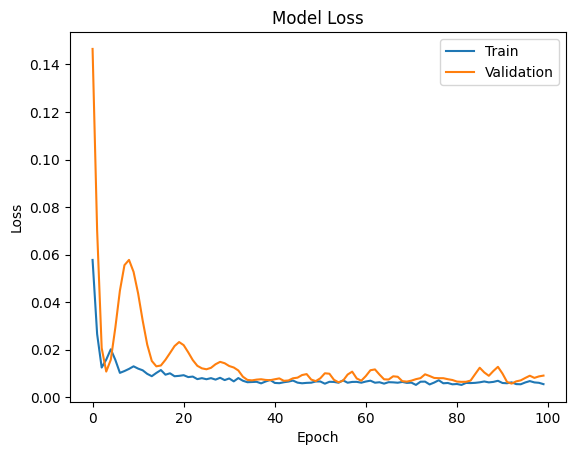

In [217]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [218]:
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_temp = scaler.inverse_transform(y_test_copies)[:,target_column_index]

predictions = best_model.predict(X_test)
prediction_copies = np.repeat(predictions, X_test.shape[-1], axis=-1)
predicted_temp = scaler.inverse_transform(prediction_copies)[:,target_column_index]

mse = mean_squared_error(y_test, predictions)
print("MSE: ", mse)
print("true_temp: ", true_temp)
print("predicted_temp: ", predicted_temp)

1/1 [==============================] - 5s 5s/step
MSE:  0.033099753641192324
true_temp:  [0.33 0.46 0.61 0.38 0.39 0.53 0.62 0.62 0.53 0.67 0.63 0.66 0.54 0.65
 0.72 0.61 0.65 0.67 0.74 0.9  1.01 0.92 0.85 0.97 1.01 0.84 0.89 0.  ]
predicted_temp:  [0.3217776  0.2997207  0.29122683 0.31468678 0.33458298 0.35133514
 0.36835754 0.39221883 0.4069864  0.42736956 0.44420385 0.4573363
 0.46957678 0.4774806  0.48871782 0.49086565 0.4925731  0.4926431
 0.49976486 0.5056212  0.5183811  0.54337543 0.5693674  0.5923753
 0.6133945  0.62731695 0.6231501  0.6128759 ]


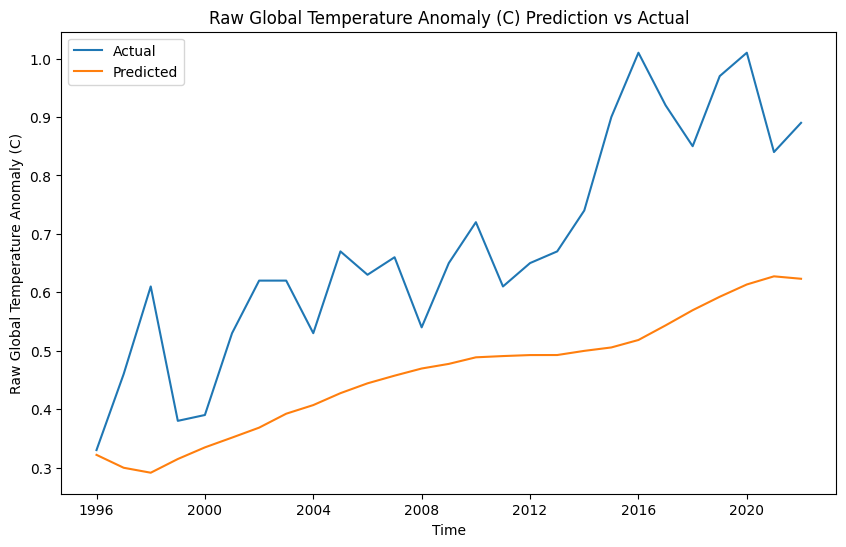

In [219]:
# Assuming true_temp and predicted_temp are NumPy arrays or Pandas Series
non_zero_indices = np.where(true_temp != 0)[0]

# Plotting predicted and actual temperatures excluding 0 values
plt.figure(figsize=(10, 6))
plt.plot(df_final.index[-X_test.shape[0]:][non_zero_indices], true_temp[non_zero_indices], label='Actual')
plt.plot(df_final.index[-X_test.shape[0]:][non_zero_indices], predicted_temp[non_zero_indices], label='Predicted')
plt.title('Raw Global Temperature Anomaly (C) Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Raw Global Temperature Anomaly (C)')
plt.legend()
plt.show()


### 5.3. Forecasting
Use the models to forecast future climate trends based on historical data.

## 6. Conclusion